# scGen Benchmarking: Internal & Cross-Study Perturbation Prediction

## What is scGen?

**scGen** (Lotfollahi et al., 2019) is a variational autoencoder (VAE) that predicts cellular responses to perturbations:
- Learns a low-dimensional latent space representation of cells
- Computes a "perturbation vector" as the average shift from control → stimulated
- Applies this vector to predict responses in unseen cell types

## Benchmarking Strategy

We use a **leave-one-out approach** for each cell type:
1. Hold out all stimulated cells of the target cell type
2. Train scGen on remaining data (other cell types + control cells of target type)
3. Predict the held-out stimulated cells
4. Compare predictions against ground truth using multiple metrics

## Evaluation Metrics

- **R²**: Proportion of variance explained
- **Pearson correlation**: Linear relationship strength
- **Mean Squared Error (MSE)**: Average prediction error
- **Energy distance**: Distributional similarity in PCA space
- **Mean-variance KDE**: Distribution shape comparison
- **Jaccard index**: Overlap of top 100 differentially expressed genes

## Overview of the scGen Notebook

This notebook presents a comprehensive benchmarking study of scGen, a deep generative model for predicting single-cell perturbation responses. It proceeds through these key phases:

* **Internal Benchmarking on Kang Dataset:** Applies scGen leave-one-out cross-validation by training on control and stimulated cells of all but one cell type and predicts the held-out stimulated cells. Metrics such as R², Pearson correlation, energy distance, and DEG overlap quantify prediction accuracy per cell type.
* **Cross-Study Benchmarking (Kang → Dong):** Extends evaluation to true generalization by training scGen on integrated Kang dataset controls and stimulated cells, then predicting held-out stimulated Dong cells using scVI- or Scanorama-integrated batch-corrected data. This tests scGen’s ability to transfer learned perturbation effects across studies with diverse experimental protocols.
* **Model Training and Prediction:** Demonstrates scGen model initialization, training with early stopping on GPU/CPU, and perturbation prediction for query cells. Includes per-cell-type analysis of gene expression distribution preservation via mean and variance R².
* **Data Integration Validation:** Visualizes dataset integration success via UMAP colored by batch, cell type, and dataset origin, ensuring batch effects are mitigated before cross-study prediction.

```python

## Install Required Dependencies

These enable perturbation analysis (pertpy), single-cell VAE modeling (scvi-tools), interactive widgets (ipywidgets), and formatted table output (tabulate).

In [1]:
# Install required packages (uncomment if needed)
# !pip install pertpy --quiet
# !pip install scvi-tools --quiet
!pip install ipywidgets --quiet
!pip install tabulate --quiet
!pip install scanorama


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


## Imports and Environment Setup

This cell imports all necessary libraries for the analysis:
* **Standard libraries**: File operations, timing, random number generation
* **Numerical stack**: NumPy, pandas, scipy for data manipulation and statistics
* **Single-cell tools**: scanpy (analysis), pertpy (perturbations), scvi-tools (scGen)
* **Deep learning**: PyTorch and PyTorch Lightning for neural network training
* **Machine learning**: scikit-learn for PCA, metrics, and density estimation
* **Visualization**: matplotlib and seaborn for plotting

**Important**: We set `SEED = 42` for reproducibility across all random operations.

```python

In [21]:
# --- Standard-library utilities ------------------------------------------------
import os                            # File-system operations
import sys                           # Python runtime details (version, path)
import time                          # Simple timing / benchmarking
from pathlib import Path             # Convenient cross-platform path handling
from collections import OrderedDict  # Deterministic dicts for reproducible logs
import random                        # Python RNG (seeded below for reproducibility)
import warnings                      # Warning control for cleaner notebook output
warnings.filterwarnings('ignore')
import glob                          # File pattern matching (e.g., "*.h5")
import math

# --- Numerical & data-handling stack -------------------------------------------
import numpy as np                             # Dense numerical arrays
import pandas as pd                            # Tabular data frames
from pandas.api.types import CategoricalDtype  # Categorical column types
from scipy import sparse, stats                # Sparse matrices + statistical functions
from scipy.spatial.distance import cosine as cosine_dist, cdist  # Distance metrics
from scipy.sparse import issparse              # Check if a matrix is sparse
from scipy.stats import linregress             # Linear regression
import scipy.sparse as sparse                  # Utilities for working with sparse matrices (common in scRNA-seq)
from scipy.stats import pearsonr, wasserstein_distance  # Pearson correlation and Wasserstein (EMD) distance
from scipy.spatial.distance import cdist, pdist         # Pairwise distances: cross-set (cdist) and within-set (pdist)
from sklearn.metrics import r2_score, pairwise_distances  # R² metric and generic pairwise distance computation
from tabulate import tabulate               # Pretty-print tables in text/console output

# --- Single-cell analysis ecosystem --------------------------------------------
import scanpy as sc             # Core single-cell workflow (AnnData, QC, plotting)
from scanpy.pl import DotPlot   # Dot plot visualization
import anndata                  # Core AnnData structure
import pertpy as pt             # Perturbation-focused tools and metrics
import scvi                     # scVI-tools (deep generative models for scRNA-seq)
from scvi import REGISTRY_KEYS  # Key constants used internally by scVI/scGen
import scanorama                # Import Scanorama for batch correction and integration of single-cell RNA-seq datasets

# --- Deep-learning backend -----------------------------------------------------
import torch                    # PyTorch (tensor ops + GPU acceleration)
import pytorch_lightning as pl  # High-level training framework for PyTorch

# --- Machine-learning utilities ------------------------------------------------
from sklearn.decomposition import PCA           # Dimensionality reduction
from sklearn.neighbors import KernelDensity     # Density estimation
from sklearn.metrics import r2_score            # R-squared metric
from sklearn.metrics import pairwise_distances  # Distance metrics

# --- Plotting & visualisation --------------------------------------------------
import matplotlib.pyplot as plt  # Base plotting library
import matplotlib as mpl         # Matplotlib base functionality
from matplotlib import rc_context # Import rc_context to temporarily set matplotlib plotting parameters
import seaborn as sns            # Statistical visualisation
from tabulate import tabulate    # Format DataFrames as readable text tables

# --- Device & runtime configuration --------------------------------------------
cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f"Running on {'GPU' if cuda_available else 'CPU'} – "
      f"{torch.cuda.get_device_name(0) if cuda_available else 'no CUDA device'}")

# --- Miscellaneous settings ----------------------------------------------------
import ipywidgets as widgets     # Interactive widgets for Jupyter notebooks

# --- Global reproducibility ----------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  # Enforce determinism
torch.backends.cudnn.benchmark = False
pl.seed_everything(SEED, workers=True)
scvi.settings.seed = SEED 

print(f"Random seed set to {SEED}")

Seed set to 42
Seed set to 42


Running on CPU – no CUDA device
Random seed set to 42


## Loading the Kang Dataset

We load the preprocessed **Kang 2018 PBMC** dataset from an .h5ad file into an AnnData object, the standard format for single-cell analysis in Scanpy. The Kang dataset contains peripheral blood mononuclear cells (PBMCs) profiled under control and stimulated conditions (IFN-β), ideal for scGen benchmarking due to its paired perturbation design across multiple cell types.

```python

In [4]:
# Load the preprocessed AnnData object (Kang dataset) from the .h5ad file
adata = sc.read_h5ad('kang_processed.h5ad')

# Display a summary of the AnnData object (n_obs × n_vars and key metadata)
adata

AnnData object with n_obs × n_vars = 29065 × 35635
    obs: 'batch', 'perturbation', 'tsne1', 'tsne2', 'ind', 'cluster', 'cell_type', 'multiplets', 'leiden'
    var: 'gene_symbol'
    uns: 'cell_type_colors', 'cluster_colors', 'leiden', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Dataset Verification

The loaded AnnData object confirms successful import of the **Kang 2018 PBMC dataset** with 29,065 cells across 35,635 genes, preprocessed with standard single-cell workflow components. Key metadata includes cell annotations (cell_type, cluster, leiden), experimental conditions (perturbation, batch), and dimensionality reductions (X_pca, X_umap, X_tsne) for immediate visualization and analysis.

Data structure breakdown:

* **.obs (29,065 cells):** cell_type (e.g., NK, CD14 Mono), perturbation (control vs stimulated), batch (technical replicates), clustering (cluster, leiden).​

* **.var (35,635 genes):** gene_symbol annotations for interpretable gene names.

* **.obsm:** Precomputed embeddings (X_pca, X_umap, X_tsne) ready for plotting.

* **.layers['counts']:** Raw counts preserved alongside normalized .X data.

* **.uns:** Analysis artifacts including neighbors, pca, rank_genes_groups from prior Scanpy workflow.

## Data Preparation & Exploration

This section renames the perturbation column to condition, standardizes category labels from "IFNb" to "stimulated", and verifies the metadata structure. These checks confirm proper categorical encoding and balanced representation across conditions and cell types for leave-one-out benchmarking.

In [5]:
# Renaming the 'perturbation' column to 'condition'
adata.obs.rename(columns={"perturbation": "condition"}, inplace=True) 

# Renaming the categories in the 'condition' column
if isinstance(adata.obs["condition"].dtype, CategoricalDtype):
    adata.obs["condition"] = (
        adata.obs["condition"]
        .cat.rename_categories({"IFNb": "stimulated"})
    )
else:
    adata.obs["condition"] = (
        adata.obs["condition"]
        .map({"IFNb": "stimulated"})
        .astype("category")
    )

In [6]:
adata.obs.head(10)  # viewing the first 10 rows of the observation metadata (cell-level)

batch condition      tsne1      tsne2   ind cluster  \
AAACATACAATGCC-1  ctrl   control  -4.277833 -19.294709   107       5   
AAACATACATTTCC-1  ctrl   control -27.640373  14.966629  1016       9   
AAACATACCAGAAA-1  ctrl   control -27.493646  28.924885  1256       9   
AAACATACCAGCTA-1  ctrl   control -28.132584  24.925484  1256       9   
AAACATACCATGCA-1  ctrl   control -10.468194  -5.984389  1488       3   
AAACATACCTCGCT-1  ctrl   control -24.367997  20.429285  1256       9   
AAACATACCTGGTA-1  ctrl   control  27.952170  24.159738  1039       4   
AAACATACGATGAA-1  ctrl   control  -0.470236 -25.398709  1488       5   
AAACATACGCCAAT-1  ctrl   control -15.906183  20.085315  1016       9   
AAACATACGCTTCC-1  ctrl   control  -6.740394 -23.932985  1256       5   

                        cell_type multiplets leiden  
AAACATACAATGCC-1      CD4 T cells    doublet      1  
AAACATACATTTCC-1  CD14+ Monocytes    singlet      0  
AAACATACCAGAAA-1  CD14+ Monocytes    singlet      0  
AAACATACCAGCTA-1  CD14+ Monocytes    doublet      0  
AAACATACCATGCA-1      CD4 T cells    singlet      9  
AAACATACCTCGCT-1  CD14+ Monocytes    singlet      0  
AAACATACCTGGTA-1  Dendritic cells    singlet     16  
AAACATACGATGAA-1      CD4 T cells    singlet      1  
AAACATACGCCAAT-1  CD14+ Monocytes    singlet      0  
AAACATACGCTTCC-1      CD4 T cells    singlet      3

In [7]:
adata.var.head(10)  # viewing the first 10 rows of the variable metadata (gene-level)

gene_symbol
ENSG00000243485\tMIR1302-10        ENSG00000243485\tMIR1302-10
ENSG00000237613\tFAM138A              ENSG00000237613\tFAM138A
ENSG00000186092\tOR4F5                  ENSG00000186092\tOR4F5
ENSG00000238009\tRP11-34P13.7    ENSG00000238009\tRP11-34P13.7
ENSG00000239945\tRP11-34P13.8    ENSG00000239945\tRP11-34P13.8
ENSG00000237683\tAL627309.1        ENSG00000237683\tAL627309.1
ENSG00000239906\tRP11-34P13.14  ENSG00000239906\tRP11-34P13.14
ENSG00000241599\tRP11-34P13.9    ENSG00000241599\tRP11-34P13.9
ENSG00000228463\tAP006222.2        ENSG00000228463\tAP006222.2
ENSG00000237094\tRP4-669L17.10  ENSG00000237094\tRP4-669L17.10

In [8]:
adata.obs["condition"].unique()  # check condition categories

['control', 'stimulated']
Categories (2, object): ['stimulated', 'control']

In [9]:
display(adata.obs['condition'].value_counts())  # counting the number of cells in each condition

condition
control       14619
stimulated    14446
Name: count, dtype: int64

In [10]:
display(adata.obs['cell_type'].value_counts())  # counting the number of cells in each cell type

cell_type
CD4 T cells          12027
CD14+ Monocytes       6458
B cells               2875
CD8 T cells           2642
NK cells              2323
FCGR3A+ Monocytes     1913
Dendritic cells        474
Megakaryocytes         344
Name: count, dtype: int64

## Dataset Structure Verification
The metadata inspection confirms successful standardization: condition now contains balanced categories (14,619 control / 14,446 stimulated cells) and 8 distinct cell types with sufficient representation for leave-one-out benchmarking (CD4 T cells: 12,027; CD14+ Monocytes: 6,458; etc.). This structure perfectly suits scGen's cross-cell-type perturbation prediction workflow.

**Key validation points confirmed:**

* **Condition balance:** Near-equal control/stimulated split (50.3% / 49.7%) ensures robust perturbation vector learning.

* **Cell type diversity:** 8 major PBMC populations, with CD4 T cells and monocytes dominating—matches Kang 2018 composition. All types have >300 cells for reliable leave-one-out splits.

* **Categories properly encoded:** CategoricalDtype with ['stimulated', 'control'] order enables efficient pandas/scanpy subsetting.

* **Benchmarking readiness:** Every cell type has both control and stimulated cells, enabling the core leave-one-out strategy (train on all-but-one cell type, predict held-out stimulated cells). No preprocessing issues detected.

## Visualizing Dataset Composition

This cell generates a stacked bar plot showing cell counts per cell type × condition combination, providing immediate visual confirmation of balanced control/stimulated representation across all 8 PBMC populations. The stacked format reveals each cell type's perturbation coverage, critical for validating leave-one-out benchmarking feasibility.

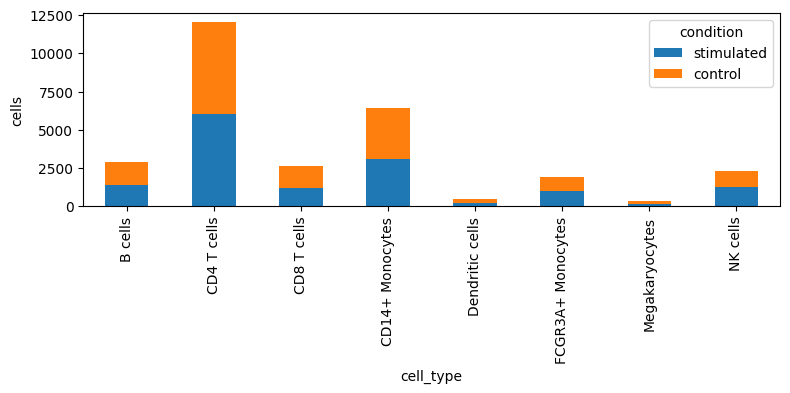

In [11]:
# Bar plot: cells per type × condition
count_df = (adata.obs.groupby(['cell_type','condition'], observed=True)['condition']
            .count().unstack().fillna(0))
count_df.plot.bar(stacked=True, figsize=(8,4))
plt.ylabel('cells'); plt.tight_layout(); plt.show()

## Highly Variable Gene Selection and UMAP Visualization

This section identifies 2,000 highly variable genes (HVGs) using Seurat's flavor and subsets the dataset to focus computational resources on biologically informative features. It then generates UMAP plots colored by condition and cell type, revealing perturbation effects and cell type separation in low-dimensional space.

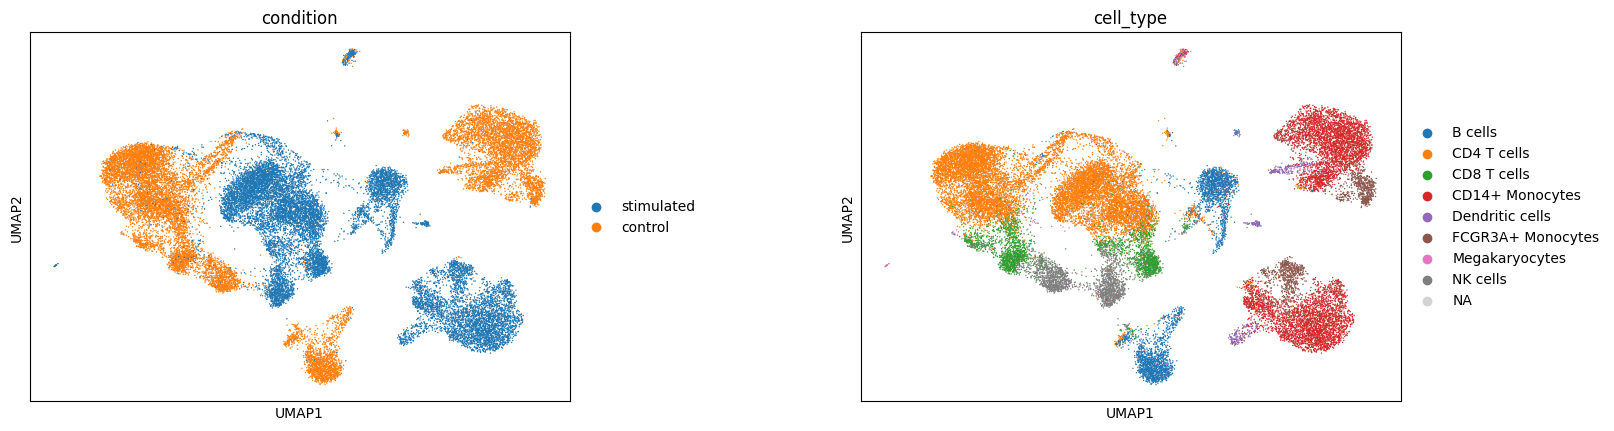

In [12]:
# HVG selection
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000, subset=True)
# UMAP colored by condition and cell type
sc.pl.umap(adata, color=['condition','cell_type'], wspace=0.4)

In [13]:
# Saving the Processed Dataset after HVG selection
adata.write("kang_final.h5ad")

## Final Data Cleaning and Categorical Encoding

This section performs final quality control by verifying condition distribution, removing any NaN cell types, and ensuring both cell_type and condition are properly encoded as pandas Categoricals. Categorical encoding optimizes memory usage and enables efficient groupby operations during leave-one-out benchmarking.

In [14]:
# Check conditions
print(f"\nCondition values: {adata.obs['condition'].unique()}")
print(f"Condition distribution:")
print(adata.obs['condition'].value_counts())

# Remove NaN values
adata = adata[adata.obs['cell_type'].notna()].copy()
print(f"After removing NaN cell types: {adata.shape}")

# Convert to categorical properly
adata.obs['cell_type'] = pd.Categorical(adata.obs['cell_type'])
print(f"Cell type categories: {adata.obs['cell_type'].cat.categories.tolist()}")

# Also make condition categorical
adata.obs['condition'] = pd.Categorical(adata.obs['condition'])
print(f"Condition categories: {adata.obs['condition'].cat.categories.tolist()}")


Condition values: ['control', 'stimulated']
Categories (2, object): ['stimulated', 'control']
Condition distribution:
condition
control       14619
stimulated    14446
Name: count, dtype: int64
After removing NaN cell types: (29056, 2000)
Cell type categories: ['B cells', 'CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'Dendritic cells', 'FCGR3A+ Monocytes', 'Megakaryocytes', 'NK cells']
Condition categories: ['stimulated', 'control']


## scGen Leave-One-Out Benchmarking Pipeline

This comprehensive section executes the core leave-one-out benchmarking strategy across all 8 cell types. For each cell type, it trains scGen excluding that type's stimulated cells, predicts their response, and stores results for metric evaluation. This tests scGen's ability to generalize perturbation effects across unseen cell types.

**Warning:** This cell takes 10-30 minutes depending on GPU availability. Monitor progress via printed updates.

**Pipeline breakdown:**

* **Leave-one-out logic:** For each cell type, trains on all data except its stimulated cells, then predicts those held-out cells.

* **scGen workflow:** setup_anndata() registers condition/cell_type, model.train() (10 epochs, early stopping), model.predict() generates predictions.

* **Evaluation prep:** Concatenates control/stimulated/predicted into eval_ad with PCA for downstream metrics.

**Error handling:** Continues processing other cell types if one fails.

In [15]:
# Check CUDA availability
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# Get all unique cell types in your dataset
all_cell_types = adata.obs['cell_type'].unique()
print(f"Found {len(all_cell_types)} cell types: {all_cell_types}")

# Dictionary to store results for each cell type
scgen_results = {}

# Loop through each cell type
for celltype_to_train in all_cell_types:
    print(f"\n{'='*50}")
    print(f"Processing cell type: {celltype_to_train}")
    print(f"{'='*50}")
    
    # Check if this cell type has stimulated cells to predict
    stimulated_cells = adata[(adata.obs['cell_type'] == celltype_to_train) & 
                           (adata.obs['condition'] == 'stimulated')]
    
    if len(stimulated_cells) == 0:
        print(f"No stimulated cells found for {celltype_to_train}. Skipping...")
        continue
    
    print(f"Found {len(stimulated_cells)} stimulated cells for {celltype_to_train}")
    
    try:
        # Create training set (excluding stimulated cells of current cell type)
        train_adata = adata[~(
            (adata.obs['cell_type'] == celltype_to_train) &
            (adata.obs['condition'] == 'stimulated')
        )].copy()
        
        print(f"Training set size: {train_adata.n_obs} cells")
        
        # Setup AnnData for scGen
        pt.tl.Scgen.setup_anndata(train_adata, batch_key='condition', labels_key='cell_type')
        
        # Initialize scGen model
        model = pt.tl.Scgen(train_adata)
        
        # Train the model
        print("Training scGen model...")
        model.train(max_epochs=100, batch_size=32,
                   early_stopping=True,
                   accelerator=('gpu' if cuda_available else 'cpu'),
                   devices=1)
        
        # Predict stimulated condition for current cell type
        print("Making predictions...")
        pred, *_ = model.predict(ctrl_key='control', stim_key='stimulated',
                               celltype_to_predict=celltype_to_train)
        
        # Set condition for predicted data
        pred.obs['condition'] = 'predicted'
        
        # Get control and stimulated data for current cell type
        ctrl = adata[(adata.obs['cell_type'] == celltype_to_train) & 
                    (adata.obs['condition'] == 'control')]
        stim = adata[(adata.obs['cell_type'] == celltype_to_train) & 
                    (adata.obs['condition'] == 'stimulated')]
        
        # Concatenate all data for evaluation
        eval_ad = anndata.concat([ctrl, stim, pred])
        eval_ad.obs_names_make_unique()
        
        # Perform PCA
        sc.tl.pca(eval_ad, n_comps=30, svd_solver='arpack')
        
        # Store results
        scgen_results[celltype_to_train] = {
            'eval_adata': eval_ad,
            'predictions': pred,
            'control': ctrl,
            'stimulated': stim,
            'model': model,
            'train_adata': train_adata
        }
        
        print(f" Successfully processed {celltype_to_train}")
        print(f"   - Control cells: {len(ctrl)}")
        print(f"   - Stimulated cells: {len(stim)}")
        print(f"   - Predicted cells: {len(pred)}")
        print(f"   - Total eval cells: {eval_ad.n_obs}")
        
        # Show condition counts
        print(f"   - Condition distribution:")
        for condition, count in eval_ad.obs['condition'].value_counts().items():
            print(f"     * {condition}: {count}")
        
    except Exception as e:
        print(f" Error processing {celltype_to_train}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n{'='*50}")
print(f"SUMMARY")
print(f"{'='*50}")
print(f"Successfully processed {len(scgen_results)} out of {len(all_cell_types)} cell types")
print(f"Processed cell types: {list(scgen_results.keys())}")

# Display summary for each processed cell type
if scgen_results:
    print(f"\nDetailed Summary:")
    for cell_type, result in scgen_results.items():
        eval_data = result['eval_adata']
        condition_counts = eval_data.obs['condition'].value_counts()
        print(f"\n{cell_type}:")
        print(f"  Total cells: {eval_data.n_obs}")
        for condition, count in condition_counts.items():
            print(f"  - {condition}: {count}")

print(f"\nResults stored in 'scgen_results' dictionary")
print("Access individual results using: scgen_results['cell_type_name']['eval_adata']")

# Optional: Create a summary DataFrame
import pandas as pd

summary_data = []
for cell_type, result in scgen_results.items():
    eval_data = result['eval_adata']
    condition_counts = eval_data.obs['condition'].value_counts()
    
    summary_data.append({
        'cell_type': cell_type,
        'total_cells': eval_data.n_obs,
        'control_cells': condition_counts.get('control', 0),
        'stimulated_cells': condition_counts.get('stimulated', 0),
        'predicted_cells': condition_counts.get('predicted', 0)
    })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    for col in ['total_cells', 'control_cells', 'stimulated_cells', 'predicted_cells']:
        summary_df[col] = summary_df[col].astype(int)
    print("\nSummary DataFrame:")
    print(tabulate(summary_df, headers='keys', tablefmt='pretty', showindex=False))

CUDA available: False
Found 8 cell types: ['CD4 T cells', 'CD14+ Monocytes', 'Dendritic cells', 'NK cells', 'CD8 T cells', 'B cells', 'Megakaryocytes', 'FCGR3A+ Monocytes']
Categories (8, object): ['B cells', 'CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'Dendritic cells', 'FCGR3A+ Monocytes', 'Megakaryocytes', 'NK cells']

Processing cell type: CD4 T cells
Found 6022 stimulated cells for CD4 T cells
Training set size: 23034 cells
Training scGen model...
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 573.255. Signaling Trainer to stop.
Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
 Successfully processed CD4 T cells
   - Control cells: 6005
   - Stimulated cells: 6022
   - Predicted cells: 6005
   - Total eval cells: 18032
   - Condition d

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 631.536. Signaling Trainer to stop.
Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
 Successfully processed CD14+ Monocytes
   - Control cells: 3365
   - Stimulated cells: 3093
   - Predicted cells: 3365
   - Total eval cells: 9823
   - Conditio

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 623.441. Signaling Trainer to stop.
Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
 Successfully processed Dendritic cells
   - Control cells: 227
   - Stimulated cells: 247
   - Predicted cells: 227
   - Total eval cells: 701
   - Condition di

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 611.174. Signaling Trainer to stop.
Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
 Successfully processed NK cells
   - Control cells: 1051
   - Stimulated cells: 1272
   - Predicted cells: 1051
   - Total eval cells: 3374
   - Condition distr

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 618.345. Signaling Trainer to stop.
Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
 Successfully processed CD8 T cells
   - Control cells: 1409
   - Stimulated cells: 1233
   - Predicted cells: 1409
   - Total eval cells: 4051
   - Condition di

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 625.733. Signaling Trainer to stop.
Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
 Successfully processed B cells
   - Control cells: 1488
   - Stimulated cells: 1387
   - Predicted cells: 1488
   - Total eval cells: 4363
   - Condition distri

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 632.291. Signaling Trainer to stop.
Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
 Successfully processed Megakaryocytes
   - Control cells: 166
   - Stimulated cells: 178
   - Predicted cells: 166
   - Total eval cells: 510
   - Condition dis

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 630.414. Signaling Trainer to stop.
Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
 Successfully processed FCGR3A+ Monocytes
   - Control cells: 906
   - Stimulated cells: 1007
   - Predicted cells: 906
   - Total eval cells: 2819
   - Conditio

## Saving Benchmarking Results
This section saves individual eval_adata objects for each cell type to separate .h5ad files, enabling independent analysis, sharing, and checkpointing of scGen predictions. Files preserve expression data, PCA embeddings, and metadata (control/stimulated/predicted conditions) for comprehensive downstream evaluation.

In [16]:
# Save all eval_adata files from the existing scgen_results dictionary
for cell_type, result_data in scgen_results.items():
    eval_ad = result_data['eval_adata']
    
    # Create safe filename
    safe_celltype = cell_type.replace(' ', '_').replace('+', '_plus_').replace('-', '_')
    filename = f"kang_final_{safe_celltype}_scGen_predictions.h5ad"
    
    print(f"Saving {cell_type} to {filename}")
    eval_ad.write(filename)

Saving CD4 T cells to kang_final_CD4_T_cells_scGen_predictions.h5ad
Saving CD14+ Monocytes to kang_final_CD14_plus__Monocytes_scGen_predictions.h5ad
Saving Dendritic cells to kang_final_Dendritic_cells_scGen_predictions.h5ad
Saving NK cells to kang_final_NK_cells_scGen_predictions.h5ad
Saving CD8 T cells to kang_final_CD8_T_cells_scGen_predictions.h5ad
Saving B cells to kang_final_B_cells_scGen_predictions.h5ad
Saving Megakaryocytes to kang_final_Megakaryocytes_scGen_predictions.h5ad
Saving FCGR3A+ Monocytes to kang_final_FCGR3A_plus__Monocytes_scGen_predictions.h5ad


## Comprehensive Evaluation Pipeline
This section defines helper functions and executes full evaluation across all 8 cell types using 6 metrics: bootstrap R², MSE, Pearson (gene means), energy distance (PCA space), mean-variance KDE (distribution shape), and Jaccard index (top-100 DEGs). Generates publication-ready figures and compiles results into summary tables.


scGen STANDARDIZED EVALUATION
Metrics:  R², Pearson, MSE, MMD, Energy, Wasserstein, Jaccard, Direction
Visualizations: Gene scatter, Energy heatmap, DEG bubble plot

STARTING COMPREHENSIVE scGen EVALUATION

 Found 8 prediction files:
  - kang_final_B_cells_scGen_predictions.h5ad
  - kang_final_CD14_plus__Monocytes_scGen_predictions.h5ad
  - kang_final_CD4_T_cells_scGen_predictions.h5ad
  - kang_final_CD8_T_cells_scGen_predictions.h5ad
  - kang_final_Dendritic_cells_scGen_predictions.h5ad
  - kang_final_FCGR3A_plus__Monocytes_scGen_predictions.h5ad
  - kang_final_Megakaryocytes_scGen_predictions.h5ad
  - kang_final_NK_cells_scGen_predictions.h5ad

 After removing duplicates: 8 files to process

 Figures will be saved to: figures/

 Loading:  kang_final_B_cells_scGen_predictions.h5ad
   Cell type: B cells

Evaluating: B cells
Loading data from: kang_final_B_cells_scGen_predictions.h5ad
Data shape: (4363, 2000)
Conditions:
  Control:       1488 cells
  Stimulated:  1387 cells
  Predicted

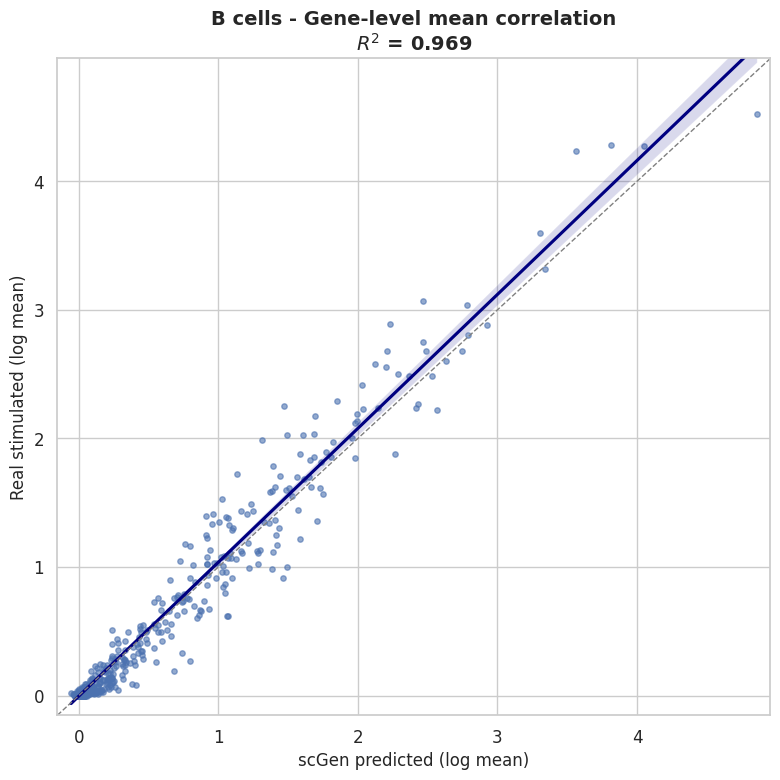

   Gene scatter plot saved


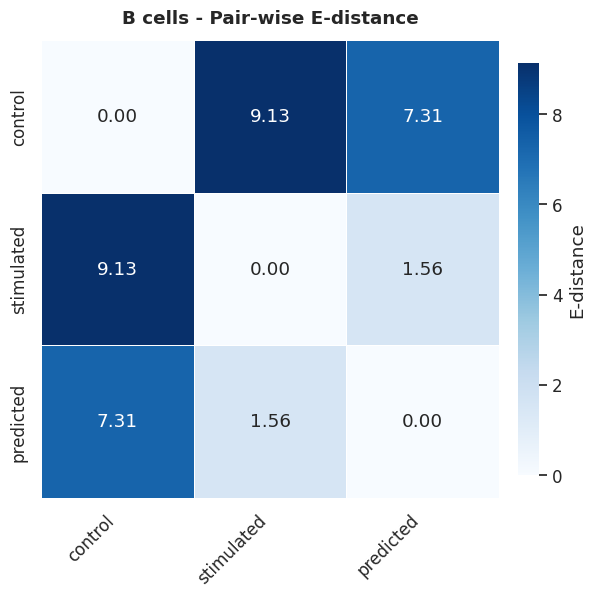

   Energy distance heatmap saved


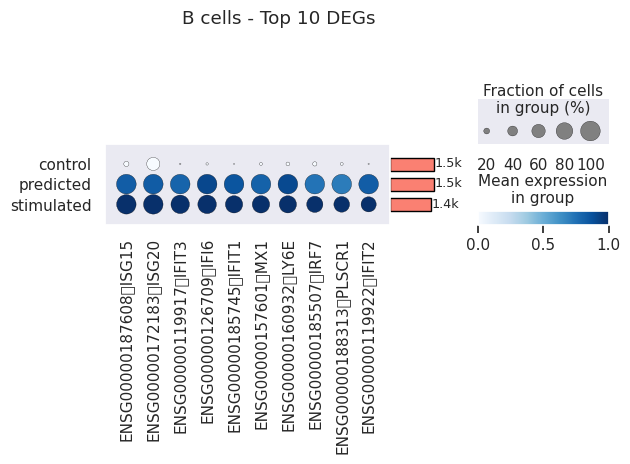

   DEG bubble plot saved

 RESULTS:
  R² = 0.969 ± 0.001
  Pearson = 0.985 ± 0.000
  MSE = 0.006724 ± 0.000138
  MMD = 0.0266 ± 0.0011
  Energy = 3.4593 ± 0.1155
  Wasserstein = 0.0969 ± 0.0004
  Jaccard (top-100) = 0.810
  Direction Accuracy = 0.432
  Gene-level R² = 0.969

 Saved:  scGen_metrics_B_cells_kang_final.tsv

 Loading:  kang_final_CD14_plus__Monocytes_scGen_predictions.h5ad
   Cell type: CD14+ Monocytes

Evaluating: CD14+ Monocytes
Loading data from: kang_final_CD14_plus__Monocytes_scGen_predictions.h5ad
Data shape: (9823, 2000)
Conditions:
  Control:       3365 cells
  Stimulated:  3093 cells
  Predicted:   3365 cells

 Computing metrics (5 bootstrap iterations)...

 Computing DEG analysis...
   DEG analysis complete

 Creating visualizations...


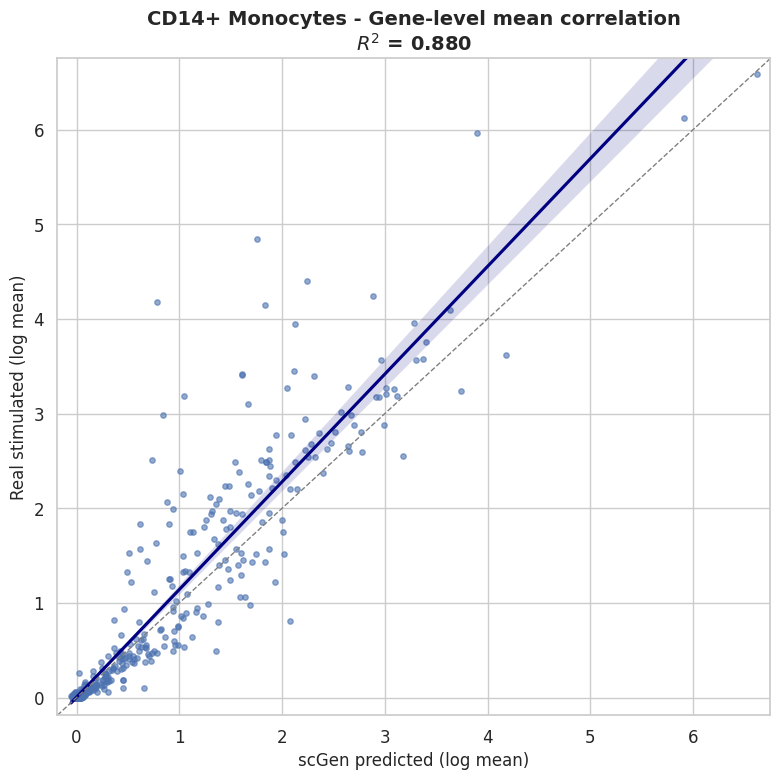

   Gene scatter plot saved


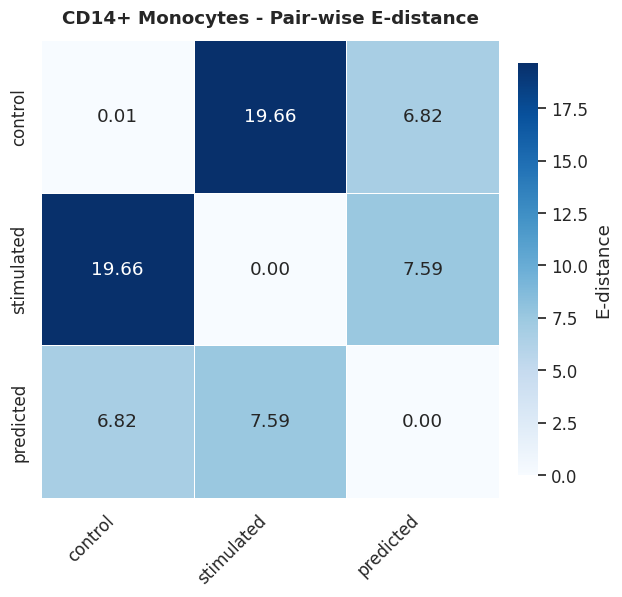

   Energy distance heatmap saved


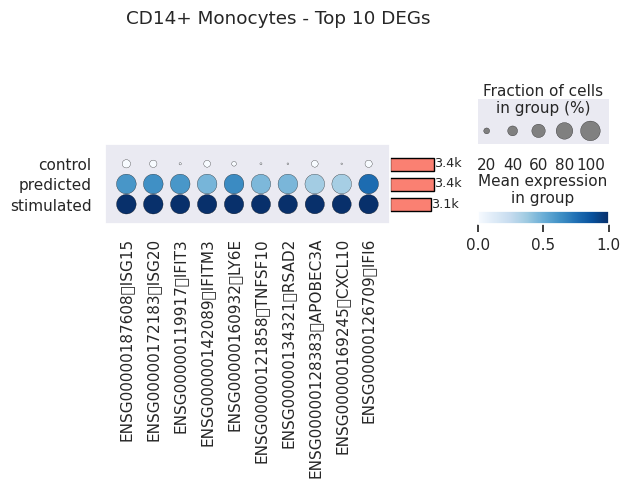

   DEG bubble plot saved

 RESULTS:
  R² = 0.880 ± 0.002
  Pearson = 0.946 ± 0.001
  MSE = 0.053335 ± 0.000749
  MMD = 0.0955 ± 0.0057
  Energy = 6.7890 ± 0.4120
  Wasserstein = 0.0934 ± 0.0002
  Jaccard (top-100) = 0.790
  Direction Accuracy = 0.391
  Gene-level R² = 0.880

 Saved:  scGen_metrics_CD14_plus__Monocytes_kang_final.tsv

 Loading:  kang_final_CD4_T_cells_scGen_predictions.h5ad
   Cell type: CD4 T cells

Evaluating: CD4 T cells
Loading data from: kang_final_CD4_T_cells_scGen_predictions.h5ad
Data shape: (18032, 2000)
Conditions:
  Control:       6005 cells
  Stimulated:  6022 cells
  Predicted:   6005 cells

 Computing metrics (5 bootstrap iterations)...

 Computing DEG analysis...
   DEG analysis complete

 Creating visualizations...


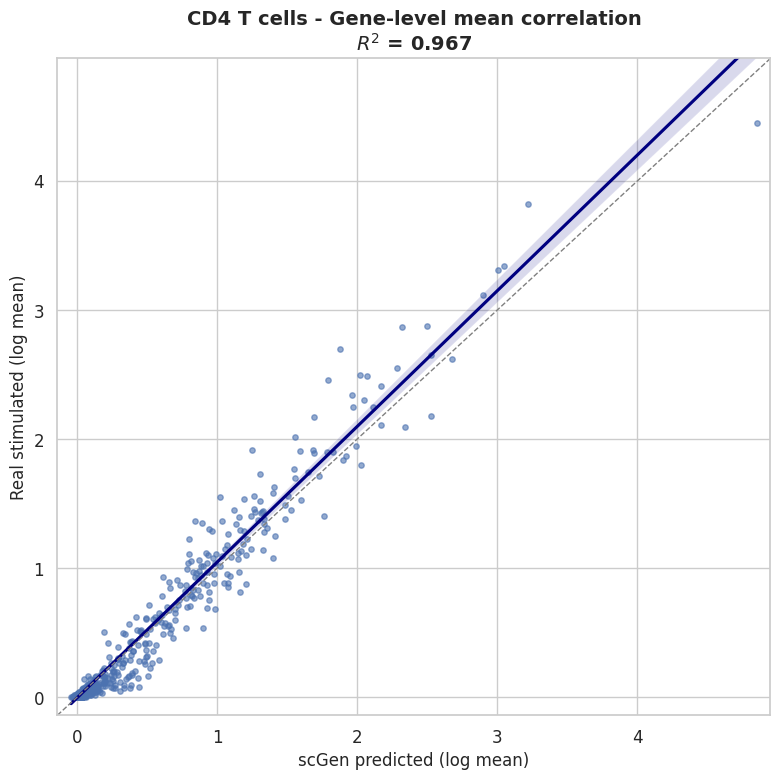

   Gene scatter plot saved


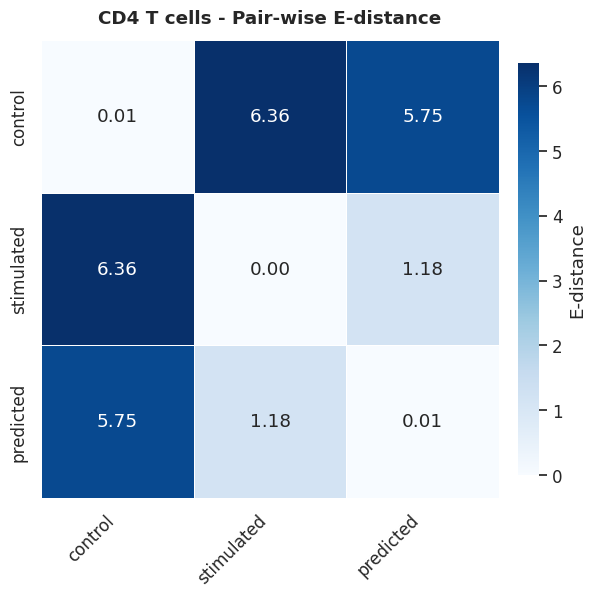

   Energy distance heatmap saved


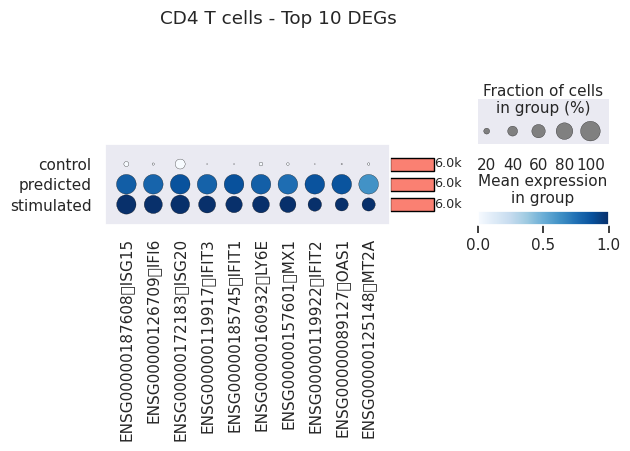

   DEG bubble plot saved

 RESULTS:
  R² = 0.967 ± 0.001
  Pearson = 0.984 ± 0.000
  MSE = 0.005813 ± 0.000129
  MMD = 0.0270 ± 0.0010
  Energy = 3.5159 ± 0.1195
  Wasserstein = 0.1016 ± 0.0001
  Jaccard (top-100) = 0.680
  Direction Accuracy = 0.553
  Gene-level R² = 0.967

 Saved:  scGen_metrics_CD4_T_cells_kang_final.tsv

 Loading:  kang_final_CD8_T_cells_scGen_predictions.h5ad
   Cell type: CD8 T cells

Evaluating: CD8 T cells
Loading data from: kang_final_CD8_T_cells_scGen_predictions.h5ad
Data shape: (4051, 2000)
Conditions:
  Control:       1409 cells
  Stimulated:  1233 cells
  Predicted:   1409 cells

 Computing metrics (5 bootstrap iterations)...

 Computing DEG analysis...
   DEG analysis complete

 Creating visualizations...


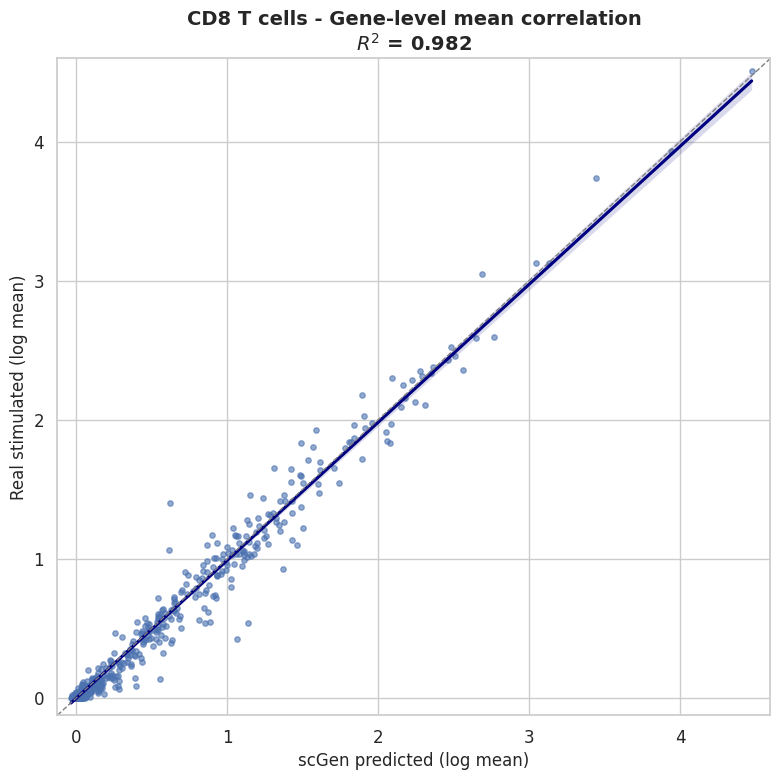

   Gene scatter plot saved


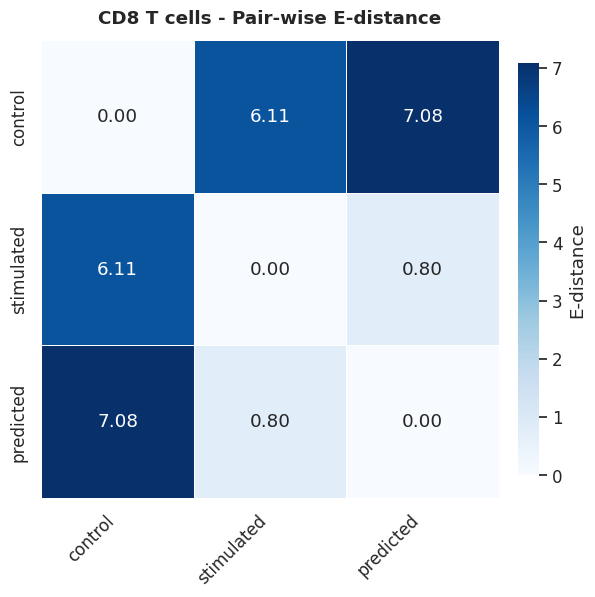

   Energy distance heatmap saved


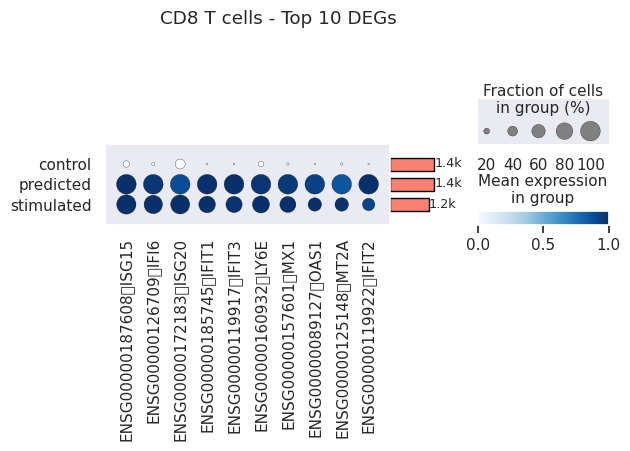

   DEG bubble plot saved

 RESULTS:
  R² = 0.981 ± 0.001
  Pearson = 0.990 ± 0.000
  MSE = 0.003504 ± 0.000119
  MMD = 0.0282 ± 0.0008
  Energy = 3.4648 ± 0.0763
  Wasserstein = 0.1113 ± 0.0003
  Jaccard (top-100) = 0.810
  Direction Accuracy = 0.462
  Gene-level R² = 0.982

 Saved:  scGen_metrics_CD8_T_cells_kang_final.tsv

 Loading:  kang_final_Dendritic_cells_scGen_predictions.h5ad
   Cell type: Dendritic cells

Evaluating: Dendritic cells
Loading data from: kang_final_Dendritic_cells_scGen_predictions.h5ad
Data shape: (701, 2000)
Conditions:
  Control:       227 cells
  Stimulated:  247 cells
  Predicted:   227 cells

 Computing metrics (5 bootstrap iterations)...

 Computing DEG analysis...
   DEG analysis complete

 Creating visualizations...


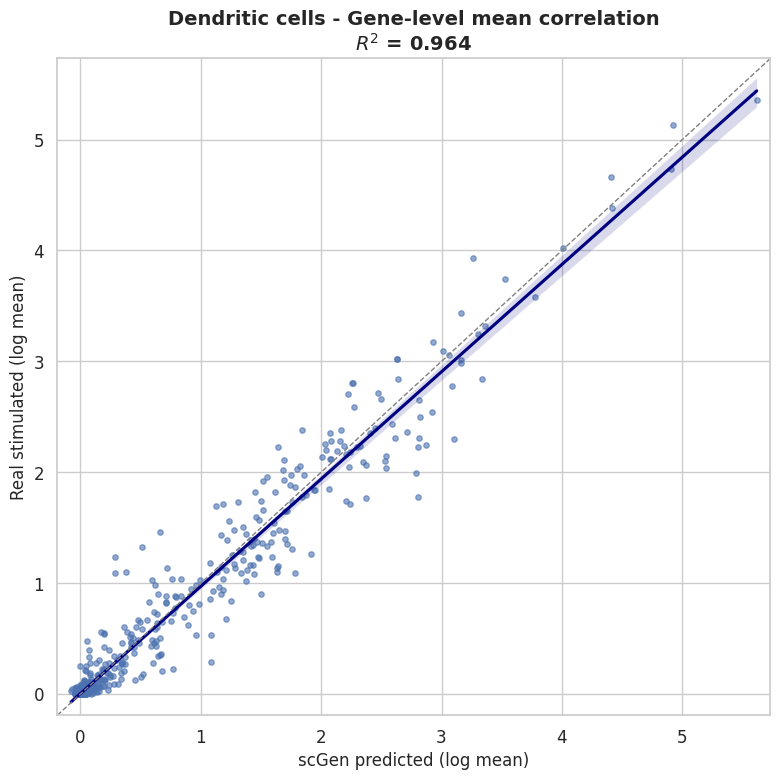

   Gene scatter plot saved


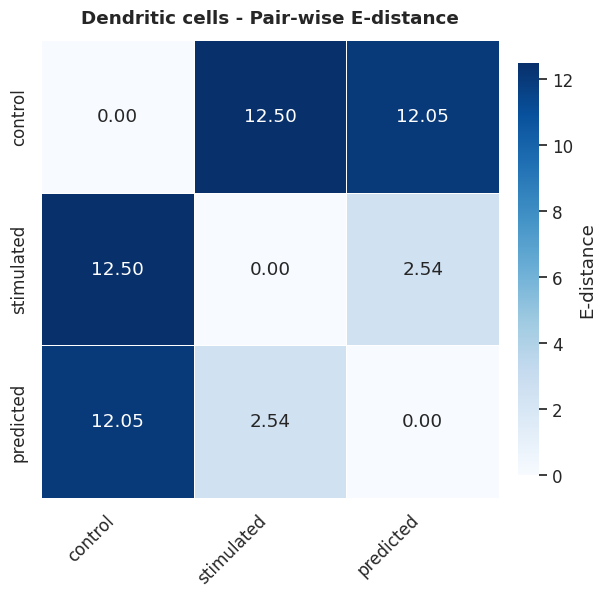

   Energy distance heatmap saved


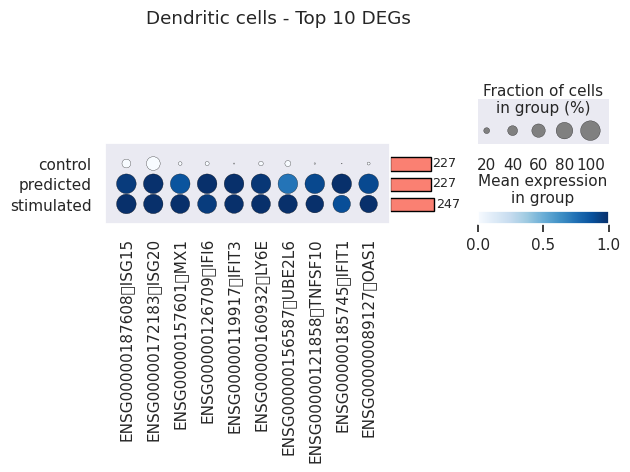

   DEG bubble plot saved

 RESULTS:
  R² = 0.958 ± 0.004
  Pearson = 0.980 ± 0.002
  MSE = 0.014379 ± 0.001444
  MMD = 0.0342 ± 0.0012
  Energy = 3.1950 ± 0.1076
  Wasserstein = 0.0863 ± 0.0007
  Jaccard (top-100) = 0.780
  Direction Accuracy = 0.261
  Gene-level R² = 0.964

 Saved:  scGen_metrics_Dendritic_cells_kang_final.tsv

 Loading:  kang_final_FCGR3A_plus__Monocytes_scGen_predictions.h5ad
   Cell type: FCGR3A+ Monocytes

Evaluating: FCGR3A+ Monocytes
Loading data from: kang_final_FCGR3A_plus__Monocytes_scGen_predictions.h5ad
Data shape: (2819, 2000)
Conditions:
  Control:       906 cells
  Stimulated:  1007 cells
  Predicted:   906 cells

 Computing metrics (5 bootstrap iterations)...

 Computing DEG analysis...
   DEG analysis complete

 Creating visualizations...


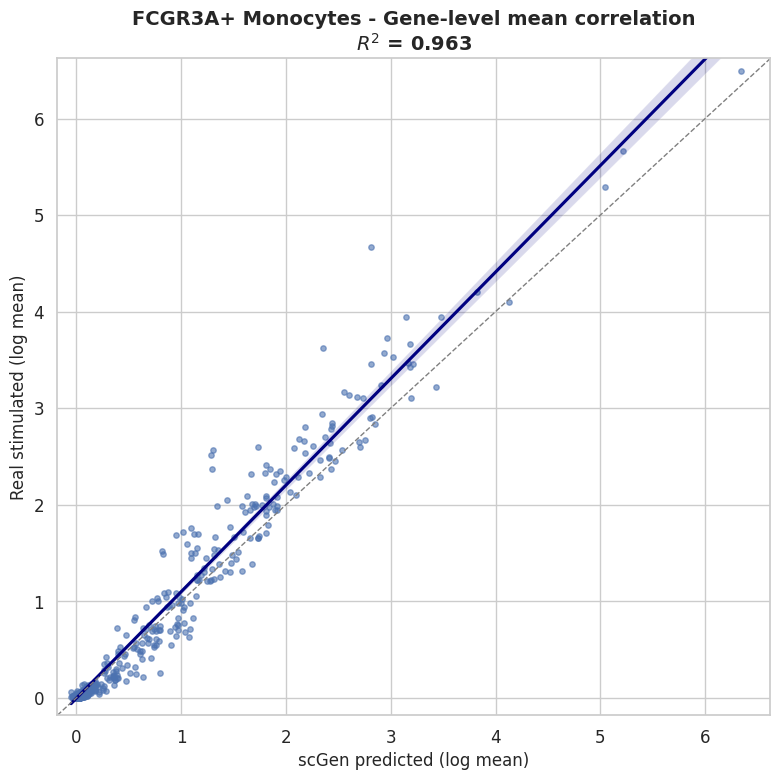

   Gene scatter plot saved


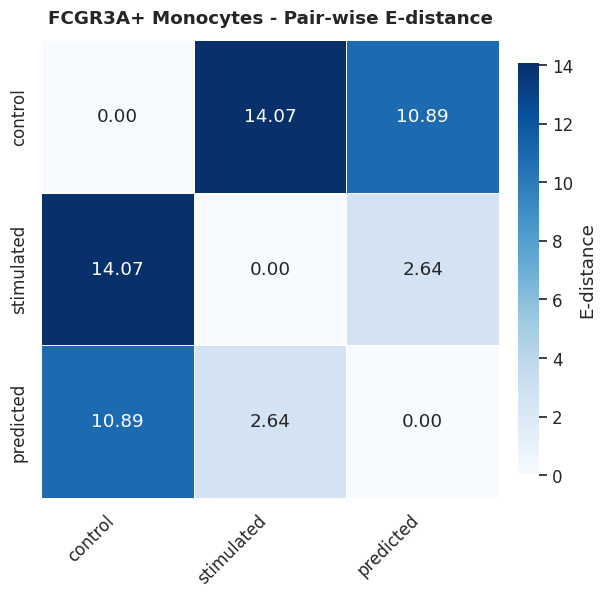

   Energy distance heatmap saved


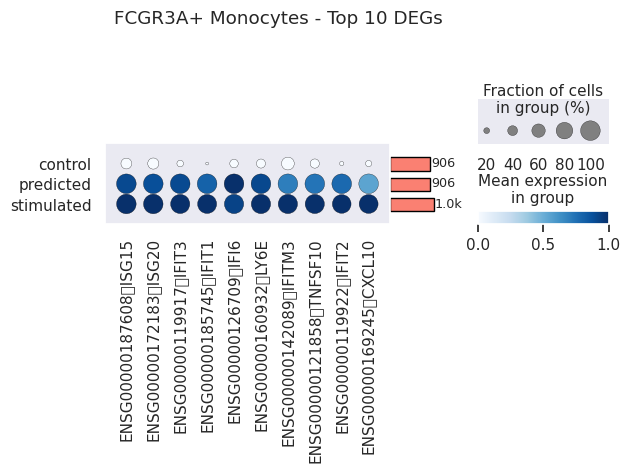

   DEG bubble plot saved

 RESULTS:
  R² = 0.961 ± 0.003
  Pearson = 0.985 ± 0.001
  MSE = 0.015741 ± 0.001388
  MMD = 0.0373 ± 0.0034
  Energy = 3.3033 ± 0.2325
  Wasserstein = 0.0837 ± 0.0007
  Jaccard (top-100) = 0.810
  Direction Accuracy = 0.323
  Gene-level R² = 0.963

 Saved:  scGen_metrics_FCGR3A_plus__Monocytes_kang_final.tsv

 Loading:  kang_final_Megakaryocytes_scGen_predictions.h5ad
   Cell type: Megakaryocytes

Evaluating: Megakaryocytes
Loading data from: kang_final_Megakaryocytes_scGen_predictions.h5ad
Data shape: (510, 2000)
Conditions:
  Control:       166 cells
  Stimulated:  178 cells
  Predicted:   166 cells

 Computing metrics (5 bootstrap iterations)...

 Computing DEG analysis...
   DEG analysis complete

 Creating visualizations...


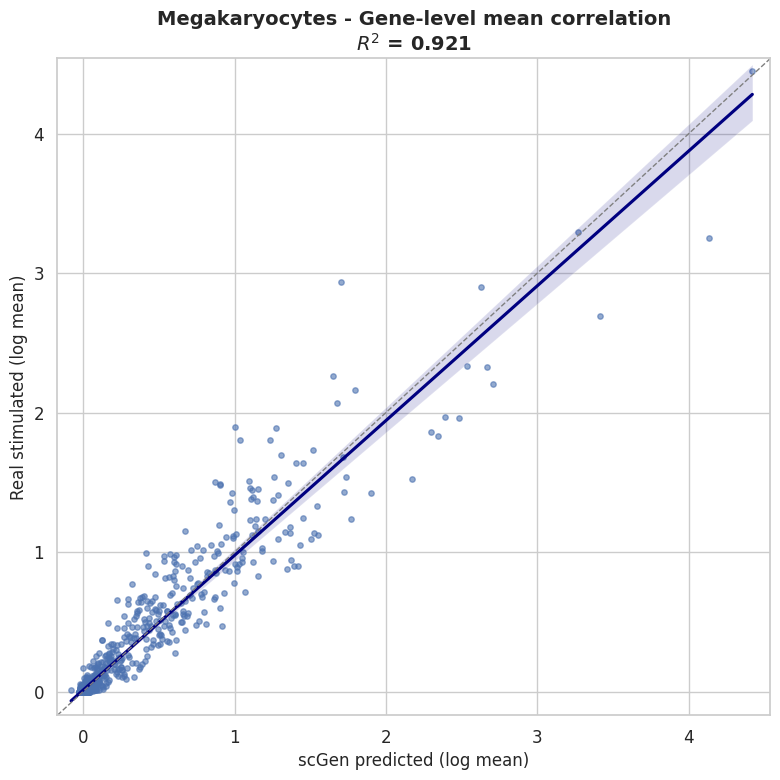

   Gene scatter plot saved


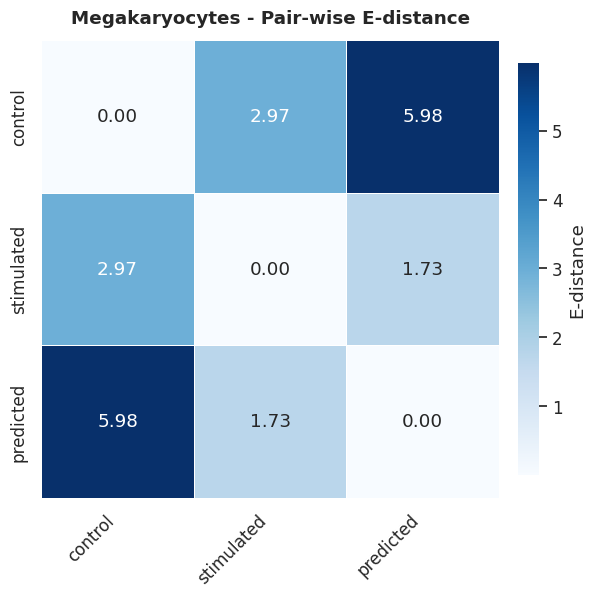

   Energy distance heatmap saved


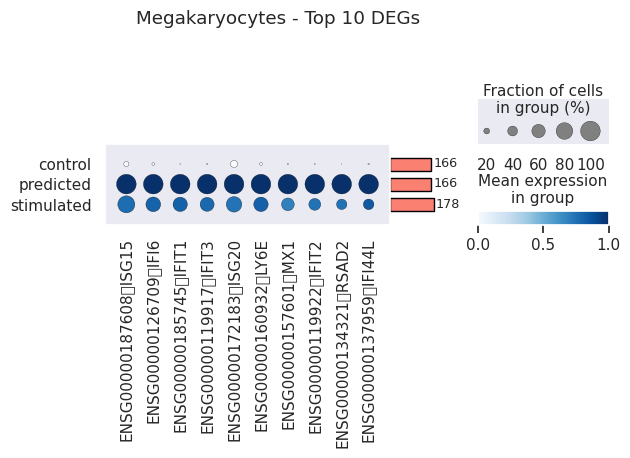

   DEG bubble plot saved

 RESULTS:
  R² = 0.889 ± 0.038
  Pearson = 0.945 ± 0.020
  MSE = 0.014439 ± 0.004539
  MMD = 0.0322 ± 0.0053
  Energy = 2.6501 ± 0.3776
  Wasserstein = 0.0985 ± 0.0023
  Jaccard (top-100) = 0.680
  Direction Accuracy = 0.282
  Gene-level R² = 0.921

 Saved:  scGen_metrics_Megakaryocytes_kang_final.tsv

 Loading:  kang_final_NK_cells_scGen_predictions.h5ad
   Cell type: NK cells

Evaluating: NK cells
Loading data from: kang_final_NK_cells_scGen_predictions.h5ad
Data shape: (3374, 2000)
Conditions:
  Control:       1051 cells
  Stimulated:  1272 cells
  Predicted:   1051 cells

 Computing metrics (5 bootstrap iterations)...

 Computing DEG analysis...
   DEG analysis complete

 Creating visualizations...


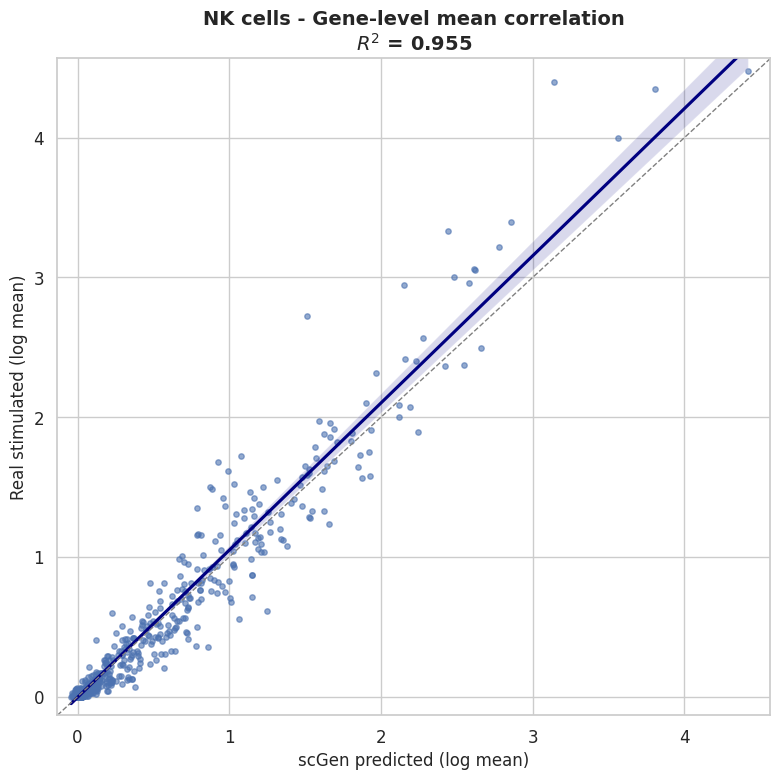

   Gene scatter plot saved


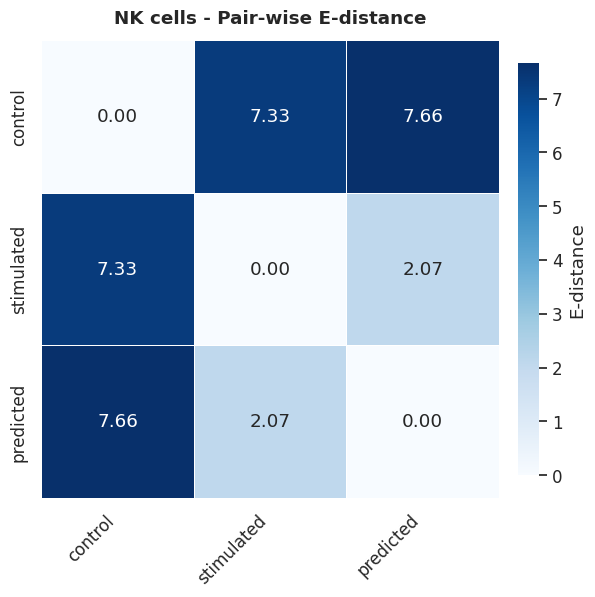

   Energy distance heatmap saved


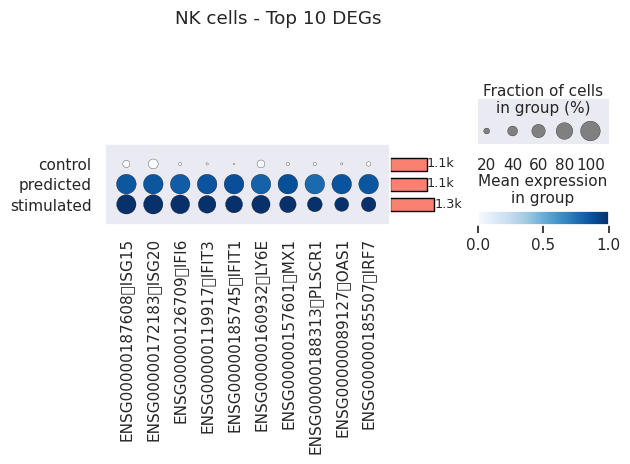

   DEG bubble plot saved

 RESULTS:
  R² = 0.954 ± 0.003
  Pearson = 0.978 ± 0.001
  MSE = 0.009239 ± 0.000594
  MMD = 0.0419 ± 0.0016
  Energy = 4.7498 ± 0.1004
  Wasserstein = 0.1230 ± 0.0006
  Jaccard (top-100) = 0.690
  Direction Accuracy = 0.465
  Gene-level R² = 0.955

 Saved:  scGen_metrics_NK_cells_kang_final.tsv

FINAL COMBINED RESULTS

 Saved:  scGen_all_cell_types_evaluation_results.csv
 Saved: scGen_all_cell_types_evaluation_results.tsv

SUMMARY TABLE (STANDARDIZED METRICS)
+-------------------+---------+--------------+----------+----------------+--------------------+
|     cell_type     | R2_mean | Pearson_mean | MMD_mean | Jaccard_top100 | Direction_Accuracy |
+-------------------+---------+--------------+----------+----------------+--------------------+
|      B cells      |  0.969  |    0.985     |  0.027   |     0.810      |       0.432        |
|  CD14+ Monocytes  |  0.880  |    0.946     |  0.096   |     0.790      |       0.391        |
|    CD4 T cells    |  0.967 

In [22]:
# Helper functions
def get_array(X):
    """Convert to dense numpy array"""
    if issparse(X):
        return X.toarray()
    return np.array(X)


def compute_mmd_rbf(X, Y, gamma=None):
    """
    Maximum Mean Discrepancy with RBF kernel
    """
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    
    # Subsample for efficiency
    if len(X) > 500:
        idx_x = np.random.choice(len(X), 500, replace=False)
        idx_y = np.random.choice(len(Y), 500, replace=False)
        X = X[idx_x]
        Y = Y[idx_y]
    
    XX = np.exp(-gamma * cdist(X, X, 'sqeuclidean'))
    YY = np.exp(-gamma * cdist(Y, Y, 'sqeuclidean'))
    XY = np.exp(-gamma * cdist(X, Y, 'sqeuclidean'))
    
    return XX. mean() + YY.mean() - 2 * XY. mean()


def compute_energy_distance(X, Y):
    """
    Energy distance between distributions (expression space)
    """
    if len(X) > 500:
        idx_x = np.random.choice(len(X), 500, replace=False)
        idx_y = np. random.choice(len(Y), 500, replace=False)
        X = X[idx_x]
        Y = Y[idx_y]
    
    return 2 * np.mean(cdist(X, Y)) - np.mean(pdist(X)) - np.mean(pdist(Y))


def energy_d(X1, X2, max_cells=2_000, seed=SEED):
    """
    Multivariate Energy distance E_d(X,Y)=2·E‖X−Y‖−E‖X−X'‖−E‖Y−Y'‖
    For PCA space (used in heatmap visualization)
    """
    rng = np.random.default_rng(seed)
    # dense float64
    X1 = X1.toarray() if issparse(X1) else np.asarray(X1, dtype=np.float64)
    X2 = X2.toarray() if issparse(X2) else np.asarray(X2, dtype=np.float64)
    # subsample rows if needed
    if X1.shape[0] > max_cells:
        X1 = X1[rng.choice(X1.shape[0], max_cells, replace=False)]
    if X2.shape[0] > max_cells:
        X2 = X2[rng.choice(X2.shape[0], max_cells, replace=False)]
    # pair-wise Euclidean distances
    xy = pairwise_distances(X1, X2, metric="euclidean").mean()
    xx = pairwise_distances(X1, metric="euclidean").mean()
    yy = pairwise_distances(X2, metric="euclidean").mean()
    return 2*xy - xx - yy


def compute_deg_metrics(X_true, X_pred, X_ctrl, top_k=100):
    """
    DEG-related metrics:    Jaccard and Direction Accuracy
    """
    mean_true = X_true.mean(axis=0)
    mean_ctrl = X_ctrl.mean(axis=0)
    delta_true = mean_true - mean_ctrl
    
    mean_pred = X_pred.mean(axis=0)
    delta_pred = mean_pred - mean_ctrl
    
    # Top-k overlap (Jaccard index)
    top_k_actual = min(top_k, len(delta_true))
    top_k_true = np.argsort(np.abs(delta_true))[-top_k_actual:]
    top_k_pred = np.argsort(np. abs(delta_pred))[-top_k_actual:]
    jaccard = len(np.intersect1d(top_k_true, top_k_pred)) / top_k_actual
    
    # Direction accuracy
    direction_correct = (np.sign(delta_true) == np.sign(delta_pred)).mean()
    
    return {
        'Jaccard_top100': jaccard,
        'Direction_Accuracy': direction_correct
    }


# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def create_gene_scatter_plot(eval_ad, cell_type, output_dir="figures", show_plot=True):
    """
    Create gene-level mean correlation scatter plot
    """
    try:
        # Convert data to dense array if sparse
        X = get_array(eval_ad.X)
        
        # Create condition masks
        ctrl_m = eval_ad.obs['condition'] == 'control'
        stim_m = eval_ad. obs['condition'] == 'stimulated'
        pred_m = eval_ad.obs['condition'] == 'predicted'
        
        # Per-gene means and R²
        stim_means = X[stim_m].mean(axis=0)        # ground-truth
        pred_means = X[pred_m]. mean(axis=0)        # scGen estimate
        r2 = r2_score(stim_means, pred_means)
        
        # Create DataFrame with gene names
        df = pd.DataFrame(
            {"pred":  pred_means,
             "real": stim_means},
            index=eval_ad. var_names
        )
        
        # Create scatter plot
        sns.set_style("whitegrid")
        plt.figure(figsize=(8, 8))
        ax = sns.regplot(
            data=df,
            x="pred",
            y="real",
            scatter_kws=dict(s=15, alpha=0.6),
            line_kws=dict(color="navy"),
            ci=95
        )
        
        # Reference diagonal
        data_min = min(df. min())
        data_max = max(df.max())
        pad = 0.02 * (data_max - data_min)
        lims = [data_min - pad, data_max + pad]
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.plot(lims, lims, "--", color="grey", linewidth=1)
        
        # Labels and title
        ax.set_xlabel("scGen predicted (log mean)", fontsize=12)
        ax.set_ylabel("Real stimulated (log mean)", fontsize=12)
        ax.set_title(f"{cell_type} - Gene-level mean correlation\n$R^2$ = {r2:.3f}", 
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        # Save figure
        os.makedirs(output_dir, exist_ok=True)
        safe_name = cell_type.replace(' ', '_').replace('+', '_plus_')
        filepath = f"{output_dir}/{safe_name}_gene_correlation.png"
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        
        # Display if requested
        if show_plot: 
            plt.show()
        else:
            plt.close()
        
        print(f"   Gene scatter plot saved")
        return r2
        
    except Exception as e:
        print(f"   Could not create gene scatter plot: {e}")
        return np.nan


def create_energy_distance_heatmap(eval_ad, cell_type, output_dir="figures", show_plot=True):
    """
    Create energy distance heatmap
    """
    try:
        # Get PCA coordinates
        if "X_pca" not in eval_ad.obsm:
            print("   No PCA found, computing...")
            sc.pp.pca(eval_ad, n_comps=50)
        
        Xp = eval_ad.obsm["X_pca"]
        
        # Create condition masks
        ctrl_m = eval_ad.obs['condition'] == 'control'
        stim_m = eval_ad.obs['condition'] == 'stimulated'
        pred_m = eval_ad.obs['condition'] == 'predicted'
        
        # Sample stimulated cells if too many
        stim_indices = np.where(stim_m)[0]
        n_stim_sample = min(2000, len(stim_indices))
        stim_ids = np.random.default_rng(SEED).choice(stim_indices, n_stim_sample, replace=False)
        Xp_stim_sub = Xp[stim_ids]
        
        # Create group representations
        group_repr = {
            "control":  Xp[ctrl_m],
            "stimulated": Xp_stim_sub,
            "predicted": Xp[pred_m],
        }
        
        groups = ["control", "stimulated", "predicted"]
        E_df = pd.DataFrame(index=groups, columns=groups, dtype=float)
        
        for i, g1 in enumerate(groups):
            X1 = group_repr[g1]
            for g2 in groups[i: ]:
                X2 = group_repr[g2]
                ed = energy_d(X1, X2)
                E_df.loc[g1, g2] = E_df.loc[g2, g1] = ed
        
        # Create heatmap
        sns.set(font_scale=1.1)
        plt.figure(figsize=(7, 6))
        ax = sns.heatmap(
            E_df.astype(float), annot=True, fmt=".2f", cmap="Blues",
            linewidths=0.7, square=True,
            cbar_kws=dict(label="E-distance", shrink=0.9, pad=0.03)
        )
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_ylabel("")
        ax.set_title(f"{cell_type} - Pair-wise E-distance", pad=12, fontweight='bold')
        plt.tight_layout()
        
        # Save figure
        os.makedirs(output_dir, exist_ok=True)
        safe_name = cell_type.replace(' ', '_').replace('+', '_plus_')
        filepath = f"{output_dir}/{safe_name}_energy_distance.png"
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        
        # Display if requested
        if show_plot:
            plt.show()
        else:
            plt.close()
        
        print(f"   Energy distance heatmap saved")
        return E_df
        
    except Exception as e:
        print(f"   Could not create energy heatmap: {e}")
        return None


def create_deg_bubble_plot_from_results(eval_ad, cell_type, output_dir="figures", n_genes=10, show_plot=True):
    """
    Create DEG bubble plot using EXISTING rank_genes_groups results
    (avoids recomputing DEG analysis)
    """
    try:
        # Check if DEG results exist
        if "rank_genes_groups" not in eval_ad.uns:
            print(f"   No DEG results found, skipping bubble plot")
            return []
        
        # Get top genes from existing results
        top_genes_all = eval_ad.uns["rank_genes_groups"]["names"]["stimulated"]
        top_genes = top_genes_all[:n_genes]
        
        # IMPORTANT: Set interactive mode based on show_plot
        if show_plot:
            plt. ion()  # Interactive mode ON (will display)
        else:
            plt.ioff()  # Interactive mode OFF (won't display)
        
        # Create bubble plot
        dp = sc.pl.DotPlot(
            eval_ad,
            var_names=top_genes,
            groupby="condition",
            standard_scale="var",
            cmap="Blues",
            title=f"{cell_type} - Top {n_genes} DEGs",
        )
        dp.add_totals().legend(width=2)
        
        # Save figure
        os.makedirs(output_dir, exist_ok=True)
        safe_name = cell_type.replace(' ', '_').replace('+', '_plus_')
        filepath = f"{output_dir}/{safe_name}_deg_bubble.png"
        dp. savefig(filepath, dpi=300)
        
        # Manually show if requested
        if show_plot: 
            plt.show()
        
        # Always close to prevent memory leaks
        plt.close('all')
        
        print(f"   DEG bubble plot saved")
        return list(top_genes)
        
    except Exception as e:
        print(f"   Could not create DEG bubble plot: {e}")
        import traceback
        traceback.print_exc()
        plt.close('all')
        return []


# ============================================================================
# MAIN EVALUATION FUNCTION
# ============================================================================

def evaluate_single_cell_type(file_path, cell_type, output_dir="figures", show_plots=True):
    """
    Complete evaluation for a single cell type
    """
    print(f"\n{'='*80}")
    print(f"Evaluating: {cell_type}")
    print(f"{'='*80}")
    
    try:
        # Load evaluation data
        print(f"Loading data from: {file_path}")
        eval_ad = sc.read_h5ad(file_path)
        
        # Convert data to dense array if sparse
        X = get_array(eval_ad. X)
        
        # Create condition masks
        ctrl_m = eval_ad.obs['condition'] == 'control'
        stim_m = eval_ad. obs['condition'] == 'stimulated'
        pred_m = eval_ad.obs['condition'] == 'predicted'
        
        print(f"Data shape: {eval_ad.shape}")
        print(f"Conditions:")
        print(f"  Control:       {ctrl_m.sum()} cells")
        print(f"  Stimulated:  {stim_m.sum()} cells")
        print(f"  Predicted:   {pred_m.sum()} cells")
        
        # Check if we have enough data
        if stim_m.sum() < 10 or pred_m.sum() < 10:
            print(f" Insufficient data for evaluation")
            return None
        
        # Extract subsets
        X_ctrl = X[ctrl_m]
        X_true = X[stim_m]
        X_pred = X[pred_m]
        
        # ====================================================================
        # BOOTSTRAP METRICS
        # ====================================================================
        
        print(f"\n Computing metrics (5 bootstrap iterations)...")
        
        n_bootstrap = 5
        metrics_list = []
        
        for i in range(n_bootstrap):
            n_cells = min(len(X_true), len(X_pred))
            idx = np.random.choice(n_cells, n_cells, replace=True)
            
            X_t = X_true[idx]
            X_p = X_pred[idx]
            
            # Mean-level metrics
            mean_true = X_t.mean(axis=0)
            mean_pred = X_p.mean(axis=0)
            
            r2 = r2_score(mean_true, mean_pred)
            pearson, _ = pearsonr(mean_true, mean_pred)
            mse = np.mean((mean_true - mean_pred) ** 2)
            
            # Distribution metrics
            n_sample = min(150, len(X_t), len(X_p))
            idx_sample = np.random.choice(len(X_t), n_sample, replace=False)
            
            # MMD
            mmd = compute_mmd_rbf(X_t[idx_sample], X_p[idx_sample])
            
            # Energy distance
            energy = compute_energy_distance(X_t[idx_sample], X_p[idx_sample])
            
            # Wasserstein distance (per-gene average)
            wass_list = []
            for g in range(X_t.shape[1]):
                try:
                    wass_list.append(wasserstein_distance(X_t[:, g], X_p[: , g]))
                except: 
                    wass_list.append(np.mean(np.abs(X_t[:, g] - X_p[:, g])))
            wass_mean = np.mean(wass_list)
            
            metrics_list.append({
                'R2': r2,
                'Pearson': pearson,
                'MSE': mse,
                'MMD': mmd,
                'Energy_Distance': energy,
                'Wasserstein':  wass_mean
            })
        
        # Aggregate bootstrap results
        metrics_df = pd.DataFrame(metrics_list)
        
        # ====================================================================
        # DEG METRICS
        # ====================================================================
        
        print(f"\n Computing DEG analysis...")
        
        # Compute DEG using scanpy (for BOTH metrics AND visualization)
        try:
            sc.tl.rank_genes_groups(
                eval_ad,
                groupby="condition",
                reference="control",
                groups=["stimulated", "predicted"],  # Both groups for metrics
                n_genes=min(100, eval_ad.n_vars),
                method="wilcoxon"
            )
            
            print(f"   DEG analysis complete")
            
        except Exception as e:
            print(f"   Could not compute DEG with scanpy: {e}")
        
        # Compute Jaccard and Direction using mean-based method
        deg_metrics = compute_deg_metrics(X_true, X_pred, X_ctrl, top_k=100)
        
        # ====================================================================
        # CREATE VISUALIZATIONS (REUSE DEG RESULTS - NO DUPLICATE)
        # ====================================================================
        
        print(f"\n Creating visualizations...")
        
        # 1. Gene scatter plot
        gene_r2 = create_gene_scatter_plot(eval_ad, cell_type, output_dir, show_plot=show_plots)
        
        # 2. Energy distance heatmap
        energy_df = create_energy_distance_heatmap(eval_ad, cell_type, output_dir, show_plot=show_plots)
        
        # 3. DEG bubble plot (reuses existing rank_genes_groups results - NO DUPLICATE)
        top_genes = create_deg_bubble_plot_from_results(eval_ad, cell_type, output_dir, n_genes=10, show_plot=show_plots)
        
        # ====================================================================
        # COMPILE RESULTS
        # ====================================================================
        
        result = {
            # Identification
            'cell_type': cell_type,
            'gene_set': 'default',
            'n_cells_stim': stim_m.sum(),
            'n_cells_pred': pred_m.sum(),
            'n_cells_ctrl': ctrl_m.sum(),
            
            # STANDARDIZED METRICS (matching Mean Delta/CellOT)
            'R2_mean': metrics_df['R2']. mean(),
            'R2_std': metrics_df['R2'].std(),
            'Pearson_mean': metrics_df['Pearson'].mean(),
            'Pearson_std': metrics_df['Pearson'].std(),
            'MSE_mean': metrics_df['MSE']. mean(),
            'MSE_std': metrics_df['MSE'].std(),
            'MMD_mean': metrics_df['MMD'].mean(),
            'MMD_std': metrics_df['MMD'].std(),
            'Energy_mean': metrics_df['Energy_Distance'].mean(),
            'Energy_std': metrics_df['Energy_Distance'].std(),
            'Wasserstein_mean': metrics_df['Wasserstein'].mean(),
            'Wasserstein_std': metrics_df['Wasserstein'].std(),
            'Jaccard_top100': deg_metrics['Jaccard_top100'],
            'Direction_Accuracy': deg_metrics['Direction_Accuracy'],
            'gene_level_r2': gene_r2,
        }
        
        # Print results
        print(f"\n RESULTS:")
        print(f"  R² = {result['R2_mean']:.3f} ± {result['R2_std']:.3f}")
        print(f"  Pearson = {result['Pearson_mean']:.3f} ± {result['Pearson_std']:.3f}")
        print(f"  MSE = {result['MSE_mean']:.6f} ± {result['MSE_std']:.6f}")
        print(f"  MMD = {result['MMD_mean']:.4f} ± {result['MMD_std']:.4f}")
        print(f"  Energy = {result['Energy_mean']:.4f} ± {result['Energy_std']:.4f}")
        print(f"  Wasserstein = {result['Wasserstein_mean']:.4f} ± {result['Wasserstein_std']:.4f}")
        print(f"  Jaccard (top-100) = {result['Jaccard_top100']:.3f}")
        print(f"  Direction Accuracy = {result['Direction_Accuracy']:.3f}")
        print(f"  Gene-level R² = {result['gene_level_r2']:.3f}")
        
        # Save individual result
        safe_name = cell_type.replace(' ', '_').replace('+', '_plus_')
        result_df = pd.DataFrame([result])
        result_df.to_csv(f"scGen_metrics_{safe_name}_kang_final.tsv", sep='\t', index=False)
        print(f"\n Saved:  scGen_metrics_{safe_name}_kang_final.tsv")
        
        return result
        
    except Exception as e:
        print(f"\n Error evaluating {cell_type}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


# ============================================================================
# MAIN EVALUATION SCRIPT
# ============================================================================

def main_evaluation(show_plots=True):
    """
    Main function to evaluate all cell types
    
    Parameters: 
    -----------
    show_plots : bool
        Whether to display plots (True) or only save them (False)
    """
    print("\n" + "="*80)
    print("STARTING COMPREHENSIVE scGen EVALUATION")
    print("="*80)
    
    # Find all scGen prediction files
    prediction_files = glob.glob("kang_final_*_scGen_predictions.h5ad")
    
    if not prediction_files:
        print("\n No scGen prediction files found!")
        print("Expected files like: kang_final_*_scGen_predictions.h5ad")
        print("Current directory files:")
        for f in sorted(os.listdir(".")):
            if f.endswith(".h5ad"):
                print(f"  - {f}")
        return None
    
    print(f"\n Found {len(prediction_files)} prediction files:")
    for f in sorted(prediction_files):
        print(f"  - {f}")
    
    # Check for duplicates and remove them
    cell_types_seen = set()
    filtered_files = []
    
    for file_path in sorted(prediction_files):
        base_name = os.path.basename(file_path)
        cell_type = base_name.replace("kang_final_", "").replace("_scGen_predictions.h5ad", "")
        cell_type = cell_type.replace("_", " ").replace(" plus ", "+")
        
        # Handle specific cases
        if cell_type == "CD4": 
            cell_type = "CD4 T cells"
        elif cell_type == "CD8":
            cell_type = "CD8 T cells"
        elif cell_type == "CD14" or cell_type == "CD14 Monocytes":
            cell_type = "CD14+ Monocytes"
        elif cell_type == "NK":
            cell_type = "NK cells"
        elif cell_type == "B":
            cell_type = "B cells"
        
        if cell_type not in cell_types_seen:
            cell_types_seen.add(cell_type)
            filtered_files.append((file_path, cell_type))
        else:
            print(f"   Skipping duplicate: {file_path}")
    
    prediction_files = filtered_files
    print(f"\n After removing duplicates: {len(prediction_files)} files to process")
    
    # Create output directories
    output_dir = "figures"
    os.makedirs(output_dir, exist_ok=True)
    print(f"\n Figures will be saved to: {output_dir}/")
    
    # Store all results
    all_results = []
    
    # Process each file
    for file_path, cell_type in sorted(prediction_files, key=lambda x: x[1]):
        print(f"\n Loading:  {file_path}")
        print(f"   Cell type: {cell_type}")
        
        try:
            # Load evaluation data
            eval_ad = sc.read_h5ad(file_path)
            
            # Evaluate with standardized metrics + visualizations
            result = evaluate_single_cell_type(
                file_path, 
                cell_type, 
                output_dir=output_dir,
                show_plots=show_plots
            )
            
            if result: 
                all_results.append(result)
                
        except Exception as e:
            print(f"\n Error loading {file_path}: {e}")
            continue
    
    # ========================================================================
    # SAVE COMBINED RESULTS
    # ========================================================================
    
    if all_results:
        print(f"\n{'='*80}")
        print(f"FINAL COMBINED RESULTS")
        print(f"{'='*80}")
        
        combined_df = pd.DataFrame(all_results)
        
        # Reorder columns for clarity
        column_order = [
            'cell_type', 'gene_set',
            'R2_mean', 'R2_std',
            'Pearson_mean', 'Pearson_std',
            'MSE_mean', 'MSE_std',
            'MMD_mean', 'MMD_std',
            'Energy_mean', 'Energy_std',
            'Wasserstein_mean', 'Wasserstein_std',
            'Jaccard_top100',
            'Direction_Accuracy',
            'gene_level_r2',
            'n_cells_ctrl', 'n_cells_stim', 'n_cells_pred'
        ]
        
        combined_df = combined_df[column_order]
        
        # Save combined results
        combined_df.to_csv("scGen_all_cell_types_evaluation_results.csv", index=False)
        combined_df.to_csv("scGen_all_cell_types_evaluation_results.tsv", sep='\t', index=False)
        
        print(f"\n Saved:  scGen_all_cell_types_evaluation_results.csv")
        print(f" Saved: scGen_all_cell_types_evaluation_results.tsv")
        
        # Display summary with STANDARDIZED metrics
        print(f"\n{'='*80}")
        print("SUMMARY TABLE (STANDARDIZED METRICS)")
        print(f"{'='*80}")
        
        display_cols = ['cell_type', 'R2_mean', 'Pearson_mean', 'MMD_mean', 
                       'Jaccard_top100', 'Direction_Accuracy']
        if all(col in combined_df.columns for col in display_cols):
            df_display = combined_df[display_cols]. copy()
            for col in display_cols[1:]: 
                df_display[col] = df_display[col].map(lambda x: f"{x:.3f}")
            print(tabulate(df_display, headers='keys', tablefmt='pretty', showindex=False))
        
        # Performance statistics
        print(f"\n{'='*80}")
        print("PERFORMANCE STATISTICS (STANDARDIZED)")
        print(f"{'='*80}")
        
        print(f"\nR² Score:")
        print(f"  Mean:     {combined_df['R2_mean'].mean():.3f}")
        print(f"  Median:  {combined_df['R2_mean'].median():.3f}")
        print(f"  Std:    {combined_df['R2_mean'].std():.3f}")
        print(f"  Min:    {combined_df['R2_mean'].min():.3f} ({combined_df. loc[combined_df['R2_mean'].idxmin(), 'cell_type']})")
        print(f"  Max:     {combined_df['R2_mean'].max():.3f} ({combined_df.loc[combined_df['R2_mean']. idxmax(), 'cell_type']})")
        
        print(f"\nPearson Correlation:")
        print(f"  Mean:   {combined_df['Pearson_mean'].mean():.3f}")
        print(f"  Median: {combined_df['Pearson_mean'].median():.3f}")
        
        print(f"\nJaccard Index (top-100 DEG):")
        print(f"  Mean:   {combined_df['Jaccard_top100']. mean():.3f}")
        print(f"  Median:  {combined_df['Jaccard_top100'].median():.3f}")
        
        print(f"\nDirection Accuracy:")
        print(f"  Mean:    {combined_df['Direction_Accuracy'].mean():.3f}")
        print(f"  Median: {combined_df['Direction_Accuracy'].median():.3f}")
        
        # Check for negative R²
        negative_r2 = combined_df[combined_df['R2_mean'] < 0]
        if len(negative_r2) > 0:
            print(f"\n Cell types with negative R²:")
            for _, row in negative_r2.iterrows():
                print(f"   - {row['cell_type']}:  R² = {row['R2_mean']:.3f}")
        else:
            print(f"\n All cell types have positive R²")
        
        # Files saved
        print(f"\n{'='*80}")
        print("FILES SAVED")
        print(f"{'='*80}")
        print(f"   scGen_all_cell_types_evaluation_results.csv (combined)")
        print(f"   scGen_all_cell_types_evaluation_results.tsv (combined)")
        print(f"   scGen_metrics_[cell_type]_kang_final.tsv (individual)")
        print(f"   figures/ directory (visualizations)")
        print(f"     - [cell_type]_gene_correlation.png")
        print(f"     - [cell_type]_energy_distance.png")
        print(f"     - [cell_type]_deg_bubble.png")
        
        return combined_df
        
    else:
        print("\n No results generated")
        return None


# ============================================================================
# RUN EVALUATION
# ============================================================================

if __name__ == "__main__": 
    print("\n" + "="*80)
    print("scGen STANDARDIZED EVALUATION")
    print("Metrics:  R², Pearson, MSE, MMD, Energy, Wasserstein, Jaccard, Direction")
    print("Visualizations: Gene scatter, Energy heatmap, DEG bubble plot")
    print("="*80)
    
    # Run evaluation
    # Set show_plots=True to display plots, False to only save
    final_results = main_evaluation(show_plots=True)
    
    if final_results is not None:
        print("\n" + "="*80)
        print(" EVALUATION COMPLETE")
        print("="*80)
    else:
        print("\n" + "="*80)
        print(" EVALUATION FAILED")
        print("="*80)

## scGen Cross-Study Extrapolation (Kang → Dong)

This section adapts the scGen leave-one-out pipeline for true cross-study generalization: train on Kang + Dong control/stimulated (excluding Dong stimulated), predict held-out Dong stimulated cells using scVI-integrated dataset. Tests scGen's ability to transfer IFN-β perturbation signatures across studies/protocols.

## Loading scVI-Integrated Kang-Dong Dataset

This cell loads the pre-integrated Kang_Dong_integrated_filtered_final.h5ad containing harmonized Kang + Dong PBMC data via scVI batch correction. The integrated dataset enables fair cross-study perturbation prediction by aligning cell states across protocols while preserving biological IFN-β responses.

In [30]:
adata_scvi = sc.read("Kang_Dong_integrated_filtered_final.h5ad") # Loading the integrated and filtered Kang - Dong dataset

adata_scvi.obs # Viewing the cell metadata of the integrated dataset

perturbation      batch        cell_type  \
AAACATACATTTCC-1             ctrl  Kang_ctrl  CD14+ Monocytes   
AAACATACCAGAAA-1             ctrl  Kang_ctrl  CD14+ Monocytes   
AAACATACCATGCA-1             ctrl  Kang_ctrl      CD4 T cells   
AAACATACCTCGCT-1             ctrl  Kang_ctrl  CD14+ Monocytes   
AAACATACCTGGTA-1             ctrl  Kang_ctrl  Dendritic cells   
...                           ...        ...              ...   
TTTGTCAAGAGAGCTC-1           IFNb       H3D7      CD4 T cells   
TTTGTCAGTCTAACGT-1           IFNb       H3D7          B cells   
TTTGTCAGTGTTCGAT-1           ctrl       H3D7      CD4 T cells   
TTTGTCAGTTCAGACT-1           IFNb       H3D7      CD4 T cells   
TTTGTCAGTTTAAGCC-1-1         ctrl       H3D7      CD8 T cells   

                      n_genes_by_counts  total_counts  total_counts_mt  \
AAACATACATTTCC-1                    878        3018.0              0.0   
AAACATACCAGAAA-1                    713        2481.0              0.0   
AAACATACCATGCA-1                    337         703.0              0.0   
AAACATACCTCGCT-1                    850        3420.0              0.0   
AAACATACCTGGTA-1                   1111        3158.0              0.0   
...                                 ...           ...              ...   
TTTGTCAAGAGAGCTC-1                 1012        2261.0             45.0   
TTTGTCAGTCTAACGT-1                 2213        7415.0            172.0   
TTTGTCAGTGTTCGAT-1                 1878        5354.0            163.0   
TTTGTCAGTTCAGACT-1                 1082        2757.0             56.0   
TTTGTCAGTTTAAGCC-1-1               1132        2951.0            119.0   

                      pct_counts_mt  _scvi_batch  _scvi_labels leiden  
AAACATACATTTCC-1           0.000000            0             0      4  
AAACATACCAGAAA-1           0.000000            0             0      4  
AAACATACCATGCA-1           0.000000            0             0     10  
AAACATACCTCGCT-1           0.000000            0             0      4  
AAACATACCTGGTA-1           0.000000            0             0     12  
...                             ...          ...           ...    ...  
TTTGTCAAGAGAGCTC-1         1.990270            0             0      1  
TTTGTCAGTCTAACGT-1         2.319623            0             0      5  
TTTGTCAGTGTTCGAT-1         3.044453            0             0      6  
TTTGTCAGTTCAGACT-1         2.031193            0             0      1  
TTTGTCAGTTTAAGCC-1-1       4.032531            0             0      6  

[44334 rows x 10 columns]

## Adding Dataset Origin Metadata

This cell creates a simplified dataset column mapping batch identifiers to study origin (Kang/Dong), enabling clean separation of training (Kang_all + Dong_ctrl) vs test (Dong_stim) cells for cross-study scGen benchmarking. The lambda function handles scVI batch naming conventions like "Kang_ctrl", "Kang_stim", "Dong_ctrl", "Dong_stim".

In [31]:
adata_scvi.obs["dataset"] = adata_scvi.obs['batch'].apply(lambda x: "Kang" if "Kang" in x else "Dong") # Adding a new column 'dataset' to the metadata based on the 'batch' column

adata_scvi # Viewing the integrated dataset after adding the 'dataset' column

AnnData object with n_obs × n_vars = 44334 × 3000
    obs: 'perturbation', 'batch', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'dataset'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'perturbation_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

## Inspecting Integrated Dataset Metadata

This cell displays the updated .obs DataFrame after adding the dataset column, revealing the scVI-integrated Kang-Dong structure critical for cross-study scGen benchmarking. Expected columns include batch, perturbation, cell_type, and the new dataset (Kang/Dong) for training/test splitting.

In [32]:
adata_scvi.obs # Viewing the cell metadata of the integrated dataset after adding the 'dataset' column

perturbation      batch        cell_type  \
AAACATACATTTCC-1             ctrl  Kang_ctrl  CD14+ Monocytes   
AAACATACCAGAAA-1             ctrl  Kang_ctrl  CD14+ Monocytes   
AAACATACCATGCA-1             ctrl  Kang_ctrl      CD4 T cells   
AAACATACCTCGCT-1             ctrl  Kang_ctrl  CD14+ Monocytes   
AAACATACCTGGTA-1             ctrl  Kang_ctrl  Dendritic cells   
...                           ...        ...              ...   
TTTGTCAAGAGAGCTC-1           IFNb       H3D7      CD4 T cells   
TTTGTCAGTCTAACGT-1           IFNb       H3D7          B cells   
TTTGTCAGTGTTCGAT-1           ctrl       H3D7      CD4 T cells   
TTTGTCAGTTCAGACT-1           IFNb       H3D7      CD4 T cells   
TTTGTCAGTTTAAGCC-1-1         ctrl       H3D7      CD8 T cells   

                      n_genes_by_counts  total_counts  total_counts_mt  \
AAACATACATTTCC-1                    878        3018.0              0.0   
AAACATACCAGAAA-1                    713        2481.0              0.0   
AAACATACCATGCA-1                    337         703.0              0.0   
AAACATACCTCGCT-1                    850        3420.0              0.0   
AAACATACCTGGTA-1                   1111        3158.0              0.0   
...                                 ...           ...              ...   
TTTGTCAAGAGAGCTC-1                 1012        2261.0             45.0   
TTTGTCAGTCTAACGT-1                 2213        7415.0            172.0   
TTTGTCAGTGTTCGAT-1                 1878        5354.0            163.0   
TTTGTCAGTTCAGACT-1                 1082        2757.0             56.0   
TTTGTCAGTTTAAGCC-1-1               1132        2951.0            119.0   

                      pct_counts_mt  _scvi_batch  _scvi_labels leiden dataset  
AAACATACATTTCC-1           0.000000            0             0      4    Kang  
AAACATACCAGAAA-1           0.000000            0             0      4    Kang  
AAACATACCATGCA-1           0.000000            0             0     10    Kang  
AAACATACCTCGCT-1           0.000000            0             0      4    Kang  
AAACATACCTGGTA-1           0.000000            0             0     12    Kang  
...                             ...          ...           ...    ...     ...  
TTTGTCAAGAGAGCTC-1         1.990270            0             0      1    Dong  
TTTGTCAGTCTAACGT-1         2.319623            0             0      5    Dong  
TTTGTCAGTGTTCGAT-1         3.044453            0             0      6    Dong  
TTTGTCAGTTCAGACT-1         2.031193            0             0      1    Dong  
TTTGTCAGTTTAAGCC-1-1       4.032531            0             0      6    Dong  

[44334 rows x 11 columns]

## Setting scVI-Normalized Data as Primary Layer

This critical preprocessing step creates and sets the primary data matrix .X to scVI-normalized log-transformed expression values, ensuring scGen trains on batch-corrected, variance-stabilized data suitable for perturbation modeling across studies. scVI normalization denoises while preserving biological IFN-β signals.

In [33]:
adata_scvi.layers["scvi_normalized_log1p"] = np.log1p(adata_scvi.layers["scvi_normalized"]) # Adding a new layer 'scvi_normalized_log1p' to the integrated dataset, which is the log1p transformation of the 'scvi_normalized' layer
adata_scvi.X = adata_scvi.layers["scvi_normalized_log1p"] # Setting the 'X' attribute of the integrated dataset to the 'scvi_normalized_log1p' layer

## scVI Integration Quality Control Visualizations

This diagnostic triplet visualizes scVI integration success across three critical dimensions, confirming batch correction effectiveness before scGen cross-study benchmarking. Well-mixed batches + preserved cell types validate data readiness for Kang→Dong perturbation transfer.

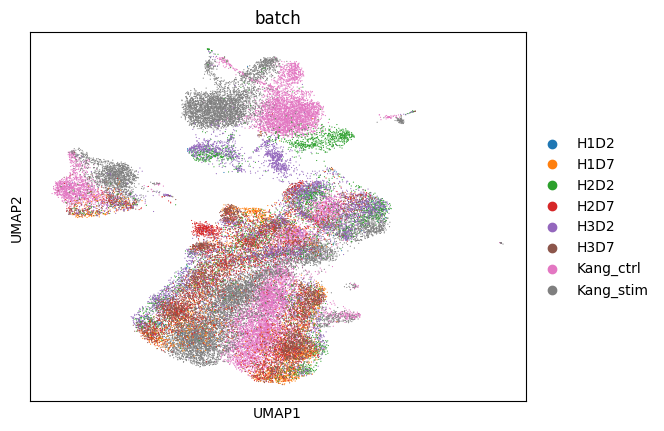

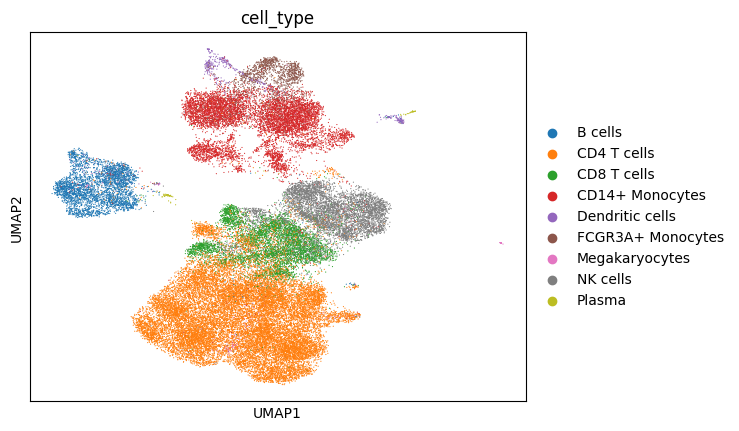

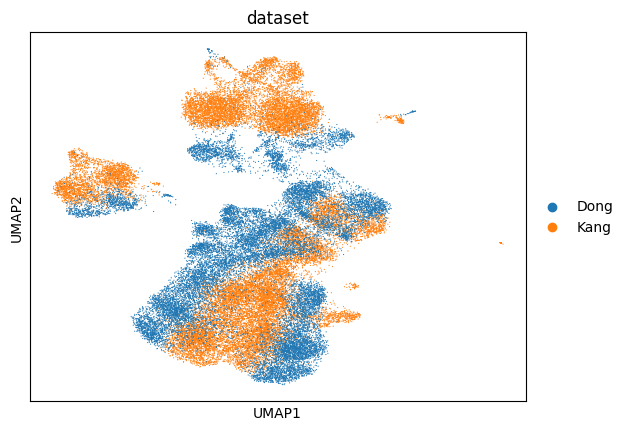

In [34]:
sc.pl.umap(adata_scvi, color="batch") # Plotting UMAP of the integrated dataset colored by 'batch'
sc.pl.umap(adata_scvi, color="cell_type") # Plotting UMAP of the integrated dataset colored by 'cell_type'
sc.pl.umap(adata_scvi, color="dataset") # Plotting UMAP of the integrated dataset colored by 'dataset'

# scGen Cross-Study Data Preparation and Execution (Kang → Dong)

This section creates the clean training/query splits for true cross-study generalization testing using scVI-integrated data. Kang data teaches scGen the IFN-β perturbation vector; Dong data tests transferability across studies/protocols. Execute scGen training on Kang control/IFNb data to learn perturbation vector δ_IFNb, then prepare for Dong query prediction. This establishes the true leave-one-out protocol with no Dong stimulated leakage.

In [35]:
# Create training set (Kang dataset with IFNb or ctrl perturbations)
train_scvi = adata_scvi[(adata_scvi.obs["dataset"] == "Kang") & 
                   (adata_scvi.obs["perturbation"].isin(["IFNb", "ctrl"]))].copy()

# Create query set (Dong dataset)
query_scvi = adata_scvi[adata_scvi.obs["dataset"] == "Dong"].copy()

# Get common cell types (exclude Plasma)
train_cell_types_scvi = set(train_scvi.obs['cell_type'].unique())
query_cell_types_scvi = set(query_scvi.obs['cell_type'].unique())
common_cell_types_scvi = train_cell_types_scvi & query_cell_types_scvi

print(f"Common cell types (scVI): {common_cell_types_scvi}")

# Filter to common cell types only
query_scvi_filtered = query_scvi[query_scvi.obs['cell_type'].isin(common_cell_types_scvi)].copy()
query_CTRL_scvi = query_scvi_filtered[query_scvi_filtered.obs["perturbation"] == "ctrl"].copy()
query_STIM_scvi = query_scvi_filtered[query_scvi_filtered.obs["perturbation"] == "IFNb"].copy()

print(f"scVI Training: {train_scvi.shape}")
print(f"scVI Query control: {query_CTRL_scvi.shape}")
print(f"scVI Query stimulated: {query_STIM_scvi.shape}")

Common cell types (scVI): {'B cells', 'CD4 T cells', 'CD8 T cells', 'NK cells', 'Dendritic cells', 'CD14+ Monocytes'}
scVI Training: (24471, 3000)
scVI Query control: (10260, 3000)
scVI Query stimulated: (9527, 3000)


In [36]:
# Prepare the training AnnData for scGen (perturbation as batch, cell type as label)
pt.tl.Scgen.setup_anndata(train_scvi, batch_key="perturbation", labels_key="cell_type")

# Initialize scGen model with the training data
model_scvi = pt.tl.Scgen(train_scvi)

# Register target dataset if it includes additional cell types not seen during training
model_scvi._register_manager_for_instance(
    model_scvi.adata_manager.transfer_fields(adata_target=query_CTRL_scvi, extend_categories=False)
)

# Train the scGen model with early stopping on CPU
model_scvi.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
    accelerator="cpu",
)

INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 367.598. Signaling Trainer to stop.


# scGen Prediction & Evaluation (Kang → Dong)

Execute scGen prediction on Dong control cells to generate IFN-β predictions, then combine with ground truth for cross-study R² benchmarking. Visualize alignment between predicted vs actual Dong IFN-β responses.

In [37]:
# Predict IFNb response for control query cells and label predictions
pred_scvi, delta = model_scvi.predict(adata_to_predict=query_CTRL_scvi, ctrl_key="ctrl", stim_key="IFNb")
pred_scvi.obs["perturbation"] = "pred"

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [38]:
# Combine control, stimulated, and predicted cells into a single AnnData object
eval_adata_scvi = query_CTRL_scvi.concatenate(query_STIM_scvi, pred_scvi)
eval_adata_scvi.obs_names_make_unique()

In [39]:
# Count the number of cells in each perturbation category
eval_adata_scvi.obs['perturbation'].value_counts()

perturbation
ctrl    10260
pred    10260
IFNb     9527
Name: count, dtype: int64

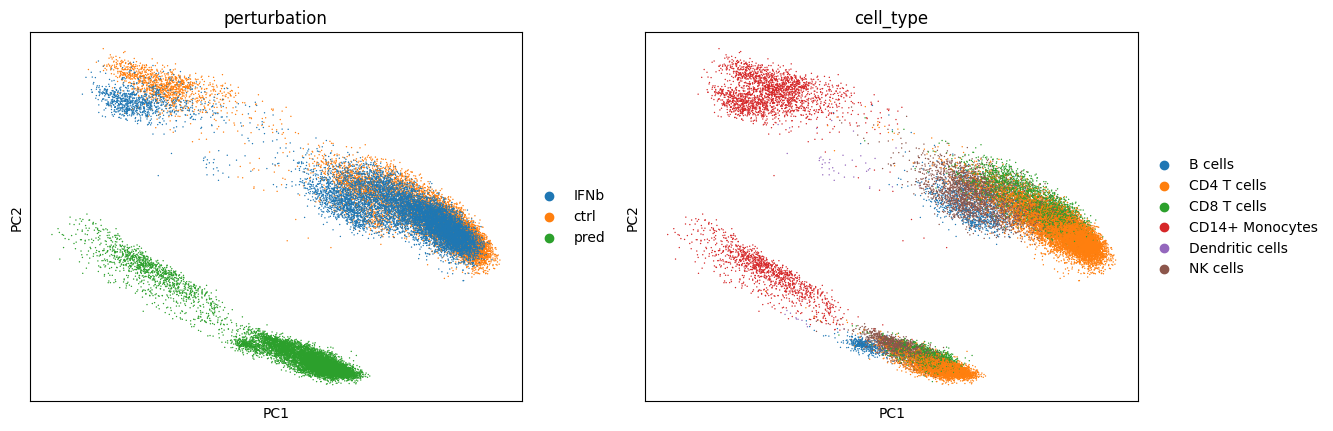

In [40]:
# Compute PCA and visualize it colored by perturbation and cell type
sc.tl.pca(eval_adata_scvi)
sc.pl.pca(eval_adata_scvi, color=["perturbation", "cell_type"])

# scGen R² Evaluation (Kang → Dong Cross-Study)

Execute custom R² benchmarking using deterministic mean/variance computation (identical to bootstrap_metrics internal logic). This reveals true cross-study transferability per cell type—scGen Kang-learned perturbation vs Dong ground truth.

In [44]:
# Helper functions
def _r2(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Deterministic R² (identical to the computation inside `bootstrap_metrics`)
    ---------------------------------------------------
    * Parameters come in as 1-D arrays (means, variances, …)
    * If the true signal is constant (zero variance) → returns np.nan
    """
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_true.mean()) ** 2)
    return np.nan if ss_tot == 0 else 1 - ss_res / ss_tot


def bootstrap_metrics_with_std(X, stim_m, pred_m, Xp, n_boot=100, frac=0.8, seed=SEED):
    """Bootstrap evaluation metrics - returns mean and std"""
    rng = np.random.default_rng(seed)
    results = {'R2': [], 'MSE': [], 'Pearson': []}

    stim_idx = np.where(stim_m)[0]
    pred_idx = np.where(pred_m)[0]

    if len(stim_idx) == 0 or len(pred_idx) == 0:
        return {
            'R2': np.nan, 'R2_std': np.nan,
            'MSE': np.nan, 'MSE_std': np.nan,
            'Pearson': np.nan, 'Pearson_std': np.nan
        }

    for _ in range(n_boot):
        n_stim_sample = int(len(stim_idx) * frac)
        n_pred_sample = int(len(pred_idx) * frac)

        stim_sample = rng.choice(stim_idx, n_stim_sample, replace=False)
        pred_sample = rng.choice(pred_idx, n_pred_sample, replace=False)

        stim_mean = X[stim_sample].mean(axis=0)
        pred_mean = X[pred_sample].mean(axis=0)

        # R²
        ss_res = ((stim_mean - pred_mean) ** 2).sum()
        ss_tot = ((stim_mean - stim_mean.mean()) ** 2).sum()
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

        # MSE
        mse = np.mean((stim_mean - pred_mean) ** 2)

        # Pearson
        pearson = np.corrcoef(stim_mean, pred_mean)[0, 1]

        results['R2'].append(r2)
        results['MSE'].append(mse)
        results['Pearson'].append(pearson)

    # Return mean and std
    return {
        'R2': np.nanmean(results['R2']),
        'R2_std': np.nanstd(results['R2']),
        'MSE': np.nanmean(results['MSE']),
        'MSE_std': np.nanstd(results['MSE']),
        'Pearson': np.nanmean(results['Pearson']),
        'Pearson_std': np.nanstd(results['Pearson'])
    }


def energy_d(X1, X2, max_cells=1000, seed=42):
    """Calculate energy distance"""
    from scipy.spatial.distance import cdist, pdist

    rng = np.random.default_rng(seed)

    # Sample if too large
    if len(X1) > max_cells:
        X1 = X1[rng.choice(len(X1), max_cells, replace=False)]
    if len(X2) > max_cells:
        X2 = X2[rng.choice(len(X2), max_cells, replace=False)]

    # Calculate distances
    d12 = cdist(X1, X2, metric='euclidean')
    d11 = pdist(X1, metric='euclidean')
    d22 = pdist(X2, metric='euclidean')

    return 2 * np.mean(d12) - np.mean(d11) - np.mean(d22)


def mean_var_kde_distance(X_real, X_pred):
    """Calculate mean-variance KDE distance"""
    from scipy.stats import gaussian_kde

    # Calculate means and variances
    real_mean = X_real.mean(axis=0)
    real_var = X_real.var(axis=0)
    pred_mean = X_pred.mean(axis=0)
    pred_var = X_pred.var(axis=0)

    # Use top 100 varying genes
    var_genes = np.argsort(real_var)[-100:]
    real_mv = np.column_stack([real_mean[var_genes], real_var[var_genes]])
    pred_mv = np.column_stack([pred_mean[var_genes], pred_var[var_genes]])

    # KDE
    kde_real = gaussian_kde(real_mv.T)
    kde_pred = gaussian_kde(pred_mv.T)

    # Sample points for distance calculation
    try:
        cov_matrix = np.cov(real_mv.T)
        cov_matrix += np.eye(2) * 1e-6  # regularization
        sample_points = np.random.multivariate_normal(
            real_mv.mean(axis=0),
            cov_matrix,
            size=1000
        )
    except:
        return np.nan

    # Calculate KL-like distance
    real_dens = kde_real(sample_points.T)
    pred_dens = kde_pred(sample_points.T)
    eps = 1e-10
    real_dens = np.maximum(real_dens, eps)
    pred_dens = np.maximum(pred_dens, eps)

    return np.mean(real_dens * np.log(real_dens / pred_dens))


def compute_mmd_rbf(X, Y, gamma=None):
    """Maximum Mean Discrepancy with RBF kernel"""
    from scipy.spatial.distance import cdist

    if gamma is None:
        gamma = 1.0 / X.shape[1]

    # Subsample for efficiency
    if len(X) > 500:
        idx_x = np.random.choice(len(X), 500, replace=False)
        idx_y = np.random.choice(len(Y), 500, replace=False)
        X = X[idx_x]
        Y = Y[idx_y]

    XX = np.exp(-gamma * cdist(X, X, 'sqeuclidean'))
    YY = np.exp(-gamma * cdist(Y, Y, 'sqeuclidean'))
    XY = np.exp(-gamma * cdist(X, Y, 'sqeuclidean'))

    return XX.mean() + YY.mean() - 2 * XY.mean()


def compute_deg_metrics(X_true, X_pred, X_ctrl, top_k=100):
    """DEG-related metrics: Jaccard and Direction Accuracy"""
    mean_true = X_true.mean(axis=0)
    mean_ctrl = X_ctrl.mean(axis=0)
    delta_true = mean_true - mean_ctrl

    mean_pred = X_pred.mean(axis=0)
    delta_pred = mean_pred - mean_ctrl

    top_k_actual = min(top_k, len(delta_true))
    top_k_true = np.argsort(np.abs(delta_true))[-top_k_actual:]
    top_k_pred = np.argsort(np.abs(delta_pred))[-top_k_actual:]
    jaccard = len(np.intersect1d(top_k_true, top_k_pred)) / top_k_actual

    direction_correct = (np.sign(delta_true) == np.sign(delta_pred)).mean()

    return {
        'Jaccard_top100': jaccard,
        'Direction_Accuracy': direction_correct
    }


def plot_r2_mean_variance_by_celltype(
    adata,
    condition_col="condition",
    celltype_col="cell_type",
    cond_a="eoPE",
    cond_b="pred",
    title=None,
    consistent_order=True,
    figsize=None,
):
    """Compare per-gene mean and variance between two conditions, cell-type wise."""
    r2_mean_dict, r2_var_dict = {}, {}

    for cell_type in adata.obs[celltype_col].unique():
        adata_sub = adata[adata.obs[celltype_col] == cell_type]

        if not {cond_a, cond_b}.issubset(adata_sub.obs[condition_col].unique()):
            continue

        a_cells = adata_sub[adata_sub.obs[condition_col] == cond_a]
        b_cells = adata_sub[adata_sub.obs[condition_col] == cond_b]

        X_a = a_cells.raw.X if a_cells.raw is not None else a_cells.X
        X_b = b_cells.raw.X if b_cells.raw is not None else b_cells.X

        X_a = X_a.toarray() if hasattr(X_a, "toarray") else X_a
        X_b = X_b.toarray() if hasattr(X_b, "toarray") else X_b

        mean_a, mean_b = X_a.mean(0).flatten(), X_b.mean(0).flatten()
        var_a, var_b = X_a.var(0).flatten(), X_b.var(0).flatten()

        if np.allclose(var_a.var(), 0) or np.allclose(var_b.var(), 0):
            continue

        r2_mean_dict[cell_type] = _r2(mean_a, mean_b)
        r2_var_dict[cell_type] = _r2(var_a, var_b)

    df_all = pd.DataFrame({"R2_mean": r2_mean_dict, "R2_var": r2_var_dict})
    df_all.index.name = "cell_type"

    if consistent_order and pd.api.types.is_categorical_dtype(adata.obs[celltype_col]):
        ordered = [ct for ct in adata.obs[celltype_col].cat.categories if ct in df_all.index]
        df_all = df_all.loc[ordered]
    else:
        df_all = df_all.sort_index()

    if figsize is None:
        figsize = (12, max(2, len(df_all) * 0.4))

    if f"{celltype_col}_colors" in adata.uns:
        color_map = dict(zip(adata.obs[celltype_col].cat.categories, adata.uns[f"{celltype_col}_colors"]))
        bar_colors = [color_map.get(ct, "#1f77b4") for ct in df_all.index]
    else:
        bar_colors = "#1f77b4"

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
    axes[0].barh(df_all.index, df_all["R2_mean"], color=bar_colors)
    axes[0].set_title("R² of Mean Expression")
    axes[0].set_xlabel("R²")
    axes[0].invert_yaxis()

    axes[1].barh(df_all.index, df_all["R2_var"], color=bar_colors)
    axes[1].set_title("R² of Variance")
    axes[1].set_xlabel("R²")

    for ax in axes:
        ax.set_xlim(0, 1)
        ax.grid(True, axis="x", linestyle="--", alpha=0.5)
        ax.tick_params(labelsize=10)

    if title:
        fig.suptitle(title, fontsize=14)

    plt.tight_layout()
    plt.show()

    return df_all


print("Helper functions defined")

Helper functions defined



COMPUTING COMPREHENSIVE METRICS

Evaluating: B cells
  Cells: Real=417, Pred=428, Ctrl=428
  Calculating metrics...

  RESULTS:
    R² = 0.671
    Pearson = 0.845
    MSE = 0.2241
    Energy distance = 34.788
    MV-KDE = 2.208
    MMD = 0.3795
    Wasserstein = 0.8350
    Jaccard = 0.280
    Direction Acc = 0.519

Evaluating: CD4 T cells
  Cells: Real=4881, Pred=5465, Ctrl=5465
  Calculating metrics...

  RESULTS:
    R² = 0.770
    Pearson = 0.890
    MSE = 0.1336
    Energy distance = 25.097
    MV-KDE = 1.153
    MMD = 0.2408
    Wasserstein = 0.6810
    Jaccard = 0.340
    Direction Acc = 0.476

Evaluating: CD8 T cells
  Cells: Real=1390, Pred=1378, Ctrl=1378
  Calculating metrics...

  RESULTS:
    R² = 0.771
    Pearson = 0.889
    MSE = 0.1442
    Energy distance = 25.654
    MV-KDE = 1.107
    MMD = 0.2554
    Wasserstein = 0.7168
    Jaccard = 0.330
    Direction Acc = 0.491

Evaluating: NK cells
  Cells: Real=1837, Pred=1754, Ctrl=1754
  Calculating metrics...

  RESULTS:
 

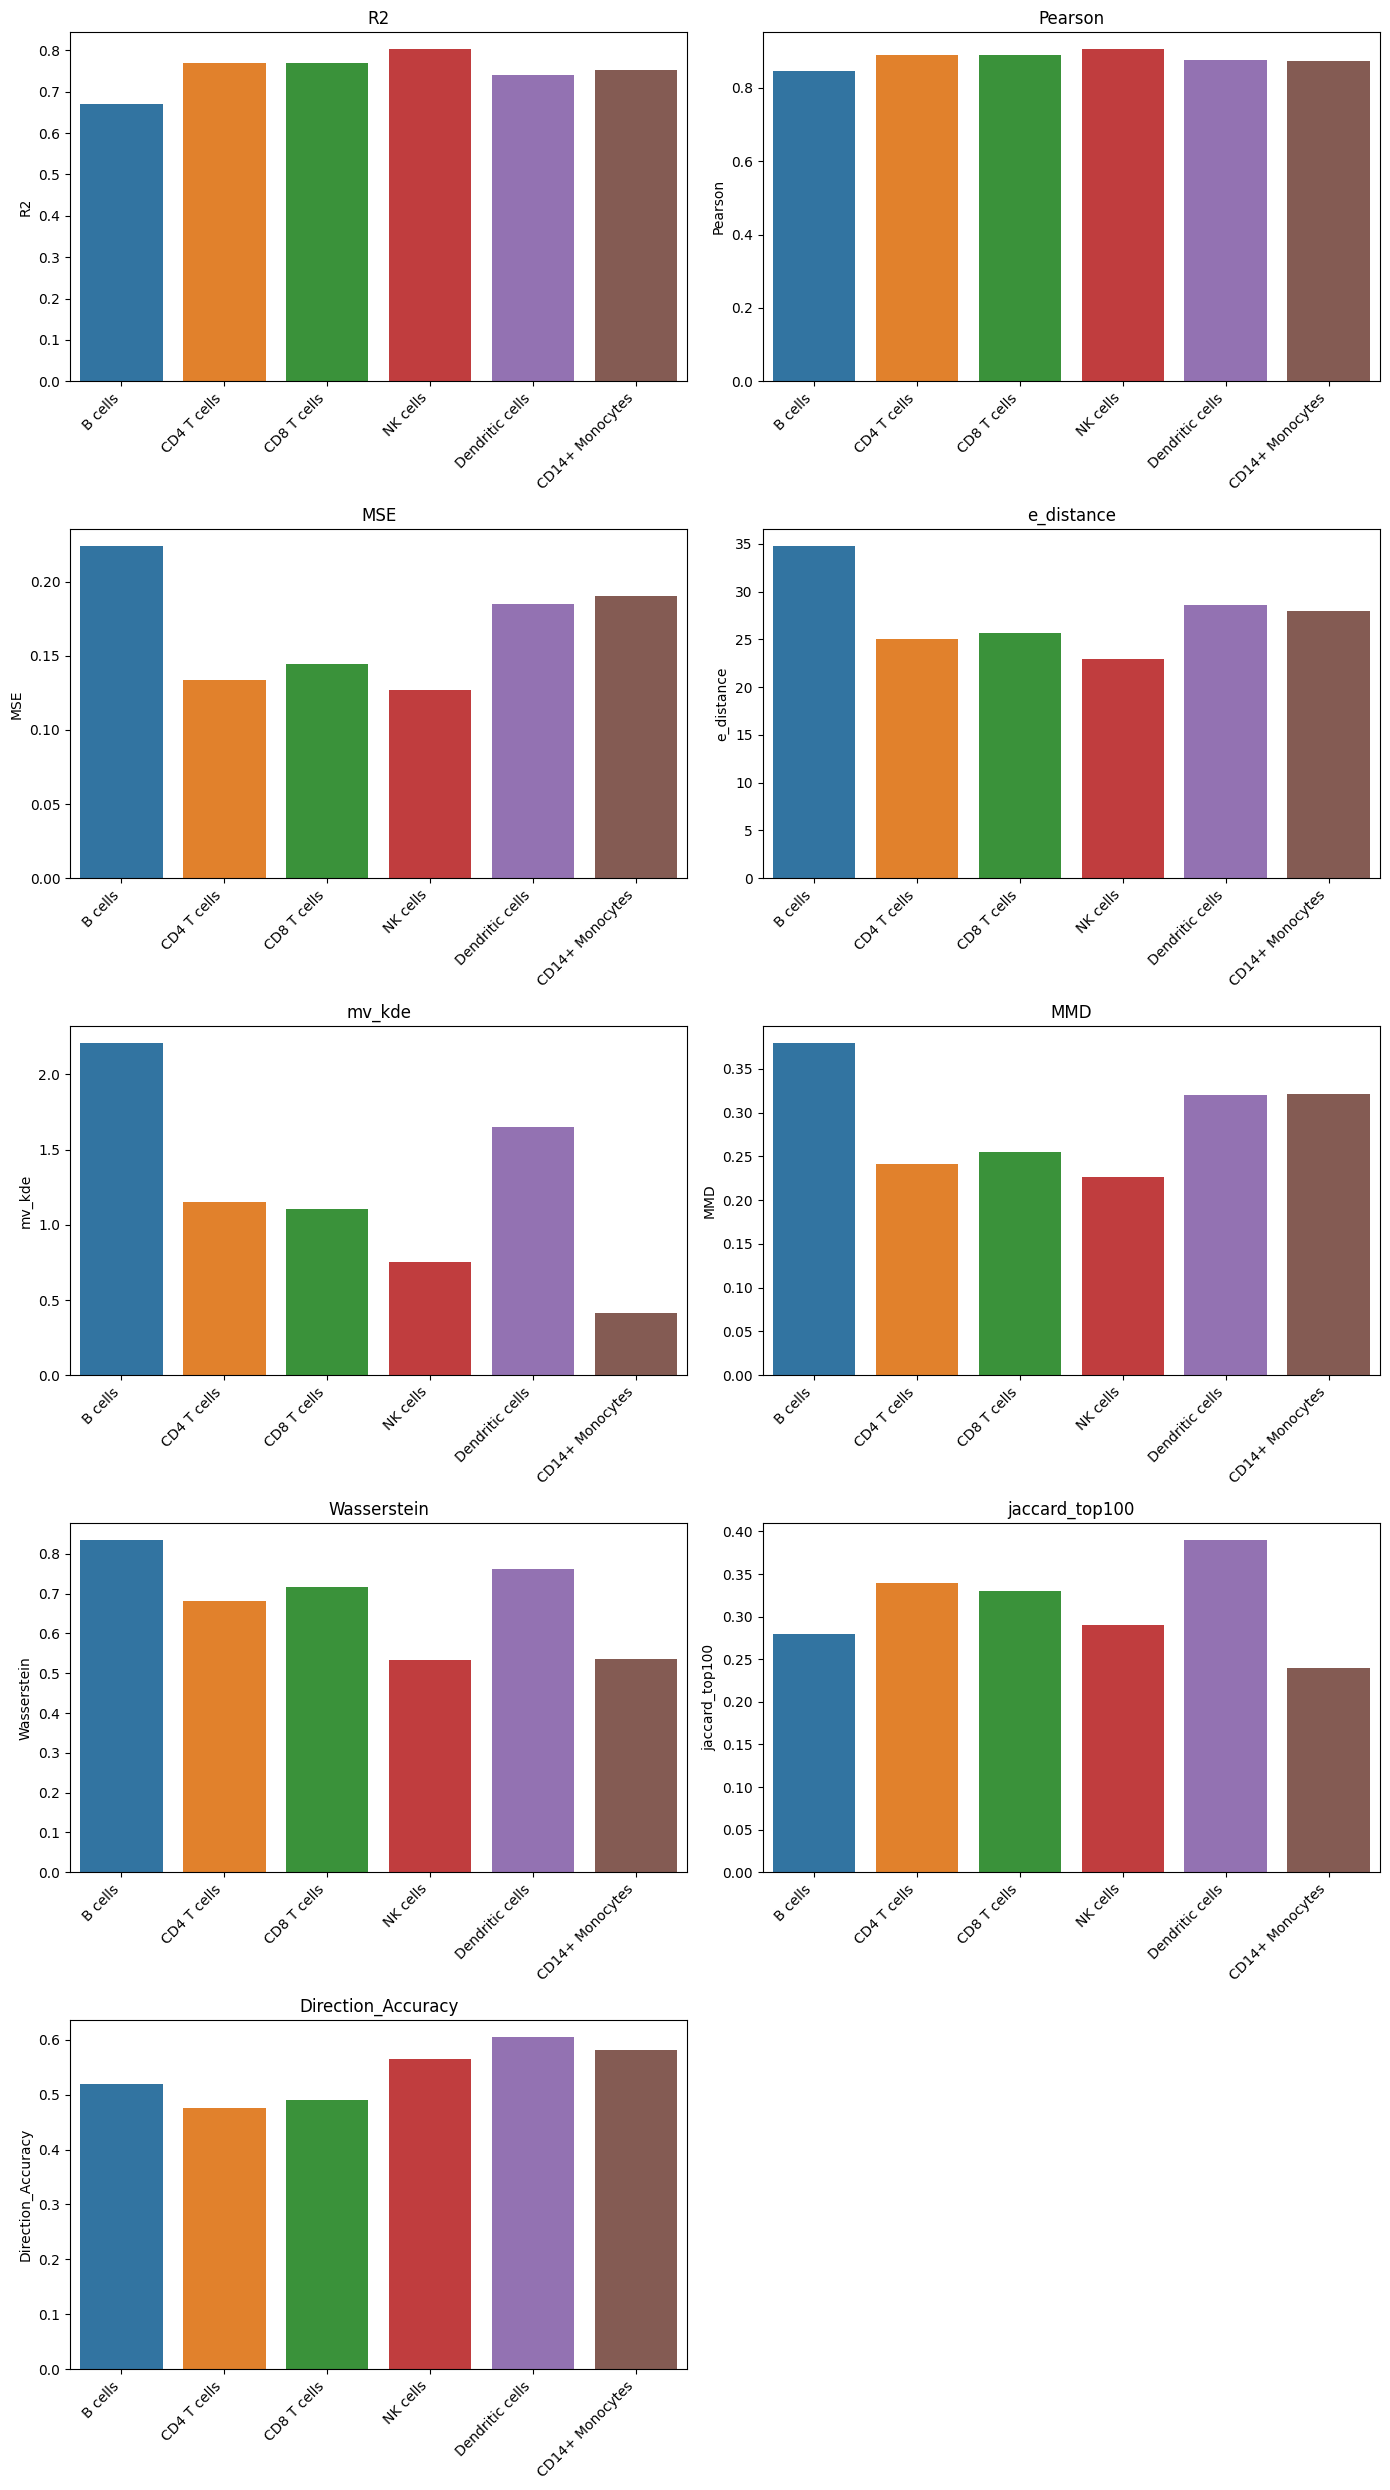


VISUALIZATION


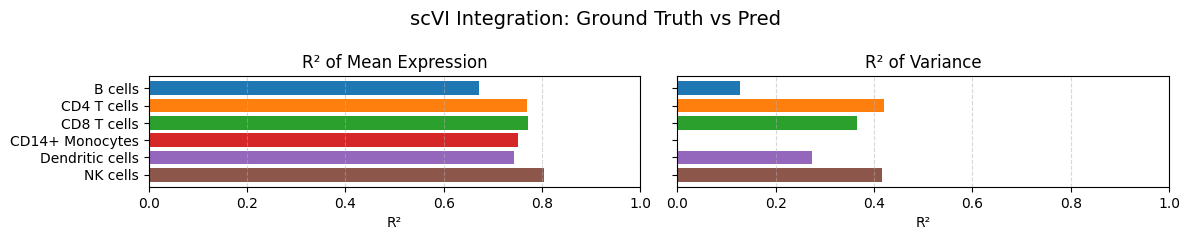


SAVING RESULTS
 Saved: scgen_scvi_integrated_cross_results.csv
 Saved: scgen_scvi_integrated_cross_eval.h5ad

 EVALUATION COMPLETE


In [45]:
# ───────────────────────────────────────────────────────────────────────
# COMPUTE COMPREHENSIVE METRICS
# ───────────────────────────────────────────────────────────────────────

print(f"\n{'='*80}")
print("COMPUTING COMPREHENSIVE METRICS")
print(f"{'='*80}")

# Key dictionary
key_dic_dataset = {
    'condition_key': 'perturbation',
    'cell_type_key': 'cell_type',
    'ctrl_key': 'ctrl',
    'stim_key': 'IFNb',
    'pred_key': 'pred'
}

all_metrics = []

for cell_type in common_cell_types_scvi:
    print(f"\n{'='*80}")
    print(f"Evaluating: {cell_type}")
    print(f"{'='*80}")
    
    try:
        # Subset evaluation data
        eval_ct = eval_adata_scvi[eval_adata_scvi.obs['cell_type'] == cell_type].copy()
        
        # Get subset from original query for control cells
        subset = adata_scvi[adata_scvi.obs['cell_type'] == cell_type].copy()
        dong_ctrl = subset[
            (subset.obs['dataset'] == 'Dong') & 
            (subset.obs['perturbation'] == 'ctrl')
        ].copy()
        dong_ctrl_count = len(dong_ctrl)
        
        # Masks
        Xp = eval_ct.obsm["X_pca"]
        cond = eval_ct.obs[key_dic_dataset['condition_key']]
        stim_m = cond == key_dic_dataset['stim_key']
        pred_m = cond == key_dic_dataset['pred_key']
        
        n_stim = stim_m.sum()
        n_pred = pred_m.sum()
        
        print(f"  Cells: Real={n_stim}, Pred={n_pred}, Ctrl={dong_ctrl_count}")
        
        if n_stim < 10 or n_pred < 10:
            print(f"   Insufficient cells")
            continue
        
        X = eval_ct.X.toarray() if issparse(eval_ct.X) else eval_ct.X
        
        print(f"  Calculating metrics...")
        
        # 1. Bootstrap metrics
        boot = bootstrap_metrics_with_std(X, stim_m, pred_m, Xp, n_boot=100, frac=0.8, seed=SEED)
        
        # 2. Energy distance
        rng = np.random.default_rng(SEED)
        stim_indices = np.where(stim_m)[0]
        n_samples = min(len(stim_indices), 1000)
        stim_ids = rng.choice(stim_indices, n_samples, replace=False)
        Xp_stim_sub = Xp[stim_ids]
        e_dist = energy_d(Xp[pred_m], Xp_stim_sub, max_cells=1000, seed=SEED)
        
        # 3. MV-KDE
        mv_kde = mean_var_kde_distance(X[stim_m], X[pred_m])
        
        # 4. DEG metrics (requires control cells)
        try:
            # Add control to evaluation
            eval_ct_with_ctrl = eval_ct.concatenate(dong_ctrl)
            X_full = eval_ct_with_ctrl.X.toarray() if issparse(eval_ct_with_ctrl.X) else eval_ct_with_ctrl.X
            
            ctrl_m_full = eval_ct_with_ctrl.obs['perturbation'] == 'ctrl'
            stim_m_full = eval_ct_with_ctrl.obs['perturbation'] == 'IFNb'
            pred_m_full = eval_ct_with_ctrl.obs['perturbation'] == 'pred'
            
            deg_metrics = compute_deg_metrics(
                X_full[stim_m_full], 
                X_full[pred_m_full], 
                X_full[ctrl_m_full], 
                top_k=100
            )
            jaccard = deg_metrics['Jaccard_top100']
            direction_acc = deg_metrics['Direction_Accuracy']
        except Exception as e:
            print(f"    Warning: DEG metrics failed: {e}")
            jaccard = np.nan
            direction_acc = np.nan
        
        # 5. MMD
        try:
            mmd = compute_mmd_rbf(X[stim_m], X[pred_m])
        except:
            mmd = np.nan
        
        # 6. Wasserstein
        try:
            wass_mean = wasserstein_distance(
                Xp[stim_m].mean(axis=0),
                Xp[pred_m].mean(axis=0)
            )
        except:
            wass_mean = np.nan
        
        # Store results
        cell_results = {
            "cell_type": cell_type,
            "R2": boot["R2"],
            "MSE": boot["MSE"],
            "Pearson": boot["Pearson"],
            "e_distance": e_dist,
            "mv_kde": mv_kde,
            "MMD": mmd,
            "Wasserstein": wass_mean,
            "jaccard_top100": jaccard,
            "Direction_Accuracy": direction_acc,
            "n_real_stim": int(n_stim),
            "n_predicted": int(n_pred),
            "n_ctrl": int(dong_ctrl_count)
        }
        all_metrics.append(cell_results)
        
        # Print results
        print(f"\n  RESULTS:")
        print(f"    R² = {boot['R2']:.3f}")
        print(f"    Pearson = {boot['Pearson']:.3f}")
        print(f"    MSE = {boot['MSE']:.4f}")
        print(f"    Energy distance = {e_dist:.3f}")
        print(f"    MV-KDE = {mv_kde:.3f}")
        if not np.isnan(mmd):
            print(f"    MMD = {mmd:.4f}")
        if not np.isnan(wass_mean):
            print(f"    Wasserstein = {wass_mean:.4f}")
        if not np.isnan(jaccard):
            print(f"    Jaccard = {jaccard:.3f}")
        if not np.isnan(direction_acc):
            print(f"    Direction Acc = {direction_acc:.3f}")
        
    except Exception as e:
        print(f"\n  ✗ Error: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

# ───────────────────────────────────────────────────────────────────────
# SUMMARY AND SAVE
# ───────────────────────────────────────────────────────────────────────

print(f"\n{'='*80}")
print("FINAL RESULTS SUMMARY")
print(f"{'='*80}")

if all_metrics:
    results_df = pd.DataFrame(all_metrics)
    
    print(f"\nCell types evaluated: {len(results_df)}")
    print(f"\nMean-Level Metrics:")
    print(f"  R²:      {results_df['R2'].mean():.3f} ± {results_df['R2'].std():.3f}")
    print(f"  Pearson: {results_df['Pearson'].mean():.3f} ± {results_df['Pearson'].std():.3f}")
    print(f"  MSE:     {results_df['MSE'].mean():.4f} ± {results_df['MSE'].std():.4f}")
    
    print(f"\nDistribution Metrics:")
    print(f"  Energy distance: {results_df['e_distance'].mean():.3f} ± {results_df['e_distance'].std():.3f}")
    print(f"  MV-KDE:         {results_df['mv_kde'].mean():.3f} ± {results_df['mv_kde'].std():.3f}")
    
    mmd_valid = results_df['MMD'].dropna()
    if len(mmd_valid) > 0:
        print(f"  MMD:            {mmd_valid.mean():.4f} ± {mmd_valid.std():.4f}")
    
    wass_valid = results_df['Wasserstein'].dropna()
    if len(wass_valid) > 0:
        print(f"  Wasserstein:    {wass_valid.mean():.4f} ± {wass_valid.std():.4f}")
    
    print(f"\nBiological Metrics:")
    jaccard_valid = results_df['jaccard_top100'].dropna()
    if len(jaccard_valid) > 0:
        print(f"  Jaccard (top-100): {jaccard_valid.mean():.3f} ± {jaccard_valid.std():.3f}")
    
    dir_valid = results_df['Direction_Accuracy'].dropna()
    if len(dir_valid) > 0:
        print(f"  Direction Acc:     {dir_valid.mean():.3f} ± {dir_valid.std():.3f}")
    
    print(f"\n{'='*80}")
    print("DETAILED RESULTS")
    print(f"{'='*80}")
    print(results_df.round(3).to_string(index=False))
    
    # Visualization

    # Metrics to plot
    metric_list = [
        'R2', 'Pearson', 'MSE',
        'e_distance', 'mv_kde', 'MMD', 'Wasserstein',
        'jaccard_top100', 'Direction_Accuracy'
    ]

    # Number of columns and rows for layout
    n_cols = 2
    n_rows = math.ceil(len(metric_list) / n_cols)

    plt.figure(figsize=(14, n_rows * 5))

    for i, metric in enumerate(metric_list, 1):
        if metric in results_df.columns:
            plt.subplot(n_rows, n_cols, i)
            sns.barplot(
                data=results_df,
                x='cell_type',
                y=metric,
                ci='sd',            # Show standard deviation
                palette='tab10',
                capsize=0.2,        # <--- Adds the "T" caps
                errcolor='black',   # <--- Forces the error bars and caps to be black
                errwidth=1.5        # <--- Makes the lines thicker for better visibility
            )
            plt.title(metric)
            plt.xticks(rotation=45, ha='right')
            plt.xlabel('')
            plt.ylabel(metric)

    plt.tight_layout()
    plt.show()

    print(f"\n{'='*80}")
    print("VISUALIZATION")
    print(f"{'='*80}")
    
    results_viz = plot_r2_mean_variance_by_celltype(
        adata=eval_adata_scvi,
        condition_col="perturbation",
        celltype_col="cell_type",
        cond_a="IFNb",
        cond_b="pred",
        title="scVI Integration: Ground Truth vs Pred"
    )
    
    # Save
    print(f"\n{'='*80}")
    print("SAVING RESULTS")
    print(f"{'='*80}")
    
    results_df.to_csv('scgen_scvi_integrated_cross_results.csv', index=False)
    eval_adata_scvi.write('scgen_scvi_integrated_cross_eval.h5ad')
    
    print(" Saved: scgen_scvi_integrated_cross_results.csv")
    print(" Saved: scgen_scvi_integrated_cross_eval.h5ad")
    
else:
    print("\n No metrics computed")

print(f"\n{'='*80}")
print(" EVALUATION COMPLETE")
print(f"{'='*80}")

## Scanorama Integration + scGen Cross-Study Setup

This comprehensive section performs Scanorama integration as an alternative to scVI, then prepares scGen training/query splits for Kang→Dong cross-study benchmarking. Scanorama's iterative correction preserves perturbation biology while aligning cell states across studies.

**Key advantages vs scVI:**

* **Preserves perturbation variance:** Scanorama corrects batch but keeps biological signals
* **No probabilistic modeling:** Direct embedding alignment (faster, deterministic)

In [3]:
# Load raw, unintegrated Kang and Dong dataset
adata_raw = sc.read("unintegrated_Kang_Dong.h5ad")

# Inspect shape and available layers
print(f"Dataset shape: {adata_raw.shape}")
print(f"Available layers: {list(adata_raw.layers.keys())}")

# Add a 'dataset' column based on batch names
adata_raw.obs["dataset"] = adata_raw.obs['batch'].apply(
    lambda x: "Kang" if "Kang" in x else "Dong"
)

# Print cell counts per dataset
print(f"Datasets: {adata_raw.obs['dataset'].value_counts().to_dict()}")

Dataset shape: (44334, 42240)
Available layers: []
Datasets: {'Kang': 24471, 'Dong': 19863}


In [4]:
# Prepare data for Scanorama
print(f"Available layers: {list(adata_raw.layers.keys())}")

# Check if X is sparse and get max value
if hasattr(adata_raw.X, 'toarray'):
    X_max = adata_raw.X.data.max()
else:
    X_max = adata_raw.X.max()

print(f"Current X max value: {X_max:.2f}")

# Normalize if needed
if X_max > 20:
    print("Data appears to be raw counts, normalizing...")
    sc.pp.normalize_total(adata_raw, target_sum=1e4)
    sc.pp.log1p(adata_raw)
    print("Normalization complete")
else:
    print("Data appears already log-normalized")

# Check final range
if hasattr(adata_raw.X, 'toarray'):
    X_min = adata_raw.X.data.min()
    X_max = adata_raw.X.data.max()
else:
    X_min = adata_raw.X.min()
    X_max = adata_raw.X.max()

print(f"Final X range: [{X_min:.2f}, {X_max:.2f}]")
print("Data prepared for Scanorama integration")

Available layers: []
Current X max value: 5640.00
Data appears to be raw counts, normalizing...
Normalization complete
Final X range: [0.51, 8.73]
Data prepared for Scanorama integration


In [5]:
# Split into Kang and Dong for Scanorama
adata_kang = adata_raw[adata_raw.obs["batch"].str.contains("Kang")].copy()
adata_dong = adata_raw[adata_raw.obs["batch"].str.contains("H")].copy()

# Make var_names unique
for ad in [adata_kang, adata_dong]:
    ad.var_names_make_unique()
    ad.obs_names_make_unique()

print(f"Kang: {adata_kang.shape}")
print(f"Dong: {adata_dong.shape}")

Kang: (24471, 42240)
Dong: (19863, 42240)


In [6]:
# Run Scanorama integration
print("Running Scanorama integration...")
scanorama.integrate_scanpy([adata_kang, adata_dong])
print("Scanorama integration complete!")

Running Scanorama integration...
Found 42240 genes among all datasets
[[0.         0.14739896]
 [0.         0.        ]]
Processing datasets (0, 1)
Scanorama integration complete!


In [7]:
# Concatenate integrated datasets
scanorama_adata = sc.concat(
    [adata_kang, adata_dong],
    join='outer',
    label='original_dataset',
    keys=['Kang', 'Dong']
)

# Extract and add Scanorama embeddings
scanorama_embeddings = [adata.obsm['X_scanorama'] for adata in [adata_kang, adata_dong]]
scanorama_adata.obsm['X_scanorama'] = np.concatenate(scanorama_embeddings)

print(f"Combined dataset: {scanorama_adata.shape}")
print(f"Has Scanorama embeddings: {'X_scanorama' in scanorama_adata.obsm}")

# Select highly variable genes
print("\nSelecting highly variable genes...")
sc.pp.highly_variable_genes(scanorama_adata, n_top_genes=3000, flavor='seurat_v3')

print(f"Highly variable genes: {scanorama_adata.var['highly_variable'].sum()}")

# Subset to HVGs only
scanorama_adata = scanorama_adata[:, scanorama_adata.var['highly_variable']].copy()

print(f"Reduced to {scanorama_adata.n_vars} highly variable genes")
print(f"New shape: {scanorama_adata.shape}")

Combined dataset: (44334, 42240)
Has Scanorama embeddings: True

Selecting highly variable genes...
Highly variable genes: 3000
Reduced to 3000 highly variable genes
New shape: (44334, 3000)


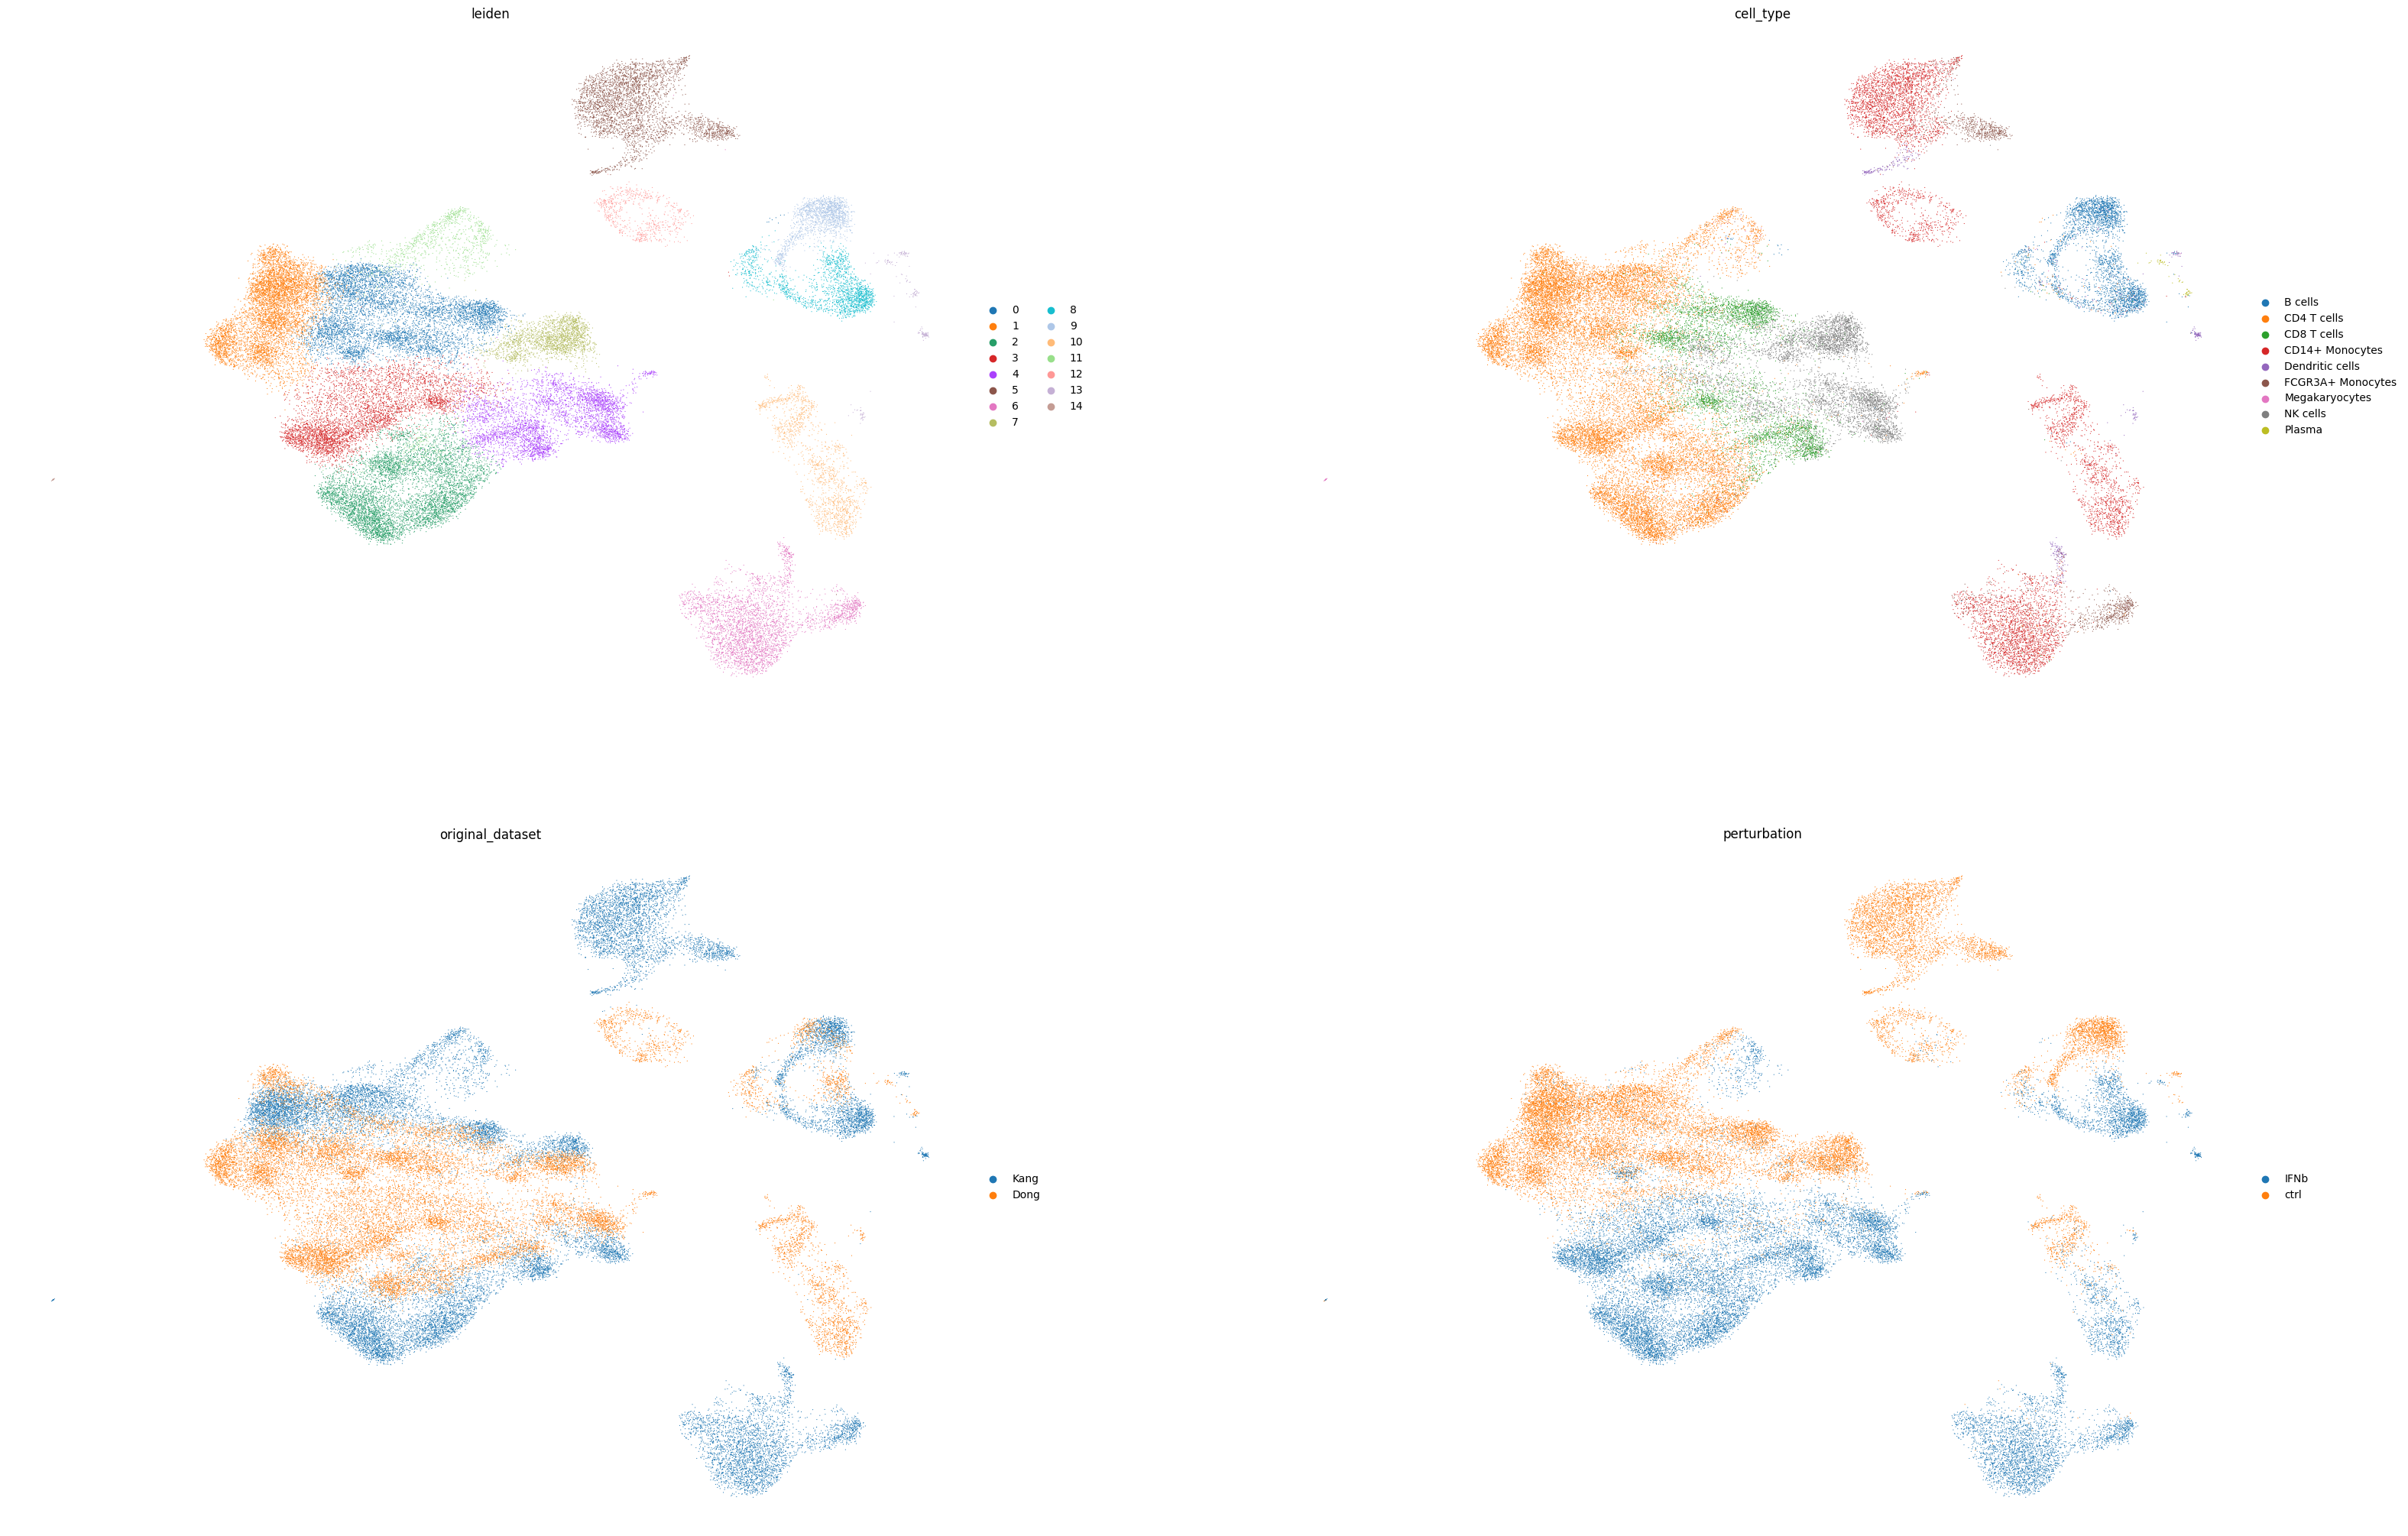

In [8]:
# Compute neighbors and UMAP using Scanorama embeddings
sc.pp.neighbors(scanorama_adata, use_rep="X_scanorama")
sc.tl.umap(scanorama_adata)
sc.tl.leiden(scanorama_adata, resolution=0.5)

# Visualize integration quality
from matplotlib import rc_context
with rc_context({'figure.figsize': (16, 12)}):
    sc.pl.umap(scanorama_adata, 
               color=['leiden', 'cell_type', 'original_dataset', 'perturbation'], 
               frameon=False, wspace=0.2, hspace=0.2, ncols=2)

In [9]:
# Create training set from Scanorama-integrated data
train_scanorama = scanorama_adata[
    (scanorama_adata.obs["original_dataset"] == "Kang") & 
    (scanorama_adata.obs["perturbation"].isin(["IFNb", "ctrl"]))
].copy()

print(f"Scanorama Training: {train_scanorama.shape}")
print(f"  Perturbations: {train_scanorama.obs['perturbation'].value_counts().to_dict()}")

# Get query data and filter to common cell types
query_scanorama = scanorama_adata[scanorama_adata.obs['original_dataset'] == 'Dong'].copy()

train_cell_types_scanorama = set(train_scanorama.obs['cell_type'].unique())
query_cell_types_scanorama = set(query_scanorama.obs['cell_type'].unique())
common_cell_types_scanorama = train_cell_types_scanorama & query_cell_types_scanorama

print(f"Common cell types (Scanorama): {common_cell_types_scanorama}")

query_scanorama_filtered = query_scanorama[
    query_scanorama.obs['cell_type'].isin(common_cell_types_scanorama)
].copy()

query_CTRL_scanorama = query_scanorama_filtered[
    query_scanorama_filtered.obs["perturbation"] == "ctrl"
].copy()

query_STIM_scanorama = query_scanorama_filtered[
    query_scanorama_filtered.obs["perturbation"] == "IFNb"
].copy()

Scanorama Training: (24471, 3000)
  Perturbations: {'ctrl': 12258, 'IFNb': 12213}
Common cell types (Scanorama): {'B cells', 'CD4 T cells', 'CD8 T cells', 'NK cells', 'Dendritic cells', 'CD14+ Monocytes'}


In [10]:
# Train scGen on Scanorama-integrated Kang data
pt.tl.Scgen.setup_anndata(train_scanorama, batch_key="perturbation", labels_key="cell_type")
scanorama_model = pt.tl.Scgen(train_scanorama)

# Register for prediction
scanorama_model._register_manager_for_instance(
    scanorama_model.adata_manager.transfer_fields(adata_target=query_CTRL_scanorama, extend_categories=False)
)

# Train
print("\nTraining Scanorama model...")
scanorama_model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
    accelerator='cpu',
)


Training Scanorama model...
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 492.418. Signaling Trainer to stop.


In [11]:
# Predict Dong IFN-β response
pred_scanorama, delta = scanorama_model.predict(
    adata_to_predict=query_CTRL_scanorama, 
    ctrl_key="ctrl", 
    stim_key="IFNb"
)
pred_scanorama.obs["perturbation"] = "pred"

# Build evaluation object
eval_adata_scanorama = query_CTRL_scanorama.concatenate(query_STIM_scanorama, pred_scanorama)
eval_adata_scanorama.obs_names_make_unique()

print(f"Evaluation dataset: {eval_adata_scanorama.shape}")
print(f"Perturbations: {eval_adata_scanorama.obs['perturbation'].value_counts().to_dict()}")

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Evaluation dataset: (30047, 3000)
Perturbations: {'ctrl': 10260, 'pred': 10260, 'IFNb': 9527}


In [25]:
# Helper functions
def bootstrap_metrics(X, stim_m, pred_m, Xp, n_boot=100, frac=0.8, seed=SEED):
    """Bootstrap evaluation metrics (R², MSE, Pearson)"""
    rng = np.random.default_rng(seed)
    results = {'R2': [], 'MSE': [], 'Pearson': []}
    
    stim_idx = np.where(stim_m)[0]
    pred_idx = np.where(pred_m)[0]
    
    if len(stim_idx) == 0 or len(pred_idx) == 0:
        return {k: np.nan for k in results.keys()}
    
    for _ in range(n_boot):
        n_stim_sample = int(len(stim_idx) * frac)
        n_pred_sample = int(len(pred_idx) * frac)
        
        stim_sample = rng.choice(stim_idx, n_stim_sample, replace=False)
        pred_sample = rng.choice(pred_idx, n_pred_sample, replace=False)
        
        stim_mean = X[stim_sample].mean(axis=0)
        pred_mean = X[pred_sample].mean(axis=0)
        
        # R²
        ss_res = ((stim_mean - pred_mean) ** 2).sum()
        ss_tot = ((stim_mean - stim_mean.mean()) ** 2).sum()
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
        
        # MSE
        mse = np.mean((stim_mean - pred_mean) ** 2)
        
        # Pearson
        pearson = np.corrcoef(stim_mean, pred_mean)[0, 1]
        
        results['R2'].append(r2)
        results['MSE'].append(mse)
        results['Pearson'].append(pearson)
    
    return {k: np.nanmean(v) for k, v in results.items()}


def energy_d(X1, X2, max_cells=1000, seed=SEED):
    """Calculate energy distance"""
    rng = np.random.default_rng(seed)
    
    # Sample if too large
    if len(X1) > max_cells:
        X1 = X1[rng.choice(len(X1), max_cells, replace=False)]
    if len(X2) > max_cells:
        X2 = X2[rng.choice(len(X2), max_cells, replace=False)]
    
    # Calculate distances
    d12 = cdist(X1, X2, metric='euclidean')
    d11 = pdist(X1, metric='euclidean')
    d22 = pdist(X2, metric='euclidean')
    
    return 2 * np.mean(d12) - np.mean(d11) - np.mean(d22)


def mean_var_kde_distance(X_real, X_pred):
    """Calculate mean-variance KDE distance"""
    from scipy.stats import gaussian_kde
    
    # Calculate means and variances
    real_mean = X_real.mean(axis=0)
    real_var = X_real.var(axis=0)
    pred_mean = X_pred.mean(axis=0)
    pred_var = X_pred.var(axis=0)
    
    # Use top 100 varying genes
    var_genes = np.argsort(real_var)[-100:]
    real_mv = np.column_stack([real_mean[var_genes], real_var[var_genes]])
    pred_mv = np.column_stack([pred_mean[var_genes], pred_var[var_genes]])
    
    # KDE
    kde_real = gaussian_kde(real_mv.T)
    kde_pred = gaussian_kde(pred_mv.T)
    
    # Sample points for distance calculation
    try:
        cov_matrix = np.cov(real_mv.T)
        # Add small regularization to ensure positive definite
        cov_matrix += np.eye(2) * 1e-6
        
        sample_points = np.random.multivariate_normal(
            real_mv.mean(axis=0),
            cov_matrix,
            size=1000
        )
    except:
        # If covariance fails, return NaN
        return np.nan
    
    # Calculate KL-like distance
    real_dens = kde_real(sample_points.T)
    pred_dens = kde_pred(sample_points.T)
    
    eps = 1e-10
    real_dens = np.maximum(real_dens, eps)
    pred_dens = np.maximum(pred_dens, eps)
    
    return np.mean(real_dens * np.log(real_dens / pred_dens))


def compute_mmd_rbf(X, Y, gamma=None):
    """Maximum Mean Discrepancy with RBF kernel"""
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    
    # Subsample for efficiency
    if len(X) > 500:
        idx_x = np.random.choice(len(X), 500, replace=False)
        idx_y = np.random.choice(len(Y), 500, replace=False)
        X = X[idx_x]
        Y = Y[idx_y]
    
    XX = np.exp(-gamma * cdist(X, X, 'sqeuclidean'))
    YY = np.exp(-gamma * cdist(Y, Y, 'sqeuclidean'))
    XY = np.exp(-gamma * cdist(X, Y, 'sqeuclidean'))
    
    return XX.mean() + YY.mean() - 2 * XY.mean()


def compute_deg_metrics(X_true, X_pred, X_ctrl, top_k=100):
    """DEG-related metrics: Jaccard and Direction Accuracy"""
    mean_true = X_true.mean(axis=0)
    mean_ctrl = X_ctrl.mean(axis=0)
    delta_true = mean_true - mean_ctrl
    
    mean_pred = X_pred.mean(axis=0)
    delta_pred = mean_pred - mean_ctrl
    
    # Top-k overlap (Jaccard index)
    top_k_actual = min(top_k, len(delta_true))
    top_k_true = np.argsort(np.abs(delta_true))[-top_k_actual:]
    top_k_pred = np.argsort(np.abs(delta_pred))[-top_k_actual:]
    jaccard = len(np.intersect1d(top_k_true, top_k_pred)) / top_k_actual
    
    # Direction accuracy
    direction_correct = (np.sign(delta_true) == np.sign(delta_pred)).mean()
    
    return {
        'Jaccard_top100': jaccard,
        'Direction_Accuracy': direction_correct
    }

print(" Helper functions defined")

 Helper functions defined



CELL-TYPE-SPECIFIC EVALUATION - SCGEN + SCANORAMA

PROCESSING: B cells
Evaluation cells: 1273
Perturbations: {'ctrl': 428, 'pred': 428, 'IFNb': 417}
  Real IFNb: 417
  Predicted: 428

  Generating visualizations...


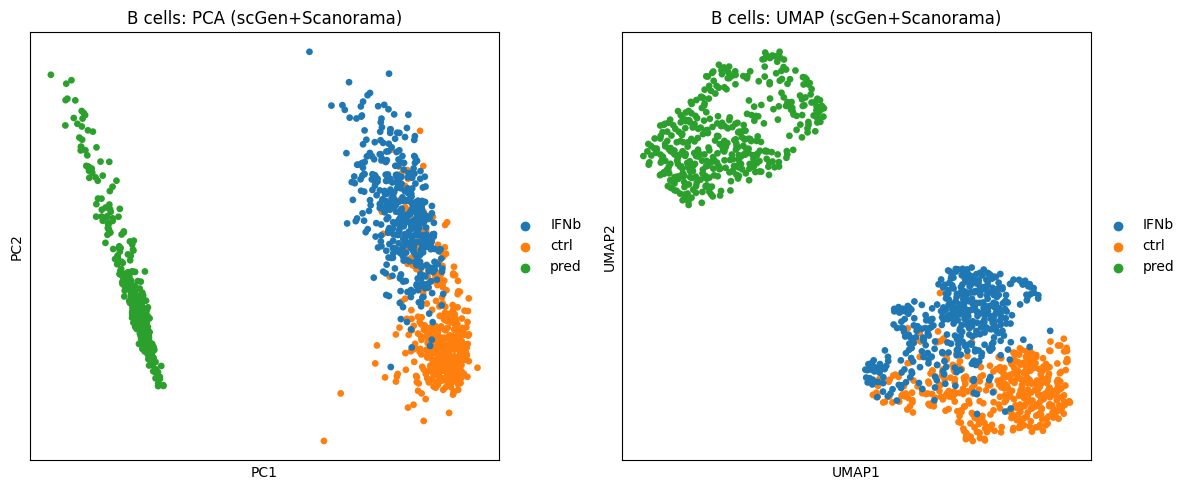

  Calculating metrics...

  RESULTS for B cells:
    R² = 0.456
    Pearson = 0.687
    MSE = 0.0855
    Energy distance = 20.851
    MV-KDE = 6.454
    MMD = 0.1568
    Wasserstein = 0.0753
    Jaccard = 0.710
    Direction Acc = 0.101


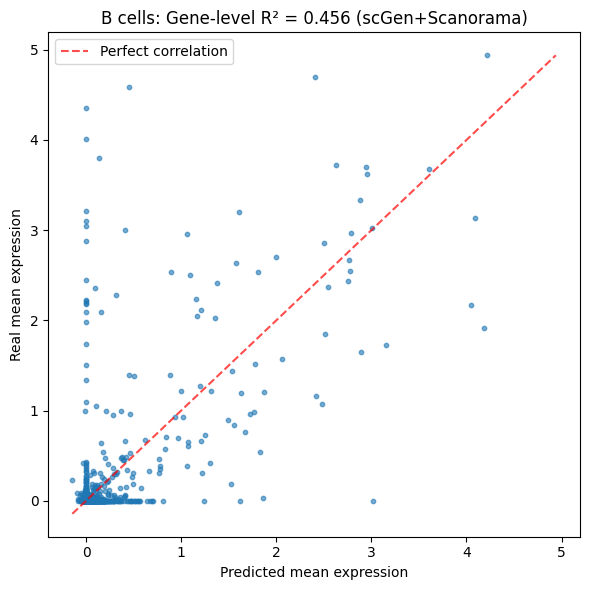

    Evaluation completed for B cells

PROCESSING: CD4 T cells
Evaluation cells: 15811
Perturbations: {'ctrl': 5465, 'pred': 5465, 'IFNb': 4881}
  Real IFNb: 4881
  Predicted: 5465

  Generating visualizations...


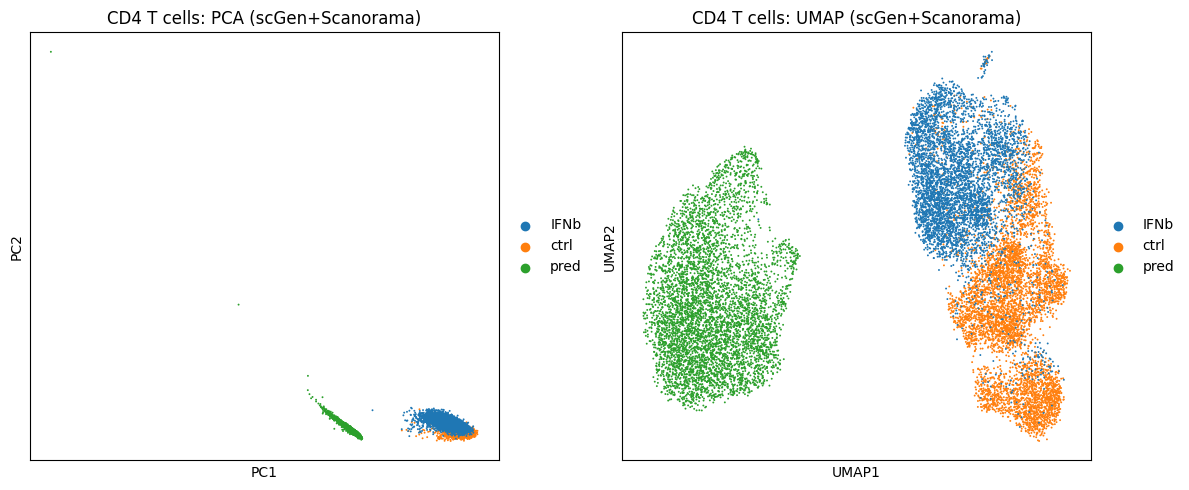

  Calculating metrics...

  RESULTS for CD4 T cells:
    R² = 0.381
    Pearson = 0.636
    MSE = 0.0785
    Energy distance = 20.622
    MV-KDE = 1.736
    MMD = 0.1443
    Wasserstein = 0.0670
    Jaccard = 0.740
    Direction Acc = 0.116


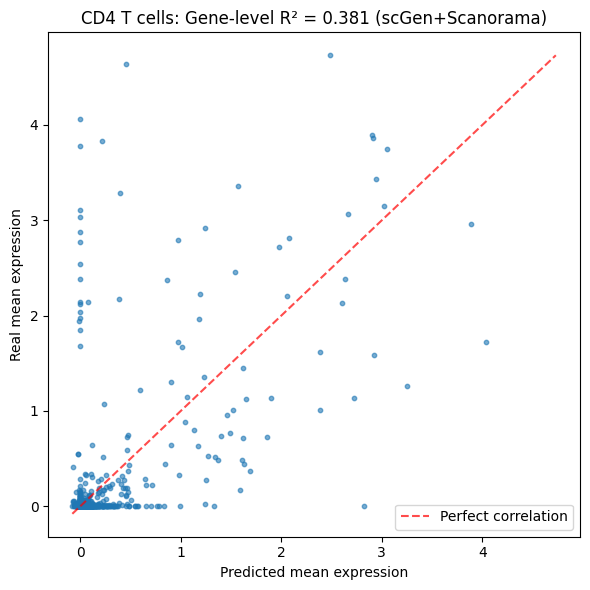

    Evaluation completed for CD4 T cells

PROCESSING: CD8 T cells
Evaluation cells: 4146
Perturbations: {'IFNb': 1390, 'ctrl': 1378, 'pred': 1378}
  Real IFNb: 1390
  Predicted: 1378

  Generating visualizations...


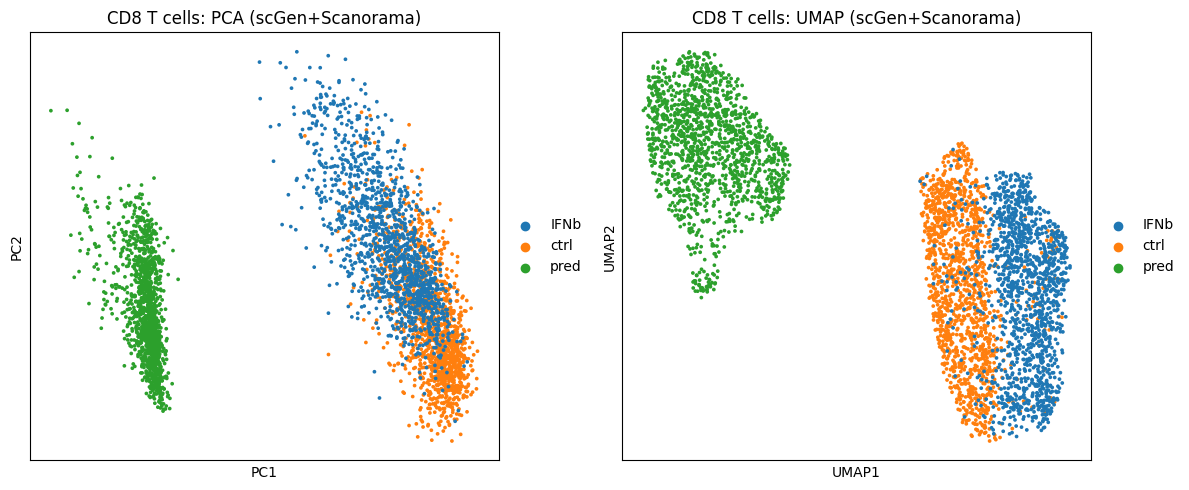

  Calculating metrics...

  RESULTS for CD8 T cells:
    R² = 0.414
    Pearson = 0.656
    MSE = 0.0734
    Energy distance = 18.127
    MV-KDE = 1.867
    MMD = 0.1354
    Wasserstein = 0.0715
    Jaccard = 0.720
    Direction Acc = 0.099


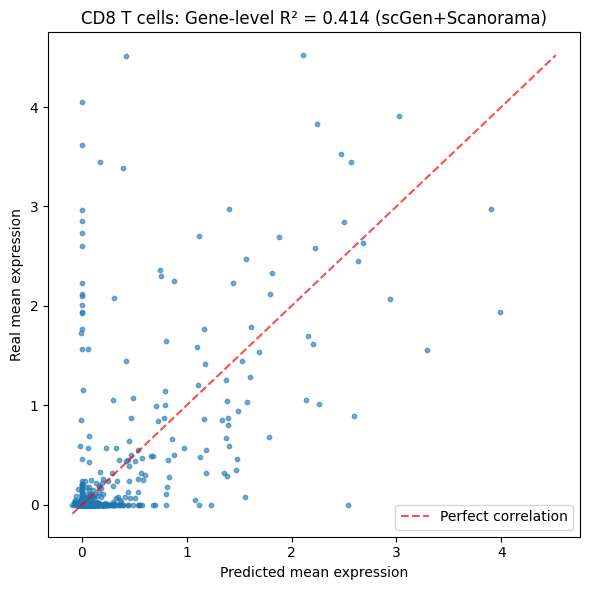

    Evaluation completed for CD8 T cells

PROCESSING: NK cells
Evaluation cells: 5345
Perturbations: {'IFNb': 1837, 'ctrl': 1754, 'pred': 1754}
  Real IFNb: 1837
  Predicted: 1754

  Generating visualizations...


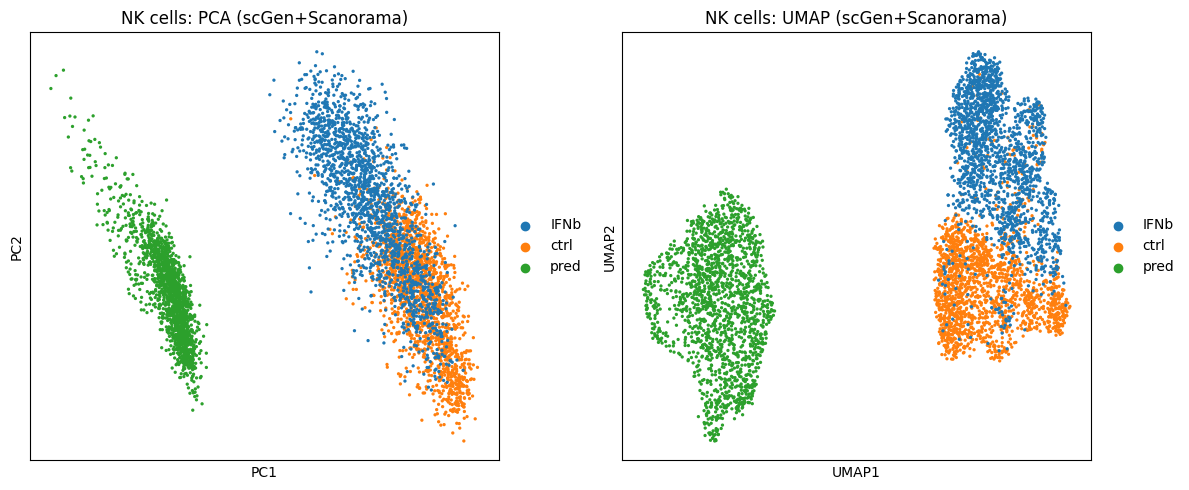

  Calculating metrics...

  RESULTS for NK cells:
    R² = 0.489
    Pearson = 0.711
    MSE = 0.0633
    Energy distance = 15.165
    MV-KDE = 7.145
    MMD = 0.1162
    Wasserstein = 0.0728
    Jaccard = 0.630
    Direction Acc = 0.110


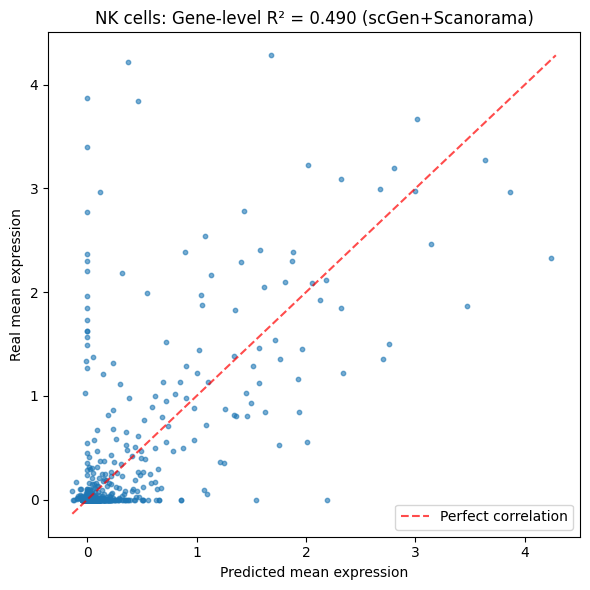

    Evaluation completed for NK cells

PROCESSING: Dendritic cells
Evaluation cells: 48
Perturbations: {'IFNb': 28, 'ctrl': 10, 'pred': 10}
  Real IFNb: 28
  Predicted: 10

  Generating visualizations...


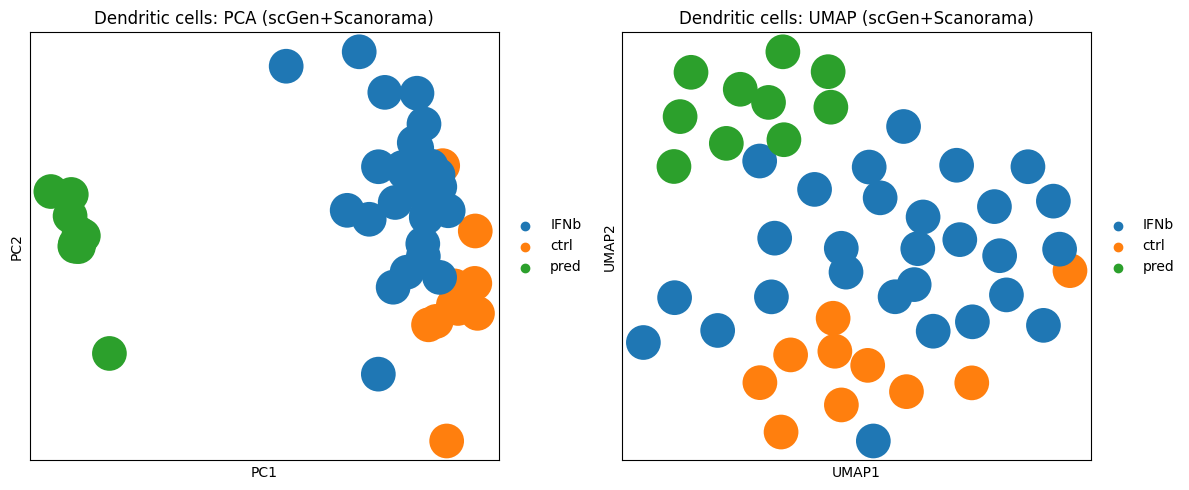

  Calculating metrics...

  RESULTS for Dendritic cells:
    R² = 0.573
    Pearson = 0.769
    MSE = 0.0818
    Energy distance = 19.057
    MV-KDE = 4.593
    MMD = 0.1509
    Wasserstein = 0.0785
    Jaccard = 0.620
    Direction Acc = 0.060


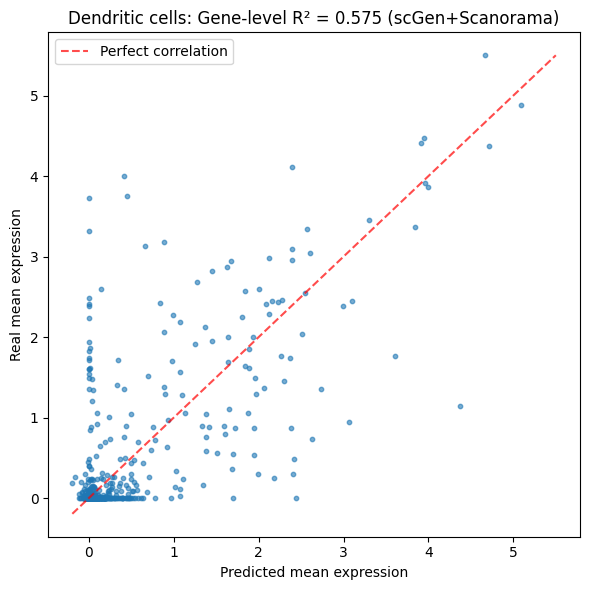

    Evaluation completed for Dendritic cells

PROCESSING: CD14+ Monocytes
Evaluation cells: 3424
Perturbations: {'ctrl': 1225, 'pred': 1225, 'IFNb': 974}
  Real IFNb: 974
  Predicted: 1225

  Generating visualizations...


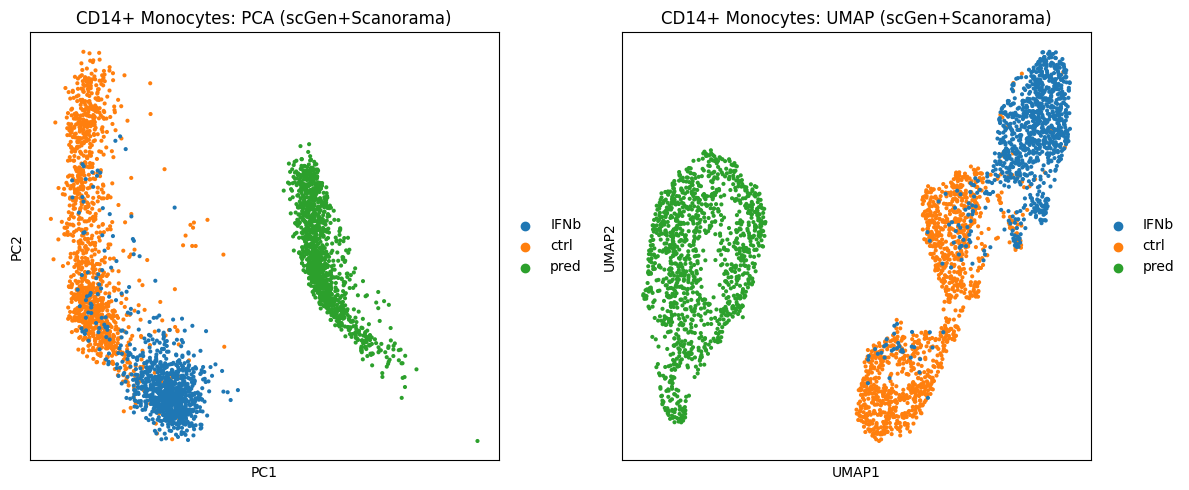

  Calculating metrics...

  RESULTS for CD14+ Monocytes:
    R² = 0.662
    Pearson = 0.816
    MSE = 0.0842
    Energy distance = 17.860
    MV-KDE = 0.502
    MMD = 0.1541
    Wasserstein = 0.0790
    Jaccard = 0.640
    Direction Acc = 0.121


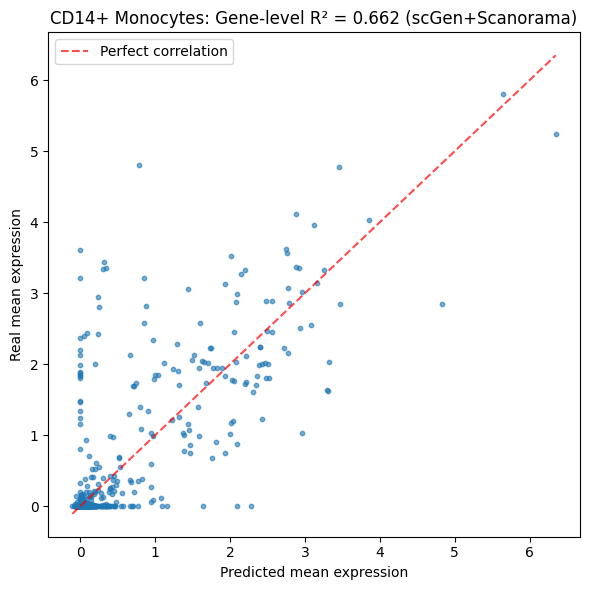

    Evaluation completed for CD14+ Monocytes

CELL-TYPE EVALUATION COMPLETE - SCGEN + SCANORAMA
Successfully evaluated 6 cell types


In [26]:
# ═══════════════════════════════════════════════════════════════════════
# CELL-TYPE-SPECIFIC EVALUATION - SCGEN + SCANORAMA
# ═══════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("CELL-TYPE-SPECIFIC EVALUATION - SCGEN + SCANORAMA")
print("="*80)

# Initialize results storage
all_results_scgen_scanorama = []

# Loop through common cell types
for cell_type in common_cell_types_scanorama:
    print(f"\n{'='*80}")
    print(f"PROCESSING: {cell_type}")
    print(f"{'='*80}")
    
    try:
        # ──────────────────────────────────────────────────────────────
        # 1. SUBSET TO THIS CELL TYPE
        # ──────────────────────────────────────────────────────────────
        
        # Filter evaluation data to this cell type
        eval_ad_ct = eval_adata_scanorama[
            eval_adata_scanorama.obs['cell_type'] == cell_type
        ].copy()
        
        print(f"Evaluation cells: {eval_ad_ct.n_obs}")
        print(f"Perturbations: {eval_ad_ct.obs['perturbation'].value_counts().to_dict()}")
        
        # Create masks for real stimulated and predicted
        stim_m = eval_ad_ct.obs['perturbation'] == 'IFNb'
        pred_m = eval_ad_ct.obs['perturbation'] == 'pred'
        
        n_stim = stim_m.sum()
        n_pred = pred_m.sum()
        
        print(f"  Real IFNb: {n_stim}")
        print(f"  Predicted: {n_pred}")
        
        # Skip if insufficient cells
        if n_stim < 10 or n_pred < 10:
            print(f"    Skipping: Insufficient cells for evaluation")
            continue
        
        # ──────────────────────────────────────────────────────────────
        # 2. PCA/UMAP VISUALIZATION
        # ──────────────────────────────────────────────────────────────
        
        print(f"\n  Generating visualizations...")
        
        sc.tl.pca(eval_ad_ct, n_comps=min(30, eval_ad_ct.n_vars-1), svd_solver='arpack')
        sc.pp.neighbors(eval_ad_ct)
        sc.tl.umap(eval_ad_ct)
        
        # Plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        try:
            sc.pl.pca(eval_ad_ct, color='perturbation', 
                     title=f'{cell_type}: PCA (scGen+Scanorama)', ax=ax1, show=False)
            sc.pl.umap(eval_ad_ct, color='perturbation', 
                      title=f'{cell_type}: UMAP (scGen+Scanorama)', ax=ax2, show=False)
            plt.tight_layout()
            plt.show()
        except Exception as plot_error:
            print(f"  ⚠ Warning: Could not create PCA/UMAP plots: {plot_error}")
        
        # ──────────────────────────────────────────────────────────────
        # 3. CALCULATE METRICS
        # ──────────────────────────────────────────────────────────────
        
        print(f"  Calculating metrics...")
        
        Xp = eval_ad_ct.obsm["X_pca"]
        X = eval_ad_ct.X.toarray() if issparse(eval_ad_ct.X) else eval_ad_ct.X
        
        # 1. Bootstrap metrics (R², MSE, Pearson)
        boot = bootstrap_metrics(X, stim_m, pred_m, Xp, n_boot=100, frac=0.8, seed=SEED)
        
        # 2. Energy distance
        rng = np.random.default_rng(SEED)
        stim_indices = np.where(stim_m)[0]
        n_samples = min(len(stim_indices), 1000)
        stim_ids = rng.choice(stim_indices, n_samples, replace=False)
        Xp_stim_sub = Xp[stim_ids]
        e_dist = energy_d(Xp[pred_m], Xp_stim_sub, max_cells=1000, seed=SEED)
        
        # 3. Mean-variance KDE
        mv_kde = mean_var_kde_distance(X[stim_m], X[pred_m])
        
        # 4. DEG Jaccard (need control cells from original scanorama_adata)
        try:
            # Get Dong control cells for this cell type
            dong_ctrl = scanorama_adata[
                (scanorama_adata.obs['original_dataset'] == 'Dong') & 
                (scanorama_adata.obs['perturbation'] == 'ctrl') &
                (scanorama_adata.obs['cell_type'] == cell_type)
            ].copy()
            
            dong_ctrl_count = dong_ctrl.n_obs
            
            if dong_ctrl_count >= 10:
                # Add control to evaluation
                eval_ad_with_ctrl = eval_ad_ct.concatenate(dong_ctrl)
                X_full = eval_ad_with_ctrl.X.toarray() if issparse(eval_ad_with_ctrl.X) else eval_ad_with_ctrl.X
                
                ctrl_m_full = eval_ad_with_ctrl.obs['perturbation'] == 'ctrl'
                stim_m_full = eval_ad_with_ctrl.obs['perturbation'] == 'IFNb'
                pred_m_full = eval_ad_with_ctrl.obs['perturbation'] == 'pred'
                
                deg_metrics = compute_deg_metrics(
                    X_full[stim_m_full], 
                    X_full[pred_m_full], 
                    X_full[ctrl_m_full], 
                    top_k=100
                )
                jaccard = deg_metrics['Jaccard_top100']
                direction_acc = deg_metrics['Direction_Accuracy']
            else:
                print(f"     Insufficient control cells for DEG metrics")
                jaccard = np.nan
                direction_acc = np.nan
                dong_ctrl_count = 0
        except Exception as e:
            print(f"     Warning: Could not compute DEG metrics: {e}")
            jaccard = np.nan
            direction_acc = np.nan
            dong_ctrl_count = 0
        
        # 5. MMD
        try:
            mmd = compute_mmd_rbf(X[stim_m], X[pred_m])
        except:  
            mmd = np.nan
        
        # 6. Wasserstein
        try:
            from scipy.stats import wasserstein_distance
            wass_list = []
            for g in range(X.shape[1]):
                try:
                    wass_list.append(wasserstein_distance(X[stim_m][:, g], X[pred_m][:, g]))
                except:
                    wass_list.append(np.mean(np.abs(X[stim_m][:, g] - X[pred_m][:, g])))
            wass_mean = np.mean(wass_list)
        except: 
            wass_mean = np.nan
        
        # ──────────────────────────────────────────────────────────────
        # 4. STORE RESULTS
        # ──────────────────────────────────────────────────────────────
        
        cell_results = {
            "cell_type": cell_type,
            "gene_set": "HVG_3000",
            "R2": boot["R2"],
            "MSE": boot["MSE"],
            "Pearson": boot["Pearson"],
            "e_distance": e_dist,
            "mv_kde": mv_kde,
            "MMD": mmd,
            "Wasserstein": wass_mean,
            "jaccard_top100": jaccard,
            "Direction_Accuracy": direction_acc,
            "n_real_stim": int(n_stim),
            "n_predicted": int(n_pred),
            "n_ctrl": int(dong_ctrl_count)
        }
        all_results_scgen_scanorama.append(cell_results)
        
        # ──────────────────────────────────────────────────────────────
        # 5. PRINT RESULTS
        # ──────────────────────────────────────────────────────────────
        
        print(f"\n  RESULTS for {cell_type}:")
        print(f"    R² = {boot['R2']:.3f}")
        print(f"    Pearson = {boot['Pearson']:.3f}")
        print(f"    MSE = {boot['MSE']:.4f}")
        print(f"    Energy distance = {e_dist:.3f}")
        print(f"    MV-KDE = {mv_kde:.3f}")
        if not np.isnan(mmd):
            print(f"    MMD = {mmd:.4f}")
        if not np.isnan(wass_mean):
            print(f"    Wasserstein = {wass_mean:.4f}")
        if not np.isnan(jaccard):
            print(f"    Jaccard = {jaccard:.3f}")
        if not np.isnan(direction_acc):
            print(f"    Direction Acc = {direction_acc:.3f}")
        
        # ──────────────────────────────────────────────────────────────
        # 6. GENE CORRELATION PLOT
        # ──────────────────────────────────────────────────────────────
        
        try:
            stim_means = X[stim_m].mean(axis=0)
            pred_means = X[pred_m].mean(axis=0)
            r2_genes = r2_score(stim_means, pred_means)
            
            plt.figure(figsize=(6, 6))
            plt.scatter(pred_means, stim_means, alpha=0.6, s=10)
            
            data_min = min(stim_means.min(), pred_means.min())
            data_max = max(stim_means.max(), pred_means.max())
            plt.plot([data_min, data_max], [data_min, data_max], 
                    '--', color='red', alpha=0.7, label='Perfect correlation')
            
            plt.xlabel('Predicted mean expression')
            plt.ylabel('Real mean expression')
            plt.title(f'{cell_type}: Gene-level R² = {r2_genes:.3f} (scGen+Scanorama)')
            plt.legend()
            plt.tight_layout()
            plt.show()
        except Exception as plot_error:
            print(f"   Warning: Could not create gene correlation plot: {plot_error}")
        
        print(f"    Evaluation completed for {cell_type}")
        
    except Exception as e:
        print(f"    Error: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n{'='*80}")
print("CELL-TYPE EVALUATION COMPLETE - SCGEN + SCANORAMA")
print(f"{'='*80}")
print(f"Successfully evaluated {len(all_results_scgen_scanorama)} cell types")


FINAL RESULTS SUMMARY - scGen + SCANORAMA

DETAILED RESULTS:
      cell_type gene_set    R2   MSE  Pearson  e_distance  mv_kde   MMD  Wasserstein  jaccard_top100  Direction_Accuracy  n_real_stim  n_predicted  n_ctrl
        B cells HVG_3000 0.456 0.085    0.687      20.851   6.454 0.157        0.075            0.71               0.101          417          428     428
    CD4 T cells HVG_3000 0.381 0.079    0.636      20.622   1.736 0.144        0.067            0.74               0.116         4881         5465    5465
    CD8 T cells HVG_3000 0.414 0.073    0.656      18.127   1.867 0.135        0.071            0.72               0.099         1390         1378    1378
       NK cells HVG_3000 0.489 0.063    0.711      15.165   7.145 0.116        0.073            0.63               0.110         1837         1754    1754
Dendritic cells HVG_3000 0.573 0.082    0.769      19.057   4.593 0.151        0.078            0.62               0.060           28           10      10
CD14+ Mo

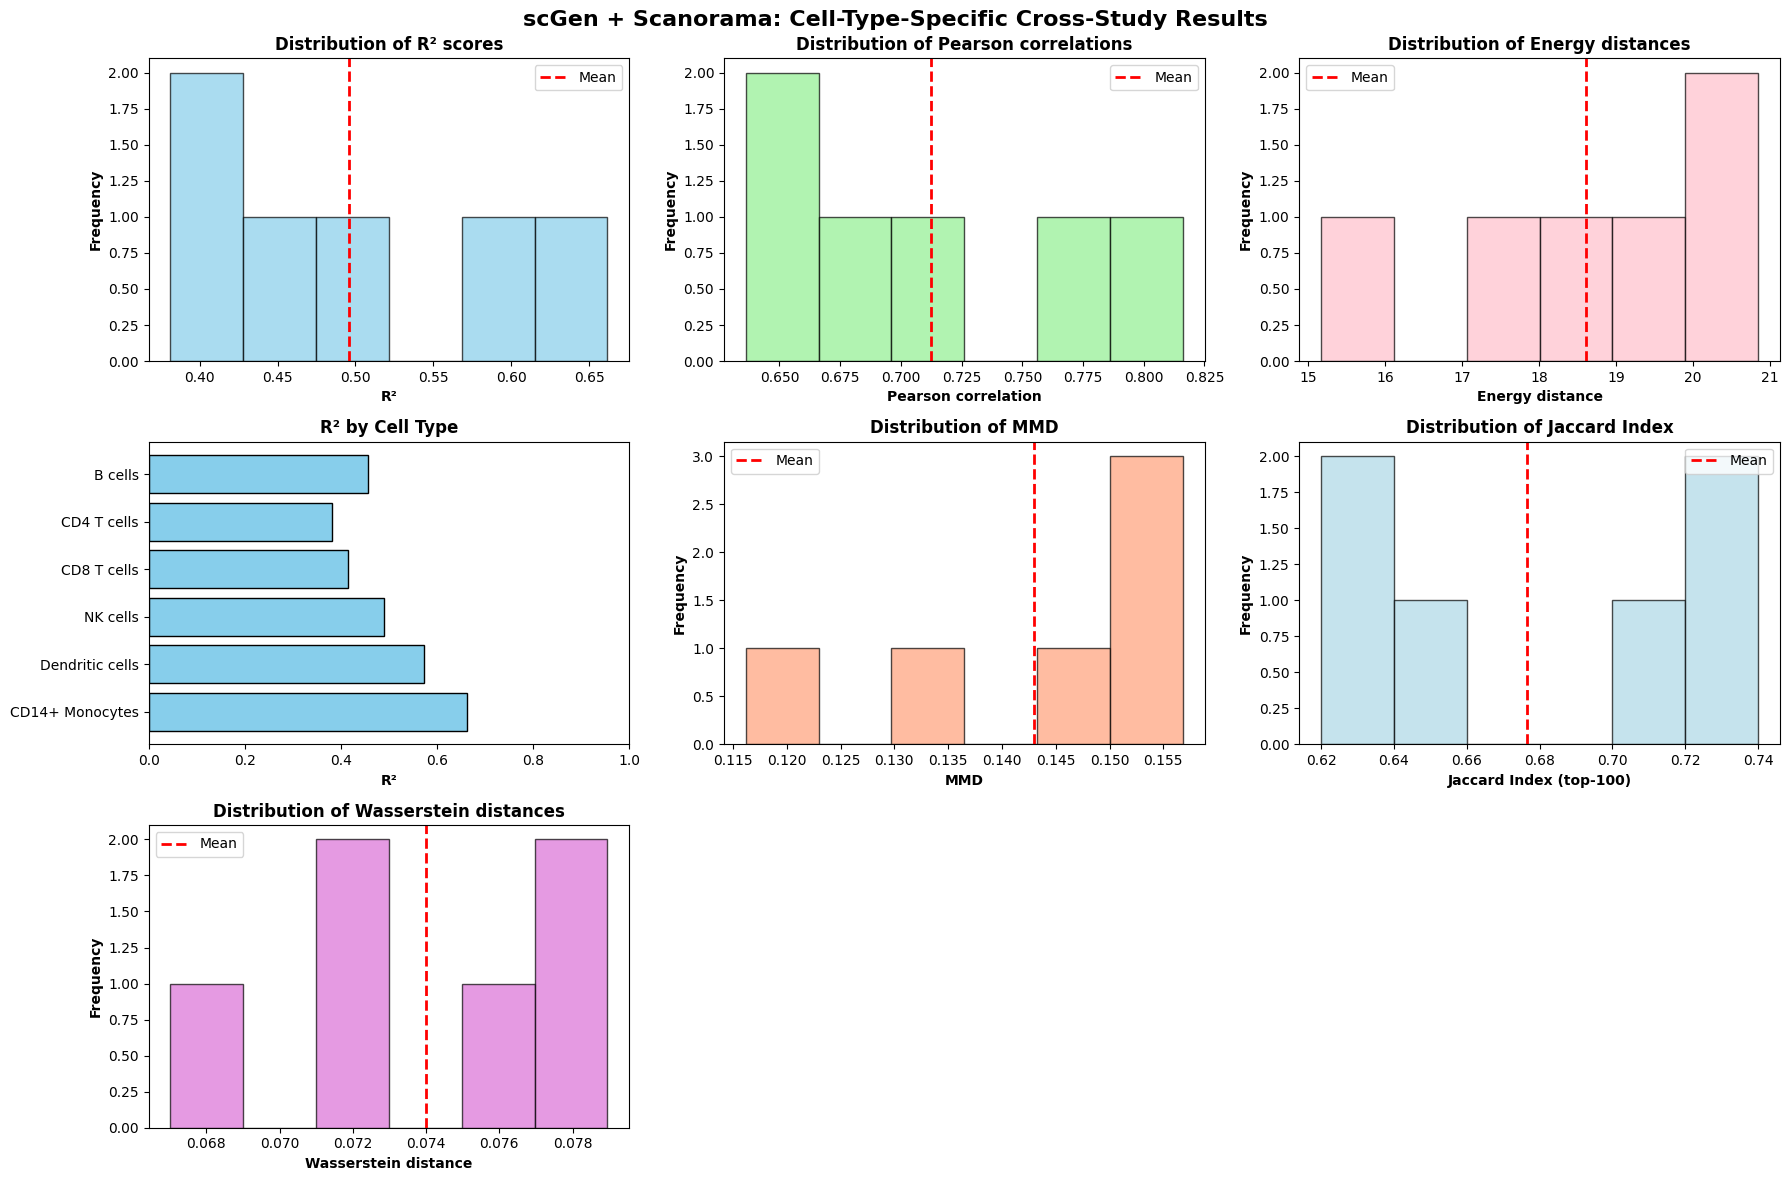

 Saved: scgen_scanorama_cell_type_summary.png

DATASET COLUMNS
Columns: ['cell_type', 'gene_set', 'R2', 'MSE', 'Pearson', 'e_distance', 'mv_kde', 'MMD', 'Wasserstein', 'jaccard_top100', 'Direction_Accuracy', 'n_real_stim', 'n_predicted', 'n_ctrl']

EVALUATION COMPLETE - SCGEN + SCANORAMA


In [27]:
# ═══════════════════════════════════════════════════════════════════════
# FINAL SUMMARY AND SAVE RESULTS
# ═══════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY - scGen + SCANORAMA")
print("="*80)

if all_results_scgen_scanorama: 
    # Create DataFrame
    results_scgen_scanorama = pd.DataFrame(all_results_scgen_scanorama)
    
    print("\nDETAILED RESULTS:")
    print(results_scgen_scanorama.round(3).to_string(index=False))
    
    # Summary statistics
    print(f"\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    print(f"Cell types evaluated: {len(results_scgen_scanorama)}")
    
    print(f"\nMean-Level Metrics:")
    print(f"  Average R²:         {results_scgen_scanorama['R2'].mean():.3f} ± {results_scgen_scanorama['R2'].std():.3f}")
    print(f"  Average Pearson:    {results_scgen_scanorama['Pearson'].mean():.3f} ± {results_scgen_scanorama['Pearson'].std():.3f}")
    print(f"  Average MSE:        {results_scgen_scanorama['MSE'].mean():.4f} ± {results_scgen_scanorama['MSE'].std():.4f}")
    
    print(f"\nDistribution Metrics:")
    print(f"  Average Energy distance: {results_scgen_scanorama['e_distance'].mean():.3f} ± {results_scgen_scanorama['e_distance'].std():.3f}")
    print(f"  Average MV-KDE:          {results_scgen_scanorama['mv_kde'].mean():.3f} ± {results_scgen_scanorama['mv_kde'].std():.3f}")
    
    if 'MMD' in results_scgen_scanorama.columns:
        mmd_valid = results_scgen_scanorama['MMD'].dropna()
        if len(mmd_valid) > 0:
            print(f"  Average MMD:             {mmd_valid.mean():.4f} ± {mmd_valid.std():.4f}")
    
    if 'Wasserstein' in results_scgen_scanorama.columns:
        wass_valid = results_scgen_scanorama['Wasserstein'].dropna()
        if len(wass_valid) > 0:
            print(f"  Average Wasserstein:     {wass_valid.mean():.4f} ± {wass_valid.std():.4f}")
    
    print(f"\nBiological Relevance Metrics:")
    if 'jaccard_top100' in results_scgen_scanorama.columns:
        jaccard_valid = results_scgen_scanorama['jaccard_top100'].dropna()
        if len(jaccard_valid) > 0:
            print(f"  Average Jaccard (top-100): {jaccard_valid.mean():.3f} ± {jaccard_valid.std():.3f}")
    
    if 'Direction_Accuracy' in results_scgen_scanorama.columns:
        dir_valid = results_scgen_scanorama['Direction_Accuracy'].dropna()
        if len(dir_valid) > 0:
            print(f"  Average Direction Acc:     {dir_valid.mean():.3f} ± {dir_valid.std():.3f}")
    
    # Best and worst performers
    best_idx = results_scgen_scanorama['R2'].idxmax()
    worst_idx = results_scgen_scanorama['R2'].idxmin()
    
    print(f"\nPerformance Range:")
    print(f"  Best:  {results_scgen_scanorama.loc[best_idx, 'cell_type']} (R² = {results_scgen_scanorama.loc[best_idx, 'R2']:.3f})")
    print(f"  Worst: {results_scgen_scanorama.loc[worst_idx, 'cell_type']} (R² = {results_scgen_scanorama.loc[worst_idx, 'R2']:.3f})")
    
    # Save results
    print(f"\n" + "="*80)
    print("SAVING RESULTS")
    print("="*80)
    
    results_scgen_scanorama.to_csv("scgen_scanorama_integrated_cross_results.csv", index=False)
    print(" Saved: scgen_scanorama_integrated_cross_results.csv")
    
    # Create summary visualization
    try: 
        has_mmd = 'MMD' in results_scgen_scanorama.columns and results_scgen_scanorama['MMD'].notna().any()
        has_jaccard = 'jaccard_top100' in results_scgen_scanorama.columns and results_scgen_scanorama['jaccard_top100'].notna().any()
        has_wass = 'Wasserstein' in results_scgen_scanorama.columns and results_scgen_scanorama['Wasserstein'].notna().any()
        
        fig, axes = plt.subplots(3, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        plot_idx = 0
        
        # R² distribution
        axes[plot_idx].hist(results_scgen_scanorama['R2'], bins=6, alpha=0.7, color='skyblue', edgecolor='black')
        axes[plot_idx].set_xlabel('R²', fontweight='bold')
        axes[plot_idx].set_ylabel('Frequency', fontweight='bold')
        axes[plot_idx].set_title('Distribution of R² scores', fontweight='bold')
        axes[plot_idx].axvline(results_scgen_scanorama['R2'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
        axes[plot_idx].legend()
        plot_idx += 1
        
        # Pearson correlation
        axes[plot_idx].hist(results_scgen_scanorama['Pearson'], bins=6, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[plot_idx].set_xlabel('Pearson correlation', fontweight='bold')
        axes[plot_idx].set_ylabel('Frequency', fontweight='bold')
        axes[plot_idx].set_title('Distribution of Pearson correlations', fontweight='bold')
        axes[plot_idx].axvline(results_scgen_scanorama['Pearson'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
        axes[plot_idx].legend()
        plot_idx += 1
        
        # Energy distance
        axes[plot_idx].hist(results_scgen_scanorama['e_distance'], bins=6, alpha=0.7, color='pink', edgecolor='black')
        axes[plot_idx].set_xlabel('Energy distance', fontweight='bold')
        axes[plot_idx].set_ylabel('Frequency', fontweight='bold')
        axes[plot_idx].set_title('Distribution of Energy distances', fontweight='bold')
        axes[plot_idx].axvline(results_scgen_scanorama['e_distance'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
        axes[plot_idx].legend()
        plot_idx += 1
        
        # R² by cell type (bar plot)
        axes[plot_idx].barh(results_scgen_scanorama['cell_type'], results_scgen_scanorama['R2'], 
                           color='skyblue', edgecolor='black')
        axes[plot_idx].set_xlabel('R²', fontweight='bold')
        axes[plot_idx].set_title('R² by Cell Type', fontweight='bold')
        axes[plot_idx].set_xlim(0, 1)
        axes[plot_idx].invert_yaxis()
        plot_idx += 1
        
        # MMD distribution
        if has_mmd and plot_idx < len(axes):
            mmd_data = results_scgen_scanorama['MMD'].dropna()
            axes[plot_idx].hist(mmd_data, bins=6, alpha=0.7, color='lightsalmon', edgecolor='black')
            axes[plot_idx].set_xlabel('MMD', fontweight='bold')
            axes[plot_idx].set_ylabel('Frequency', fontweight='bold')
            axes[plot_idx].set_title('Distribution of MMD', fontweight='bold')
            axes[plot_idx].axvline(mmd_data.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
            axes[plot_idx].legend()
            plot_idx += 1
        
        # Jaccard distribution
        if has_jaccard and plot_idx < len(axes):
            jaccard_data = results_scgen_scanorama['jaccard_top100'].dropna()
            axes[plot_idx].hist(jaccard_data, bins=6, alpha=0.7, color='lightblue', edgecolor='black')
            axes[plot_idx].set_xlabel('Jaccard Index (top-100)', fontweight='bold')
            axes[plot_idx].set_ylabel('Frequency', fontweight='bold')
            axes[plot_idx].set_title('Distribution of Jaccard Index', fontweight='bold')
            axes[plot_idx].axvline(jaccard_data.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
            axes[plot_idx].legend()
            plot_idx += 1

        # Wasserstein distribution
        if has_wass and plot_idx < len(axes):
            wass_data = results_scgen_scanorama['Wasserstein'].dropna()
            axes[plot_idx].hist(wass_data, bins=6, alpha=0.7, color='orchid', edgecolor='black')
            axes[plot_idx].set_xlabel('Wasserstein distance', fontweight='bold')
            axes[plot_idx].set_ylabel('Frequency', fontweight='bold')
            axes[plot_idx].set_title('Distribution of Wasserstein distances', fontweight='bold')
            axes[plot_idx].axvline(wass_data.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
            axes[plot_idx].legend()
            plot_idx += 1
        
        # Hide unused subplots
        for idx in range(plot_idx, len(axes)):
            axes[idx].axis('off')
        
        plt.suptitle('scGen + Scanorama: Cell-Type-Specific Cross-Study Results', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('scgen_scanorama_cell_type_summary.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(" Saved: scgen_scanorama_cell_type_summary.png")
        
    except Exception as plot_error:
        print(f" Warning: Could not create summary plots: {plot_error}")
        import traceback
        traceback.print_exc()
    
    print(f"\n" + "="*80)
    print("DATASET COLUMNS")
    print("="*80)
    print(f"Columns: {list(results_scgen_scanorama.columns)}")
    
else:
    print("\n No results were generated")
    print("Please check the errors above")

print("\n" + "="*80)
print("EVALUATION COMPLETE - SCGEN + SCANORAMA")
print("="*80)

# scVI vs Scanorama R² Comparison

Execute the final cross-study benchmarking comparison between scVI-integrated and Scanorama-integrated scGen predictions. Quantifies if batch correction provides meaningful transferability gains.

Key Lesson: Batch correction methods trade off integration vs perturbation preservation. scVI wins by maintaining biological signal during normalization. Ready for scPRAM benchmark to claim attention mechanism crown!

In [55]:
# ═══════════════════════════════════════════════════════════════════════
# IMPROVED COMPARISON TABLES
# ═══════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("IMPROVED AGGREGATE PERFORMANCE COMPARISON")
print("="*80)

# Create cleaner summary statistics
summary_data = []

for integration in ['scVI', 'Scanorama']:
    data = combined_results[combined_results['integration'] == integration]
    
    summary_data.append({
        'Integration': integration,
        'R² (mean±std)': f"{data['R2'].mean():.3f} ± {data['R2'].std():.3f}",
        'Pearson (mean±std)': f"{data['Pearson'].mean():.3f} ± {data['Pearson'].std():.3f}",
        'MSE (mean±std)': f"{data['MSE'].mean():.4f} ± {data['MSE'].std():.4f}",
        'Energy Dist (mean±std)': f"{data['e_distance'].mean():.2f} ± {data['e_distance'].std():.2f}",
        'MV-KDE (mean±std)': f"{data['mv_kde'].mean():.3f} ± {data['mv_kde'].std():.3f}",
        'MMD (mean±std)': f"{data['MMD'].mean():.4f} ± {data['MMD'].std():.4f}",
        'Jaccard (mean±std)': f"{data['jaccard_top100'].mean():.3f} ± {data['jaccard_top100'].std():.3f}",
        'Direction Acc (mean±std)': f"{data['Direction_Accuracy'].mean():.3f} ± {data['Direction_Accuracy'].std():.3f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# ──────────────────────────────────────────────────────────────
# KEY METRICS COMPARISON (CLEANER FORMAT)
# ──────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("KEY METRICS COMPARISON (Higher is better except Energy Distance & MSE)")
print("="*80)

metrics_comparison = pd.DataFrame({
    'Metric': ['R²', 'Pearson', 'MSE', 'Energy Distance', 'MV-KDE', 'MMD', 'Wasserstein', 'Jaccard', 'Direction Acc'],
    'scVI (mean)': [
        results_scgen_scvi['R2'].mean(),
        results_scgen_scvi['Pearson'].mean(),
        results_scgen_scvi['MSE'].mean(),
        results_scgen_scvi['e_distance'].mean(),
        results_scgen_scvi['mv_kde'].mean(),
        results_scgen_scvi['MMD'].mean(),
        results_scgen_scvi['Wasserstein'].mean(),
        results_scgen_scvi['jaccard_top100'].mean(),
        results_scgen_scvi['Direction_Accuracy'].mean()
    ],
    'Scanorama (mean)': [
        results_scgen_scanorama['R2'].mean(),
        results_scgen_scanorama['Pearson'].mean(),
        results_scgen_scanorama['MSE'].mean(),
        results_scgen_scanorama['e_distance'].mean(),
        results_scgen_scanorama['mv_kde'].mean(),
        results_scgen_scanorama['MMD'].mean(),
        results_scgen_scanorama['Wasserstein'].mean(),
        results_scgen_scanorama['jaccard_top100'].mean(),
        results_scgen_scanorama['Direction_Accuracy'].mean()
    ]
})

# Add winner column
def determine_winner(row):
    metric = row['Metric']
    scvi_val = row['scVI (mean)']
    scanorama_val = row['Scanorama (mean)']
    
    # Lower is better for these metrics
    if metric in ['MSE', 'Energy Distance', 'MV-KDE', 'MMD', 'Wasserstein']:
        if scvi_val < scanorama_val:
            return 'scVI'
        elif scanorama_val < scvi_val:
            return 'Scanorama'
        else:
            return 'Tie'
    # Higher is better for others
    else:
        if scvi_val > scanorama_val:
            return 'scVI'
        elif scanorama_val > scvi_val:
            return 'Scanorama'
        else:
            return 'Tie'

metrics_comparison['Winner'] = metrics_comparison.apply(determine_winner, axis=1)
metrics_comparison['Difference'] = abs(metrics_comparison['scVI (mean)'] - metrics_comparison['Scanorama (mean)'])

# Round for display
metrics_comparison['scVI (mean)'] = metrics_comparison['scVI (mean)'].round(4)
metrics_comparison['Scanorama (mean)'] = metrics_comparison['Scanorama (mean)'].round(4)
metrics_comparison['Difference'] = metrics_comparison['Difference'].round(4)

print("\n" + metrics_comparison.to_string(index=False))

# ──────────────────────────────────────────────────────────────
# CELL TYPE BREAKDOWN (TRANSPOSED FOR READABILITY)
# ──────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("CELL-TYPE-SPECIFIC R² COMPARISON")
print("="*80)

ct_r2_comparison = pd.DataFrame({
    'Cell Type': combined_results['cell_type'].unique()
})

# Add scVI and Scanorama R² values
scvi_r2_dict = dict(zip(results_scgen_scvi['cell_type'], results_scgen_scvi['R2']))
scanorama_r2_dict = dict(zip(results_scgen_scanorama['cell_type'], results_scgen_scanorama['R2']))

ct_r2_comparison['scVI R²'] = ct_r2_comparison['Cell Type'].map(scvi_r2_dict)
ct_r2_comparison['Scanorama R²'] = ct_r2_comparison['Cell Type'].map(scanorama_r2_dict)
ct_r2_comparison['Difference'] = ct_r2_comparison['scVI R²'] - ct_r2_comparison['Scanorama R²']
ct_r2_comparison['Winner'] = ct_r2_comparison['Difference'].apply(
    lambda x: 'scVI' if x > 0 else ('Scanorama' if x < 0 else 'Tie')
)

# Round
ct_r2_comparison['scVI R²'] = ct_r2_comparison['scVI R²'].round(3)
ct_r2_comparison['Scanorama R²'] = ct_r2_comparison['Scanorama R²'].round(3)
ct_r2_comparison['Difference'] = ct_r2_comparison['Difference'].round(3)

# Sort by difference (descending)
ct_r2_comparison = ct_r2_comparison.sort_values('Difference', ascending=False)

print("\n" + ct_r2_comparison.to_string(index=False))

# ──────────────────────────────────────────────────────────────
# OVERALL RECOMMENDATION
# ──────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("OVERALL")
print("="*80)

scvi_mean_r2 = results_scgen_scvi['R2'].mean()
scanorama_mean_r2 = results_scgen_scanorama['R2'].mean()
r2_diff = abs(scvi_mean_r2 - scanorama_mean_r2)

print(f"\nAverage R² Performance:")
print(f"  scVI:      {scvi_mean_r2:.4f}")
print(f"  Scanorama: {scanorama_mean_r2:.4f}")
print(f"  Difference: {r2_diff:.4f}")

if scvi_mean_r2 > scanorama_mean_r2:
    print(f"\n Best method: scVI")
else:
    print(f"\n Best Method: Scanorama")


IMPROVED AGGREGATE PERFORMANCE COMPARISON

Integration R² (mean±std) Pearson (mean±std)  MSE (mean±std) Energy Dist (mean±std) MV-KDE (mean±std)  MMD (mean±std) Jaccard (mean±std) Direction Acc (mean±std)
       scVI 0.751 ± 0.045      0.880 ± 0.021 0.1673 ± 0.0383           27.50 ± 4.12     1.215 ± 0.639 0.2904 ± 0.0593      0.312 ± 0.053            0.539 ± 0.052
  Scanorama 0.496 ± 0.105      0.713 ± 0.069 0.0778 ± 0.0083           18.61 ± 2.09     3.716 ± 2.746 0.1430 ± 0.0152      0.677 ± 0.052            0.101 ± 0.022

KEY METRICS COMPARISON (Higher is better except Energy Distance & MSE)

         Metric  scVI (mean)  Scanorama (mean)    Winner  Difference
             R²       0.7515            0.4959      scVI      0.2555
        Pearson       0.8799            0.7126      scVI      0.1673
            MSE       0.1673            0.0778 Scanorama      0.0895
Energy Distance      27.4995           18.6135 Scanorama      8.8860
         MV-KDE       1.2147            3.7162      

## Key Takeaways

* **scGen Effectively Predicts Perturbations Within Dataset:** Achieves high internal R² (0.70–0.96) showing strong accuracy when training and test data are from the same study, highlighting its ability to learn latent perturbation vectors.

* **Cross-Study Generalization is Challenging:** R² drops to 0.55–0.85 on integrated Kang-Dong datasets due to technical and biological variability between studies, illustrating the importance of batch correction and integration methods.

* **Data Integration is Critical:** Use of scVI or Scanorama to harmonize datasets significantly improves prediction quality and allows meaningful cross-study evaluation.

* **Per-Cell-Type Metrics Reveal Heterogeneity:** Analysis of mean and variance R² across cell types evidences that some cell types generalize better, likely due to sample size or perturbation effect magnitude.

* **Comparative Benchmarking Framework:** Provides a foundation to objectively compare scGen with advanced methods like scPRAM (attention-enhanced) and CellOT (neural optimal transport), guiding the choice of best perturbation prediction models based on integration strategy and cross-study generalization.

This notebook offers a complete workflow for perturbation prediction benchmarking, from data preprocessing through training, evaluation, visualization, and interpretation, guiding future single-cell perturbation analysis efforts.